### Purpose of Notebook: build model to predict whether or not a premier league match will have a score greater than 2 (or 2.5 as the bettings firms classify the cutoff point)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson,skellam
from pandas.plotting import scatter_matrix
import datetime
from functools import reduce
#from astropy.stats import boostrap
%matplotlib inline
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_info_columns', 150)
pd.set_option('display.max_info_rows', 150)
plt.style.use('seaborn')

In [2]:
# pull data and explore
df = pd.read_csv("season-1819.csv")
df2 = pd.read_csv("season-1718.csv")

# create total score field, which will need for binary label
df['total_score'] = (df.FTHG + df.FTAG)
df2['total_score'] = (df2.FTHG + df2.FTAG)

# get overview of dataframes
print('18-19 df info and head:\n')
df.info()
df.head()
df.describe()

print('\n18-19 df info and head:\n')
df2.info()
df2.head()
df2.describe()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 52.0+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2018-08-10    Man United       Leicester     2     1   H     1     0   H   
1  2018-08-11   Bournemouth         Cardiff     2     0   H     1     0   H   
2  2018-08-11        Fulham  Crystal Palace     0     2   A     0     1   A   
3  2018-08-11  Huddersfield         Chelsea     0     3   A     0     2   A   
4  2018-08-11     Newcastle       Tottenham     1     2   A     1     2   A   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3  
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2  
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2  
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3  
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3

FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  289.000000  289.000000  289.000000  289.000000  289.000000  289.000000   
mean     1.564014    1.252595    0.698962    0.581315   14.076125   10.937716   
std      1.339913    1.164523    0.883510    0.782489    5.915588    4.305552   
min      0.000000    0.000000    0.000000    0.000000    0.000000    2.000000   
25%      1.000000    0.000000    0.000000    0.000000   10.000000    8.000000   
50%      1.000000    1.000000    0.000000    0.000000   13.000000   10.000000   
75%      2.000000    2.000000    1.000000    1.000000   17.000000   14.000000   
max      6.000000    6.000000    4.000000    3.000000   36.000000   25.000000   

              HST         AST          HF          AF         HC          AC  \
count  289.000000  289.000000  289.000000  289.000000  289.00000  289.000000   
mean     4.820069    3.930796   10.494810   10.363322    5.67474    4.577855   
std      2.686543    2.245842    3.222233    3.571128    2.92346    2.738929   
min      0.000000    0.000000    2.000000    3.000000    0.00000    0.000000   
25%      3.000000    2.000000    8.000000    8.000000    4.00000    3.000000   
50%      5.000000    4.000000   10.000000   10.000000    5.00000    4.000000   
75%      6.000000    5.000000   12.000000   13.000000    8.00000    6.000000   
max     14.000000   12.000000   23.000000   21.000000   14.00000   14.000000   

               HY          AY          HR          AR  total_score  
count  289.000000  289.000000  289.000000  289.000000   289.000000  
mean     1.550173    1.723183    0.051903    0.083045     2.816609  
std      1.218381    1.213144    0.222216    0.276429     1.610814  
min      0.000000    0.000000    0.000000    0.000000     0.000000  
25%      1.000000    1.000000    0.000000    0.000000     2.000000  
50%      1.000000    2.000000    0.000000    0.000000     3.000000  
75%      2.000000    2.000000    0.000000    0.000000     4.000000  
max      6.000000    5.000000    1.000000    1.000000     8.000000


18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 68.4+ KB


Date        HomeTeam      AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2017-08-11         Arsenal     Leicester     4     3   H     2     2   D   
1  2017-08-12        Brighton      Man City     0     2   A     0     0   D   
2  2017-08-12         Chelsea       Burnley     2     3   A     0     3   A   
3  2017-08-12  Crystal Palace  Huddersfield     0     3   A     0     2   A   
4  2017-08-12         Everton         Stoke     1     0   H     1     0   H   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7  
1     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2  
2     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5  
3       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3  
4  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1

FTHG        FTAG        HTHG        HTAG          HS          AS  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000   
mean     1.531579    1.147368    0.607895    0.515789   13.584211   10.855263   
std      1.340087    1.177793    0.793403    0.756511    5.771439    4.858700   
min      0.000000    0.000000    0.000000    0.000000    2.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000    9.000000    7.000000   
50%      1.000000    1.000000    0.000000    0.000000   13.000000   10.500000   
75%      2.000000    2.000000    1.000000    1.000000   17.000000   14.000000   
max      7.000000    6.000000    4.000000    3.000000   35.000000   30.000000   

              HST         AST          HF          AF          HC          AC  \
count  380.000000  380.000000  380.000000  380.000000  380.000000  380.000000   
mean     4.626316    3.763158   10.218421   10.478947    5.739474    4.544737   
std      2.706845    2.317015    3.256360    3.336388    2.993047    2.767241   
min      0.000000    0.000000    2.000000    3.000000    0.000000    0.000000   
25%      3.000000    2.000000    8.000000    8.000000    4.000000    2.000000   
50%      4.000000    3.500000   10.000000   10.000000    5.000000    4.000000   
75%      6.000000    5.000000   12.000000   13.000000    8.000000    6.000000   
max     15.000000   14.000000   19.000000   26.000000   18.000000   13.000000   

               HY          AY          HR          AR  total_score  
count  380.000000  380.000000  380.000000  380.000000   380.000000  
mean     1.478947    1.565789    0.044737    0.057895     2.678947  
std      1.256993    1.259639    0.219375    0.233852     1.665125  
min      0.000000    0.000000    0.000000    0.000000     0.000000  
25%      1.000000    1.000000    0.000000    0.000000     1.000000  
50%      1.000000    1.000000    0.000000    0.000000     3.000000  
75%      2.000000    2.000000    0.000000    0.000000     4.000000  
max      6.000000    7.000000    2.000000    1.000000     9.000000

### ^^ Great, we don't have to worry about missing data.

# first look at goal distribution

In [3]:
# creating hist plotting function, 
# overlay with poisson pmf, common distribution for sports goals
def hagoal_plot(df=df, title='#Goals/Match', 
                bin_field=['FTHG','FTAG'], 
                hist_label=['Home', 'Away'], 
                set_alpha=0.5,
                goal_max=10):
    """function to create the home/away goal histogram with poisson pmf overlay"""
    
    pos_pred = np.column_stack([[poisson.pmf(i, df[bin_field].mean()[j]) for i in range(goal_max)] 
                                    for j in range(len(bin_field))])

    # poisson pmf lines
    if len(bin_field) == 2:
        plt.hist(df[bin_field].values, range(10), 
                  alpha=set_alpha, label=hist_label,
                  density=True, color=['r', 'b'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = 'r')
        _pois2, = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = 'b')
    else:
        plt.hist(df[bin_field].values, range(10), 
                 alpha=set_alpha, label=hist_label,density=True, color=['r'])
        _pois_1 = plt.plot([i-0.5 for i in range(1,goal_max+1)], pos_pred[:,0],
                  linestyle='-', marker='o',label="Total Score", color = 'r')

    plt.xticks([i-0.5 for i in range(1,goal_max+1)],[i for i in range(10)])
    leg=plt.legend(loc='upper right', fontsize=15, ncol=2)
    leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
    plt.xlabel("#Goals/Match",size=13)
    plt.ylabel("% of Matches",size=13)
    plt.title(title, size=14, fontweight='bold')
    plt.ylim([-0.004, 0.4])
    plt.tight_layout()
    plt.show() 

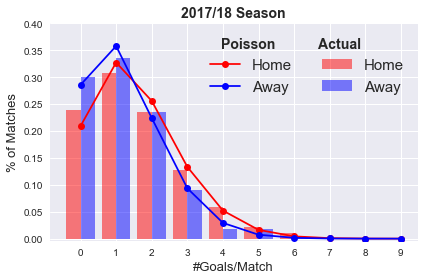

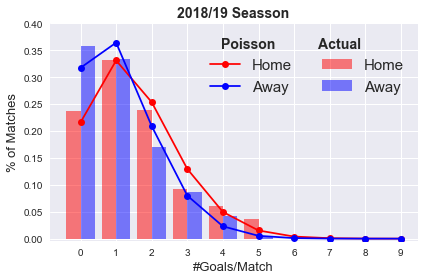

In [4]:
# run goal plotting function on 2017/18 and 2017/18 seasons and combined
hagoal_plot(df=df, title='2017/18 Season')
hagoal_plot(df=df2, title='2018/19 Seasson')

### ^^^ Looks like home/away goals hist follow quite closely to their relative poisson pmfs

In [5]:
# create total score field, which will be label/y value of model
df_total = pd.concat([df, df2], ignore_index=True)
print('18-19 df info and head:\n')
df_total.info()
df_total.head()

18-19 df info and head:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 23 columns):
Date           object
HomeTeam       object
AwayTeam       object
FTHG           int64
FTAG           int64
FTR            object
HTHG           int64
HTAG           int64
HTR            object
Referee        object
HS             int64
AS             int64
HST            int64
AST            int64
HF             int64
AF             int64
HC             int64
AC             int64
HY             int64
AY             int64
HR             int64
AR             int64
total_score    int64
dtypes: int64(17), object(6)
memory usage: 120.3+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  2018-08-10    Man United       Leicester     2     1   H     1     0   H   
1  2018-08-11   Bournemouth         Cardiff     2     0   H     1     0   H   
2  2018-08-11        Fulham  Crystal Palace     0     2   A     0     1   A   
3  2018-08-11  Huddersfield         Chelsea     0     3   A     0     2   A   
4  2018-08-11     Newcastle       Tottenham     1     2   A     1     2   A   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3  
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2  
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2  
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3  
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3

In [6]:
# now lets look at the mean of the home/away goals
df[['FTHG','FTAG']].mean()
df2[['FTHG','FTAG']].mean()
df_total[['FTHG','FTAG']].mean()

# now look at variance
np.var(df[['FTHG','FTAG']])
np.var(df2[['FTHG','FTAG']])
np.var(df_total[['FTHG','FTAG']])

# for reference in poisson distribution the
# expected value = variance

FTHG    1.564014
FTAG    1.252595
dtype: float64

FTHG    1.531579
FTAG    1.147368
dtype: float64

FTHG    1.545590
FTAG    1.192825
dtype: float64

FTHG    1.789155
FTAG    1.351421
dtype: float64

FTHG    1.791108
FTAG    1.383546
dtype: float64

FTHG    1.790522
FTAG    1.372385
dtype: float64

#### ^^ the variance looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

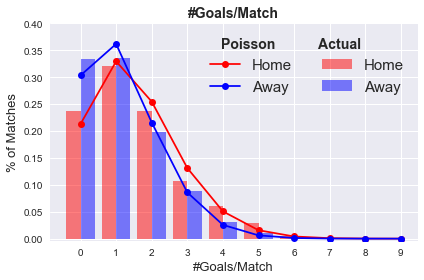

In [7]:
hagoal_plot(df=df_total)

### ^^^ both seasons combined also follows closely to the poisson

## Now lets do the same plotting exercise but for total goals 

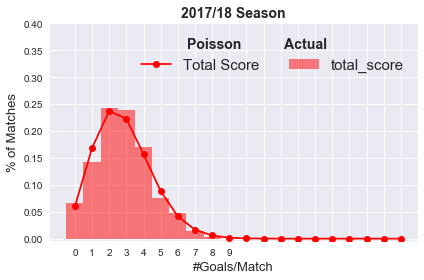

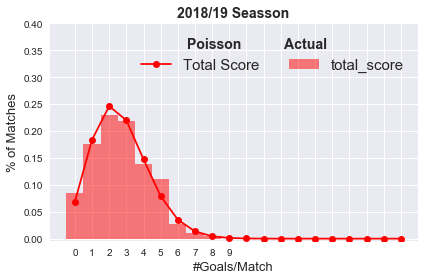

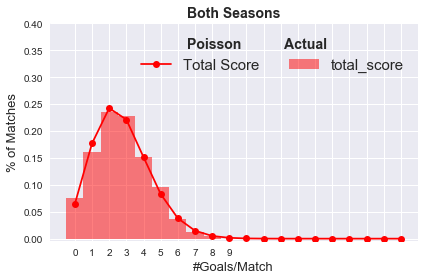

In [8]:
hagoal_plot(df=df, title='2017/18 Season', 
            bin_field=['total_score'], 
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df2, title='2018/19 Seasson',
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)
hagoal_plot(df=df_total, title='Both Seasons', 
            bin_field=['total_score'],
            hist_label=['total_score'],
            goal_max = 20)

In [9]:
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

2.8166089965397925

2.6789473684210527

2.7384155455904335

In [10]:
# now lets look at the mean of the home/away goals
df['total_score'].mean()
df2['total_score'].mean()
df_total['total_score'].mean()

# now look at variance
np.var(df['total_score'])
np.var(df2['total_score'])
np.var(df_total['total_score'])

# for reference in poisson distribution the
# expected value = variance

2.8166089965397925

2.6789473684210527

2.7384155455904335

2.585744902479616

2.7653462603878114

2.69241064346536

#### ^^ the variance for total score also looks pretty close to its mean counterpart so it appears that this is from a poisson distibution. 

### now lets set up our binary y variable for classification/binary regression prep

### we are going to use the combined data of 2017 through the current 2018/19 season and use days/months from match date to current date as a field in our future classifier

In [11]:
# lets create some more variables; mostly totals of the home and away features 
df_total['y'] = df_total['total_score'].apply(lambda x: 1 if x > 2.5 else 0)
df_total['total_half_score'] = df_total.HTHG + df_total.HTAG
df_total['TS'] = df_total.HS + df_total.AS # TS = total shots
df_total['TST'] = df_total.HST + df_total.AST # TST = total shots on target
df_total['corners'] = df_total.HC + df_total.AC
df_total['yellows'] = df_total.HY + df_total.AY
df_total['reds'] = df_total.HR + df_total.AR
df_total['fouls'] = df_total.HF + df_total.AF

# remove FTR and HTR since we can get result info from scores
df_total = df_total.drop(columns=['FTR', 'HTR'])

df_total.info()
df_total.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 29 columns):
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
y                   int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(25), object(4)
memory usage: 151.6+ KB


Date      HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  2018-08-10    Man United       Leicester     2     1     1     0   
1  2018-08-11   Bournemouth         Cardiff     2     0     1     0   
2  2018-08-11        Fulham  Crystal Palace     0     2     0     1   
3  2018-08-11  Huddersfield         Chelsea     0     3     0     2   
4  2018-08-11     Newcastle       Tottenham     1     2     1     2   
5  2018-08-11       Watford        Brighton     2     0     1     0   
6  2018-08-11        Wolves         Everton     2     2     1     1   
7  2018-08-12       Arsenal        Man City     0     2     0     1   
8  2018-08-12     Liverpool        West Ham     4     0     2     0   
9  2018-08-12   Southampton         Burnley     0     0     0     0   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3   
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2   
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2   
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3   
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3   
5      J Moss  19   6    5    0  10  16   8   2   2   2   0   0            2   
6    C Pawson  11   6    4    5   8   7   3   6   0   1   0   1            4   
7    M Oliver   9  17    3    8  11  14   2   9   2   2   0   0            2   
8    A Taylor  18   5    8    2  14   9   5   4   1   2   0   0            4   
9     G Scott  18  16    3    6  10   9   8   5   0   1   0   0            0   

   y  total_half_score  TS  TST  corners  yellows  reds  fouls  
0  1                 1  21   10        7        3     0     19  
1  0                 1  22    5       11        2     0     20  
2  0                 1  25   15       10        3     0     20  
3  1                 2  19    5        7        3     0     17  
4  1                 3  30    7        8        4     0     23  
5  0                 1  25    5       10        4     0     26  
6  1                 2  17    9        9        1     1     15  
7  0                 1  26   11       11        4     0     25  
8  1                 2  23   10        9        3     0     23  
9  0                 0  34    9       13        1     0     19

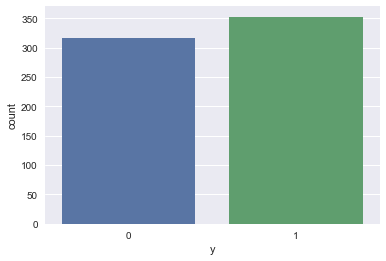

In [12]:
sns.countplot(x='y', data=df_total)
plt.show()

<Figure size 1800x720 with 0 Axes>

total score swarmplot by HomeTeam


<Figure size 1800x720 with 0 Axes>

total score swarmplot by AwayTeam


<Figure size 1800x720 with 0 Axes>

total score swarmplot by Referee


<Figure size 1800x720 with 0 Axes>

total score swarmplot by total_half_score


<Figure size 1800x720 with 0 Axes>

total score swarmplot by TS


<Figure size 1800x720 with 0 Axes>

total score swarmplot by TST


<Figure size 1800x720 with 0 Axes>

total score swarmplot by corners


<Figure size 1800x720 with 0 Axes>

total score swarmplot by yellows


<Figure size 1800x720 with 0 Axes>

total score swarmplot by reds


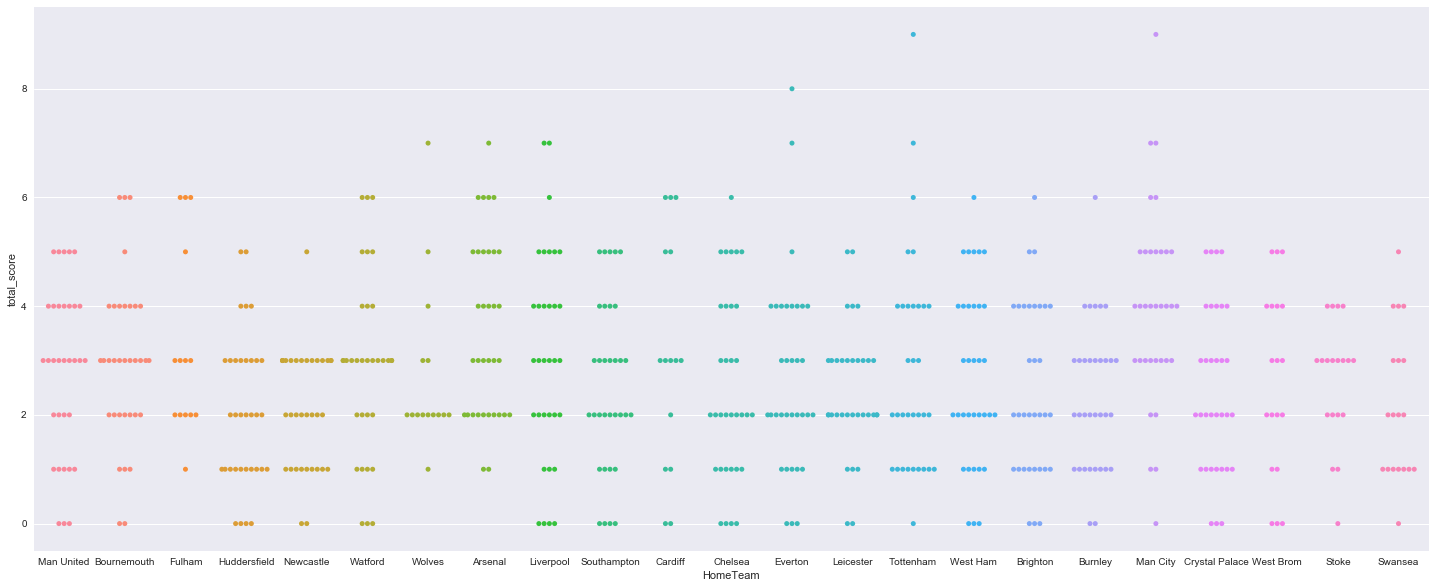

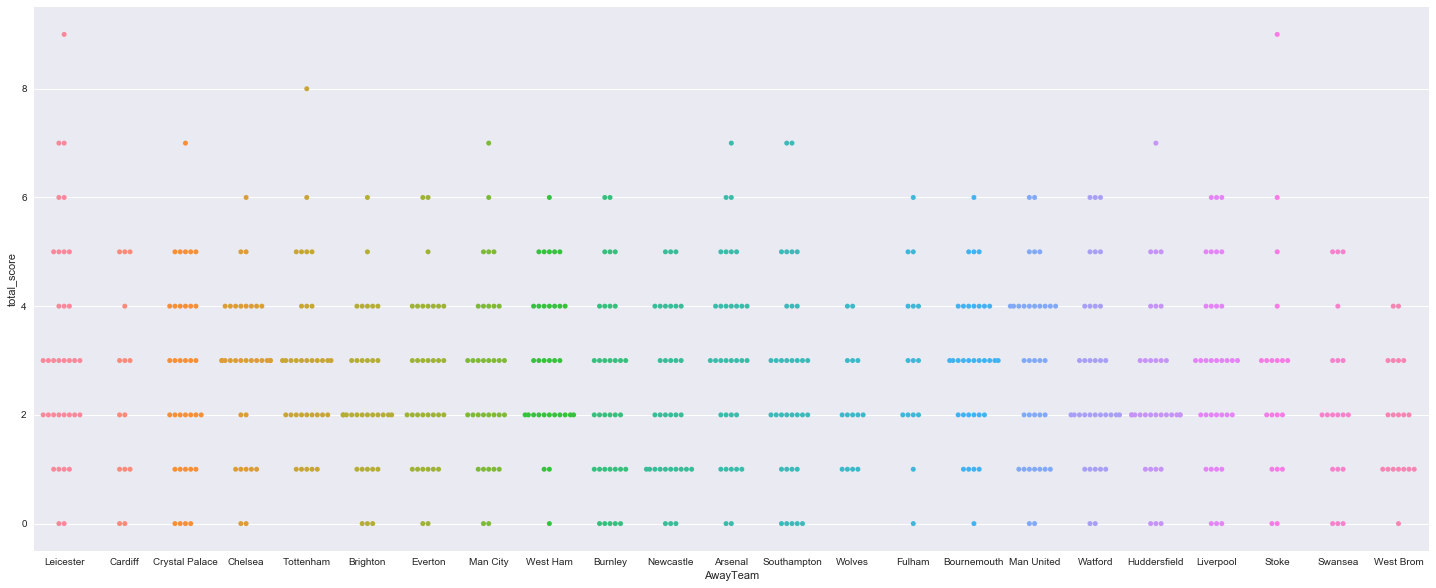

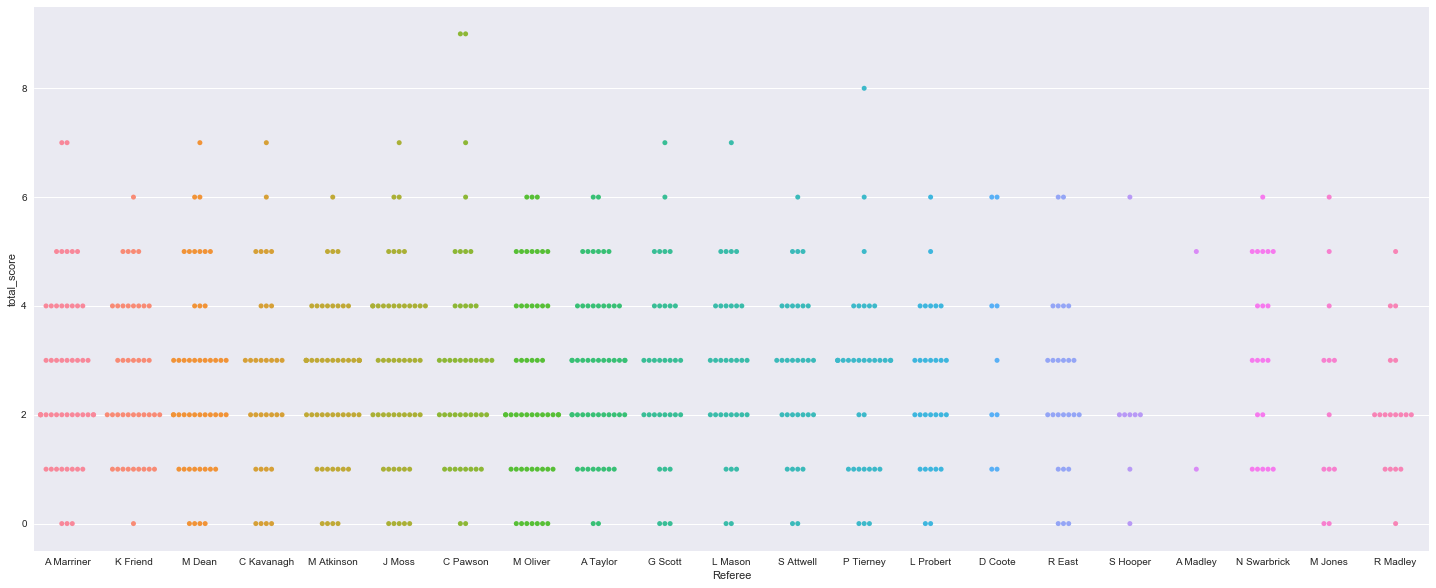

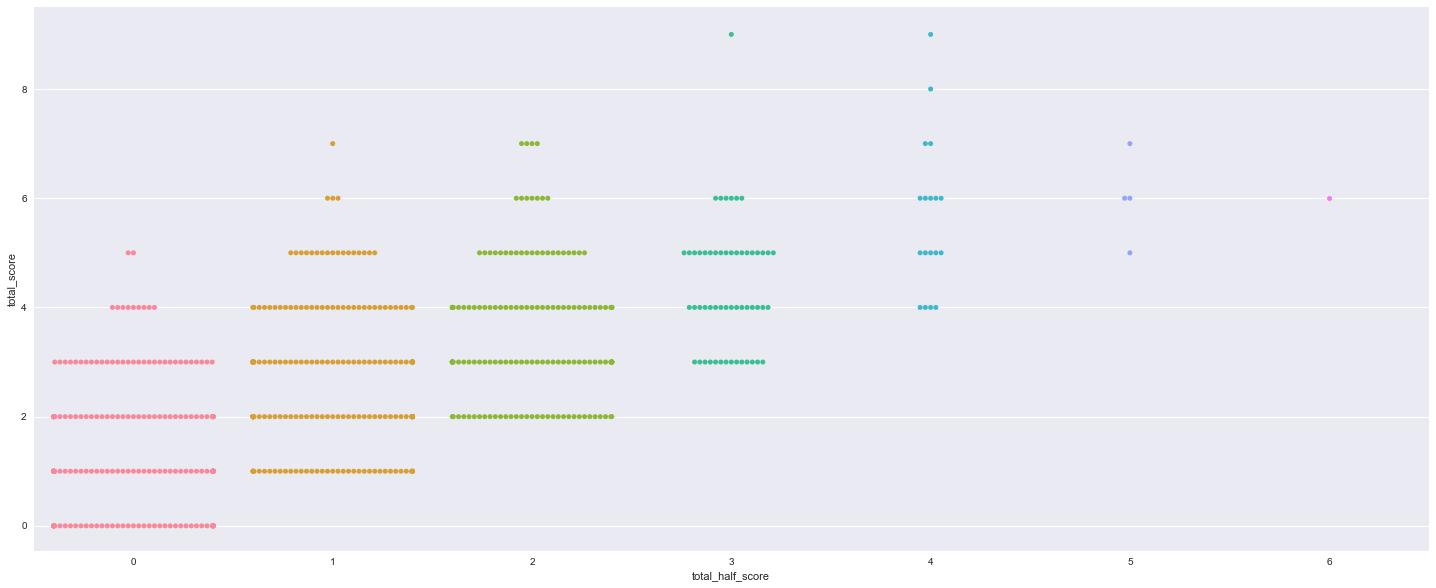

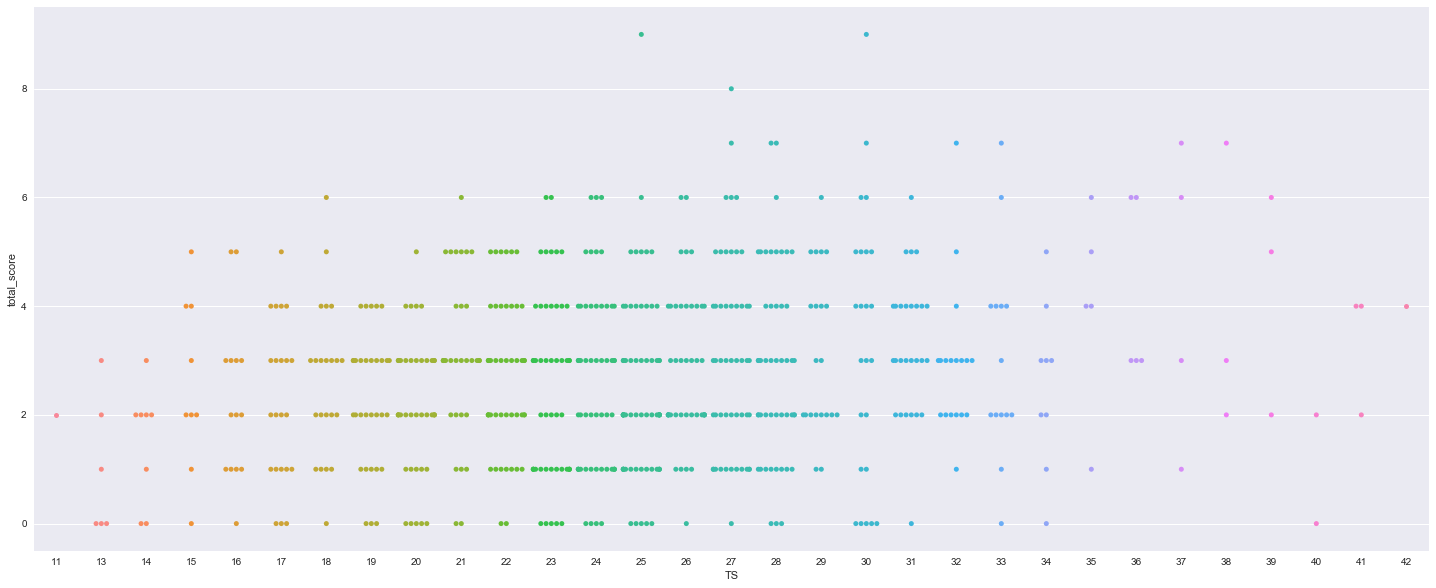

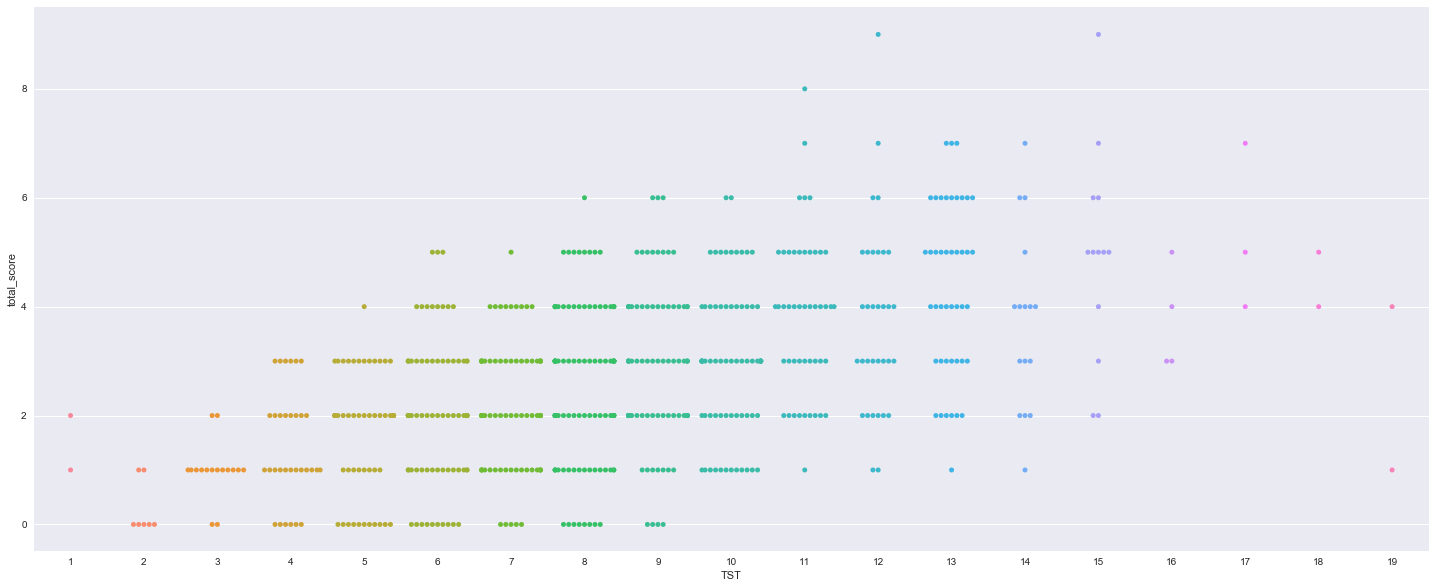

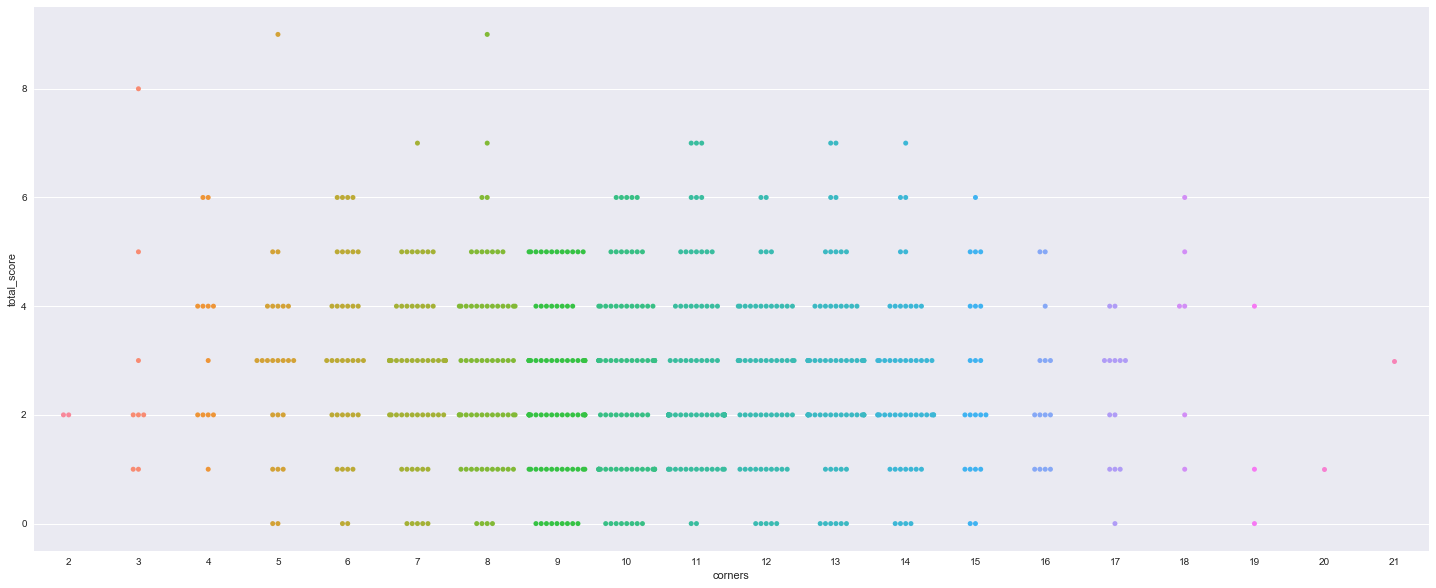

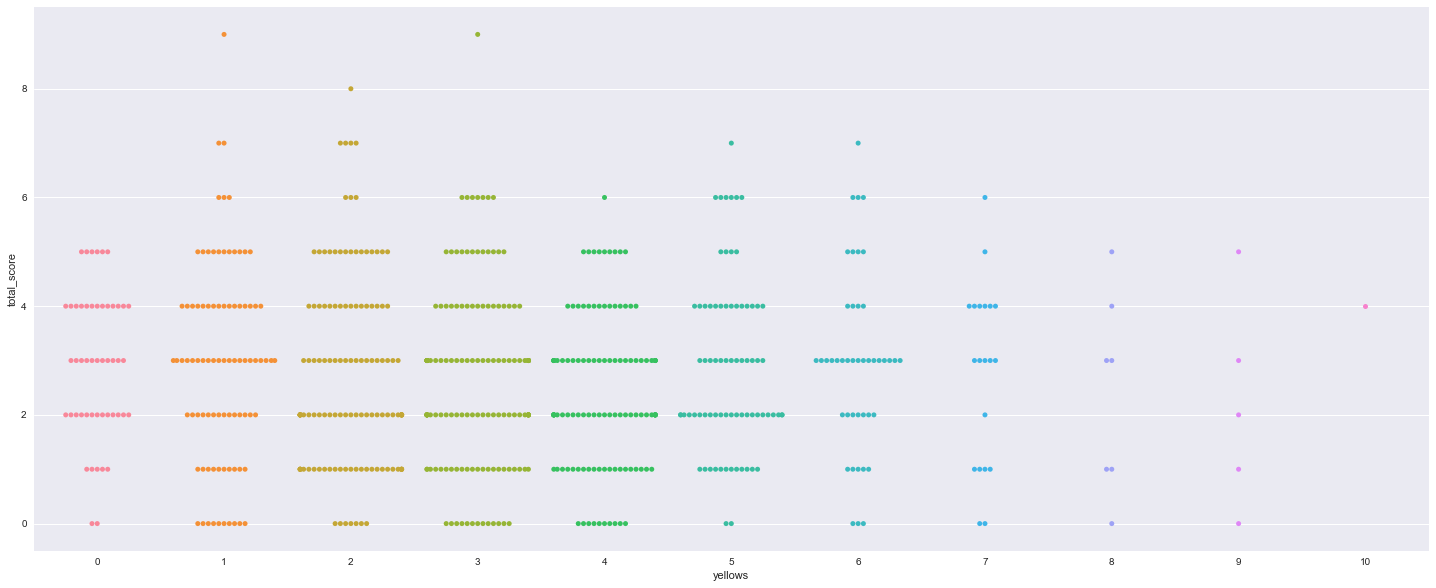

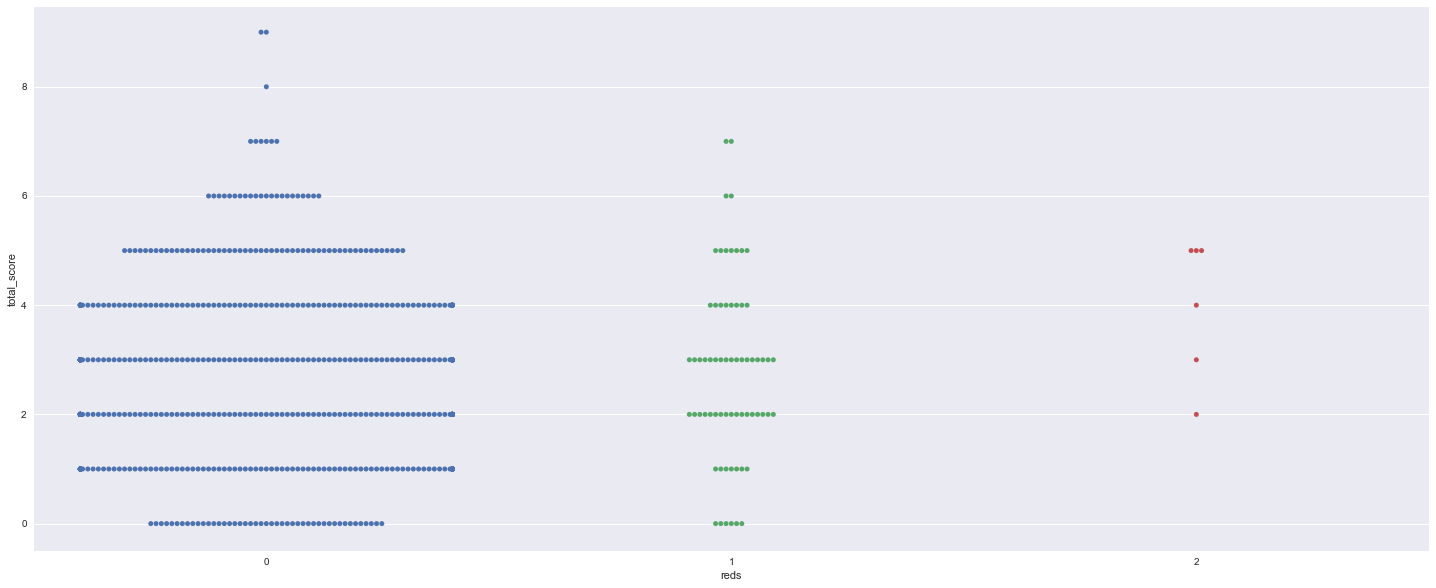

In [13]:
# now lets look at total score swarm plots by various features
swarm_list = ['HomeTeam', 'AwayTeam', 'Referee','total_half_score', 
              'TS', 'TST', 'corners', 'yellows', 'reds']

for x in swarm_list:
    plt.figure(figsize=(25,10))
    print('total score swarmplot by ' + x)
    sns.swarmplot(df_total[x], df_total.total_score)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

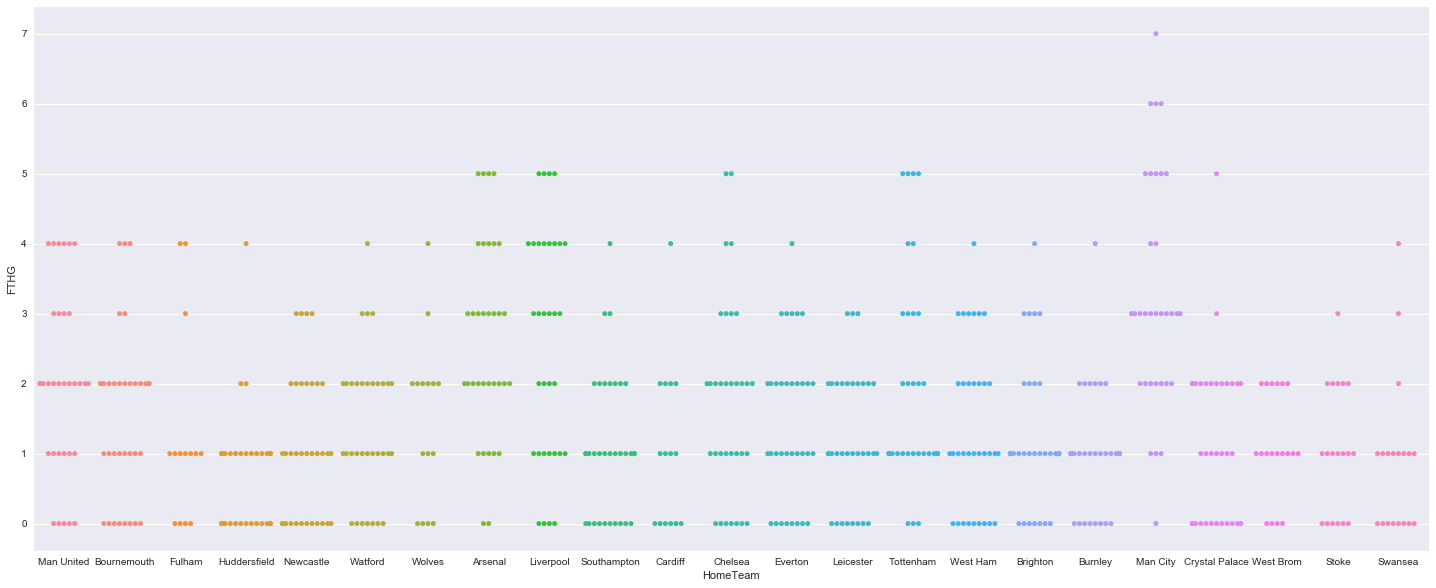

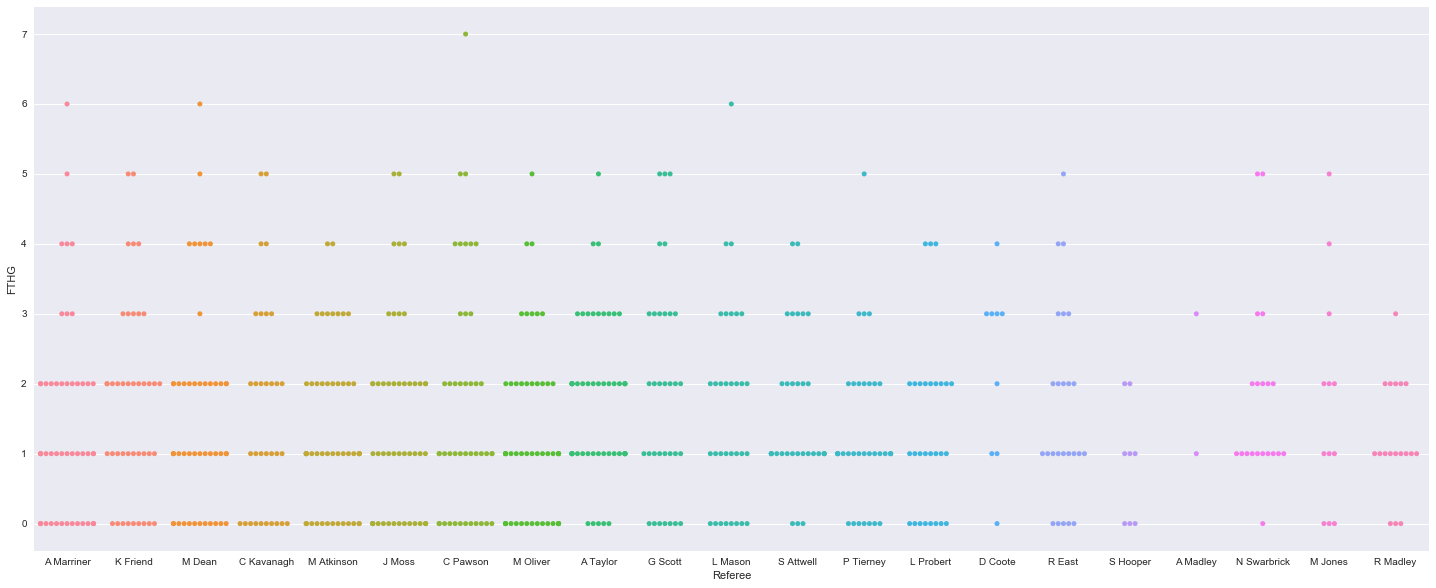

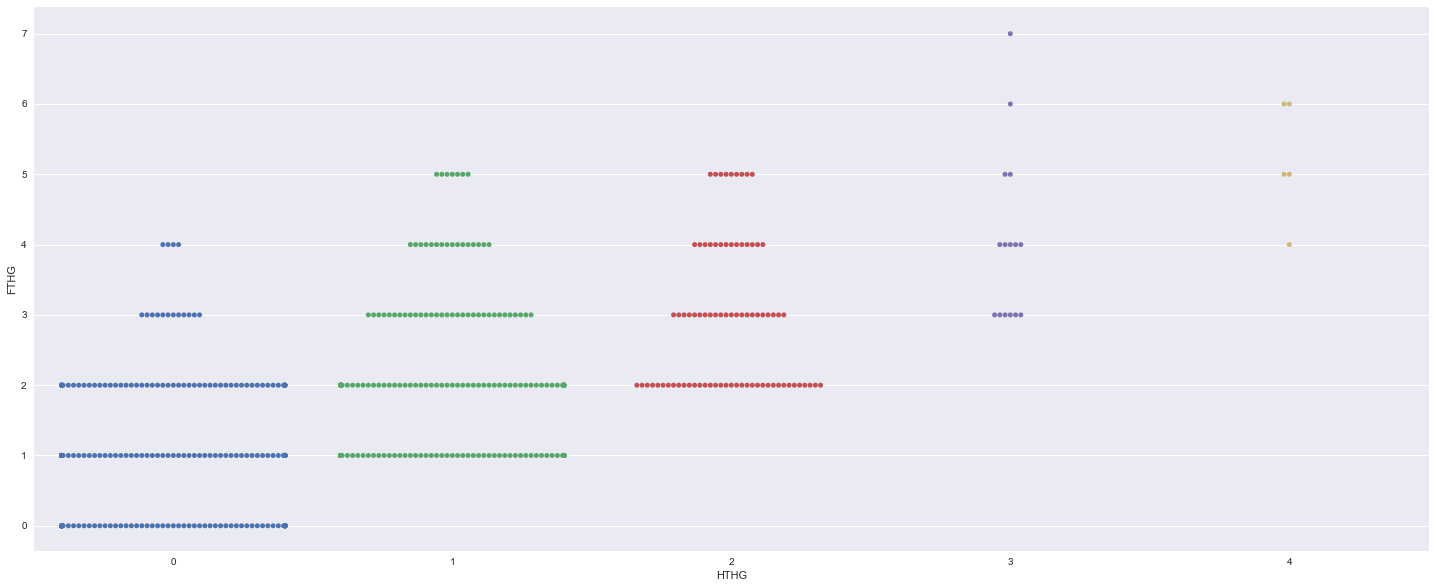

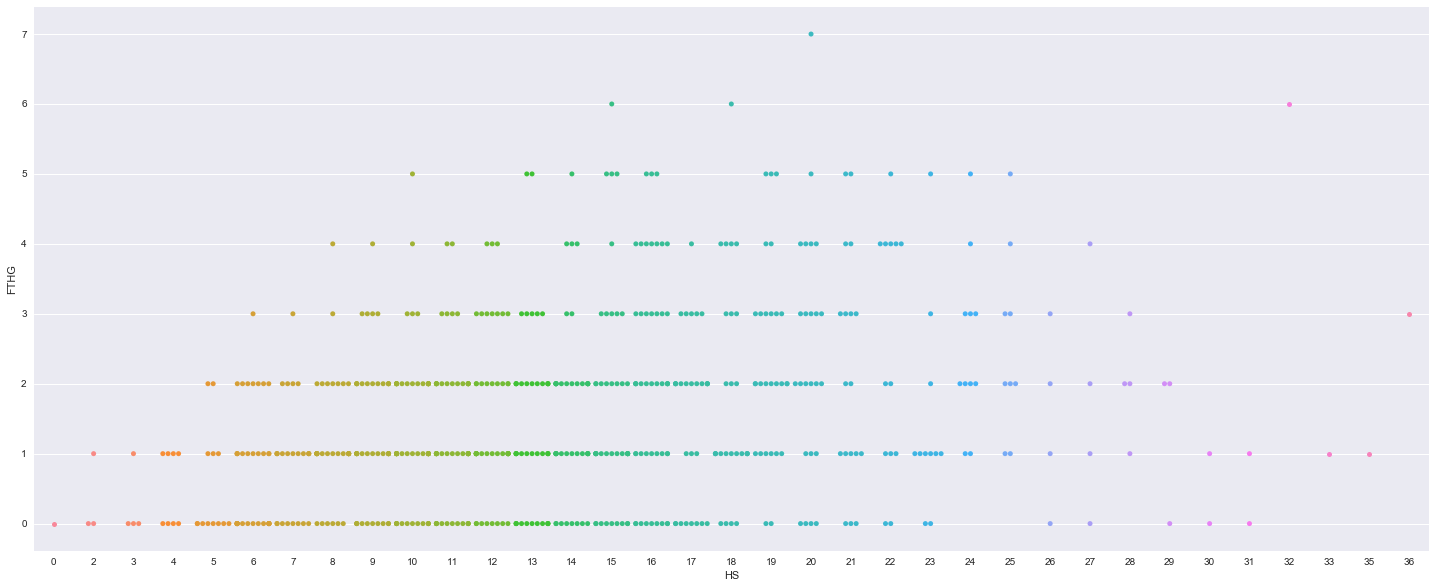

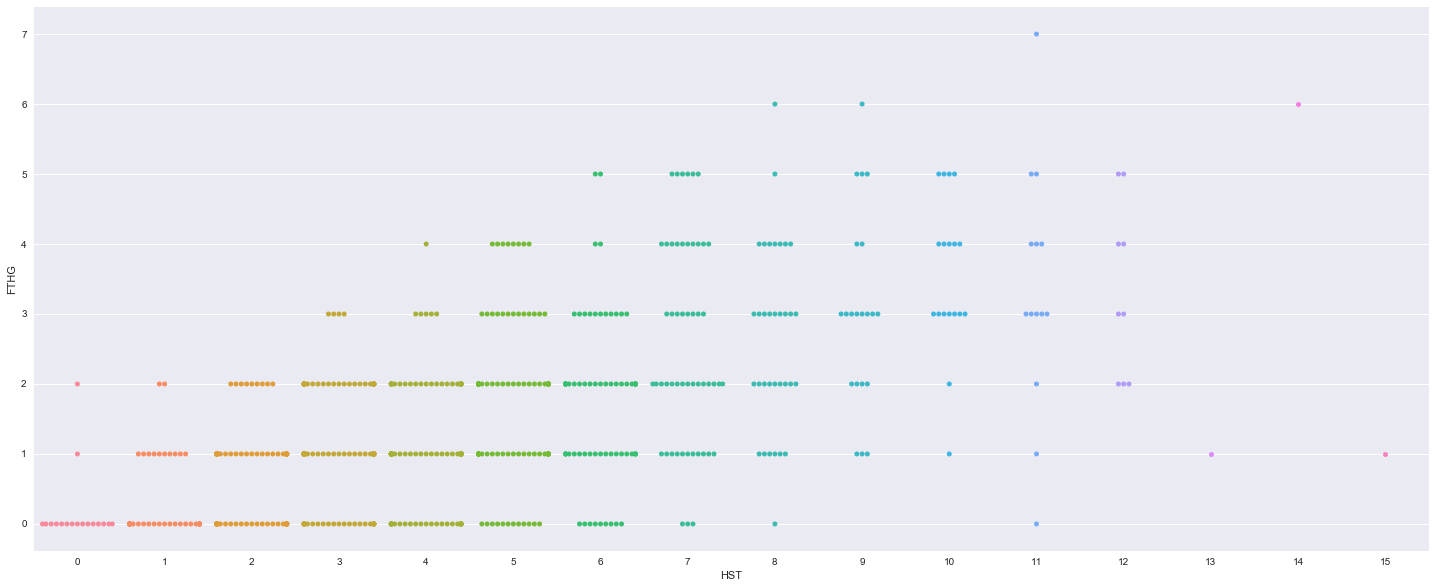

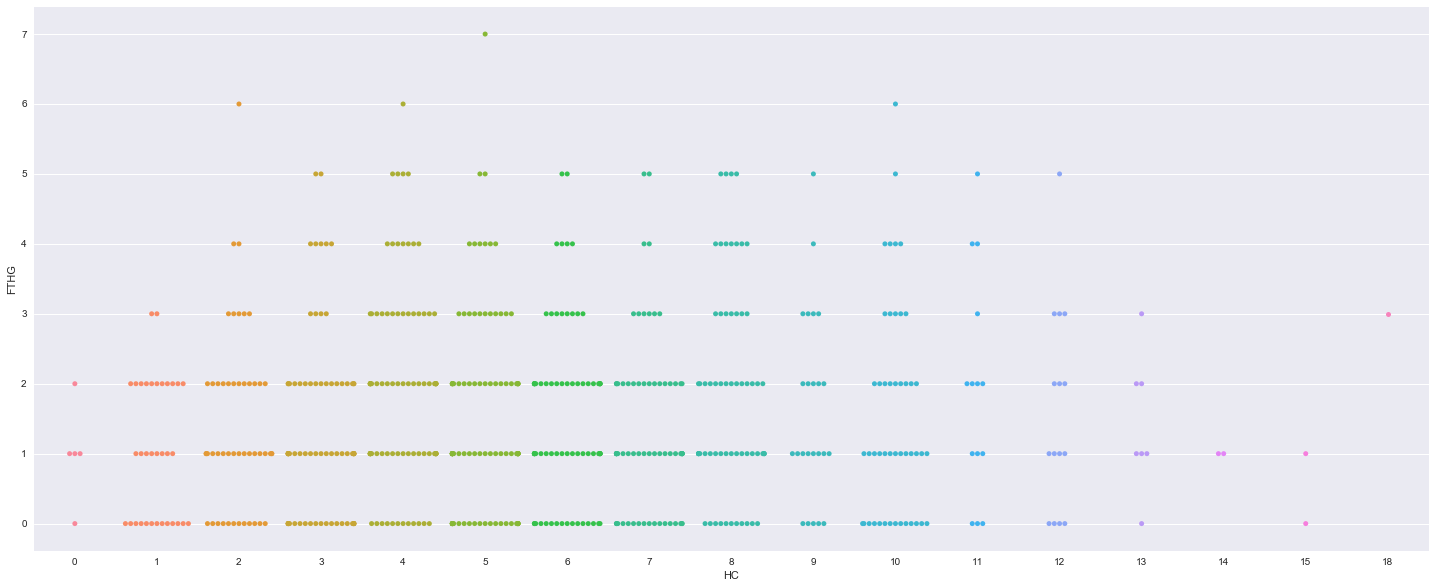

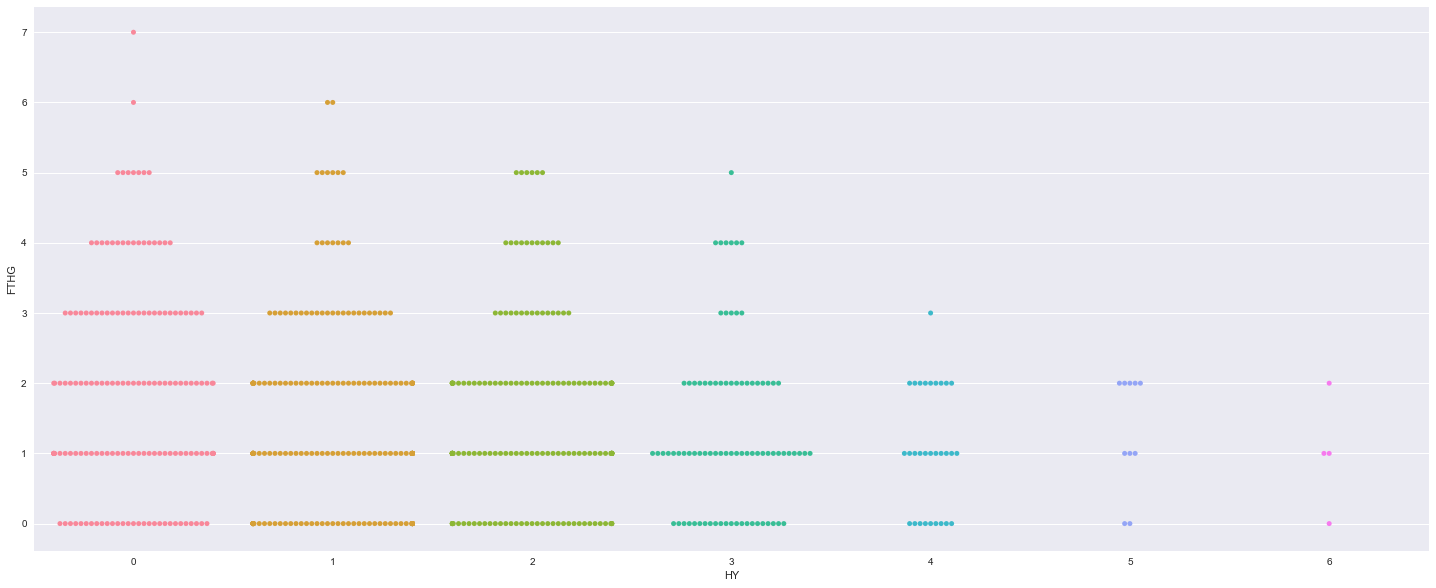

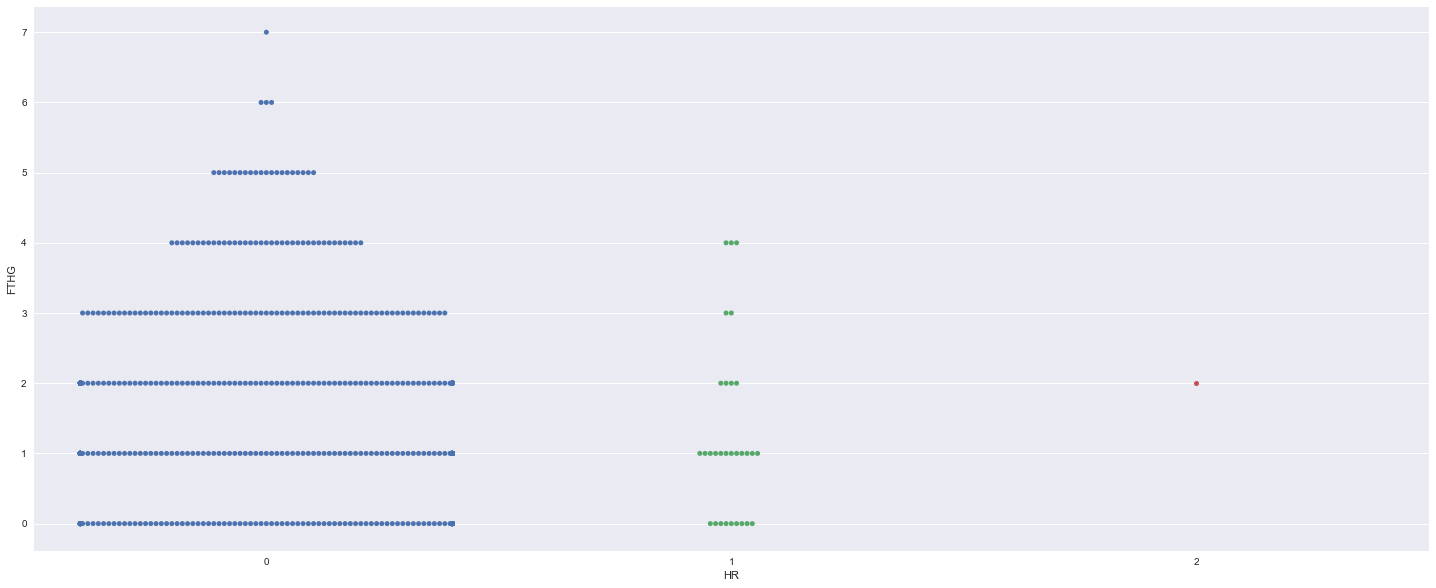

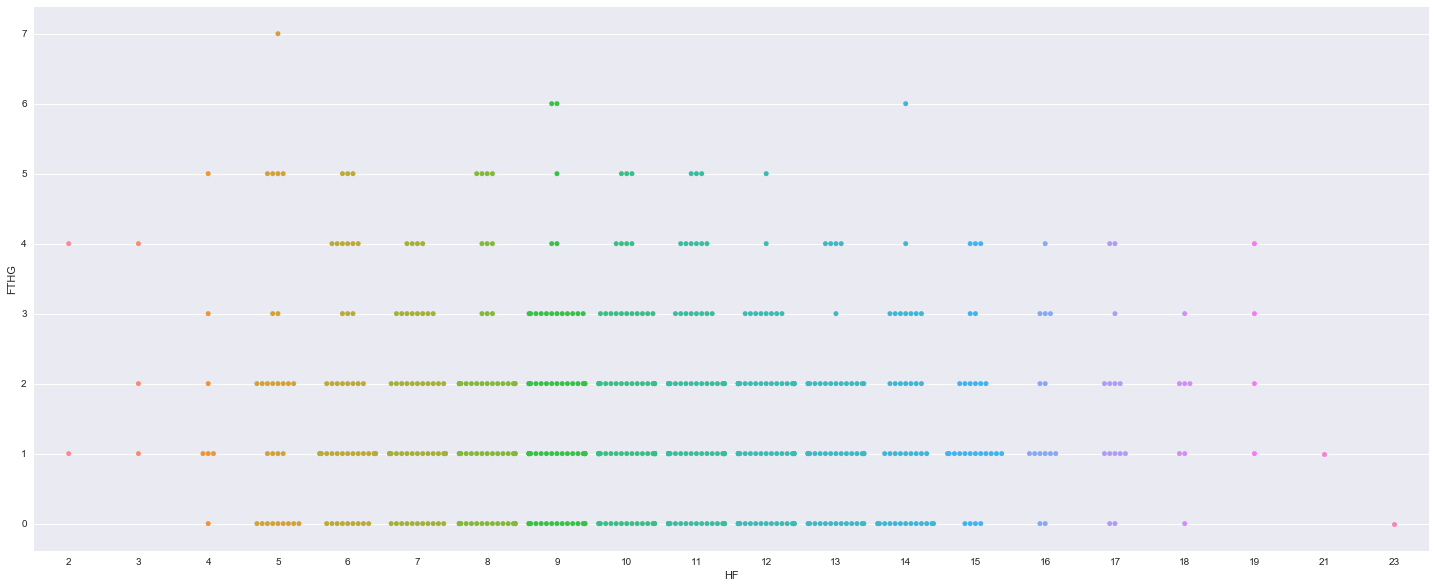

In [14]:
# now lets look at home score swarm plots by home features
total_list = ['HomeTeam', 'Referee','HTHG', 'HS', 
              'HST', 'HC', 'HY', 'HR', 'HF']

for x in total_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.FTHG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

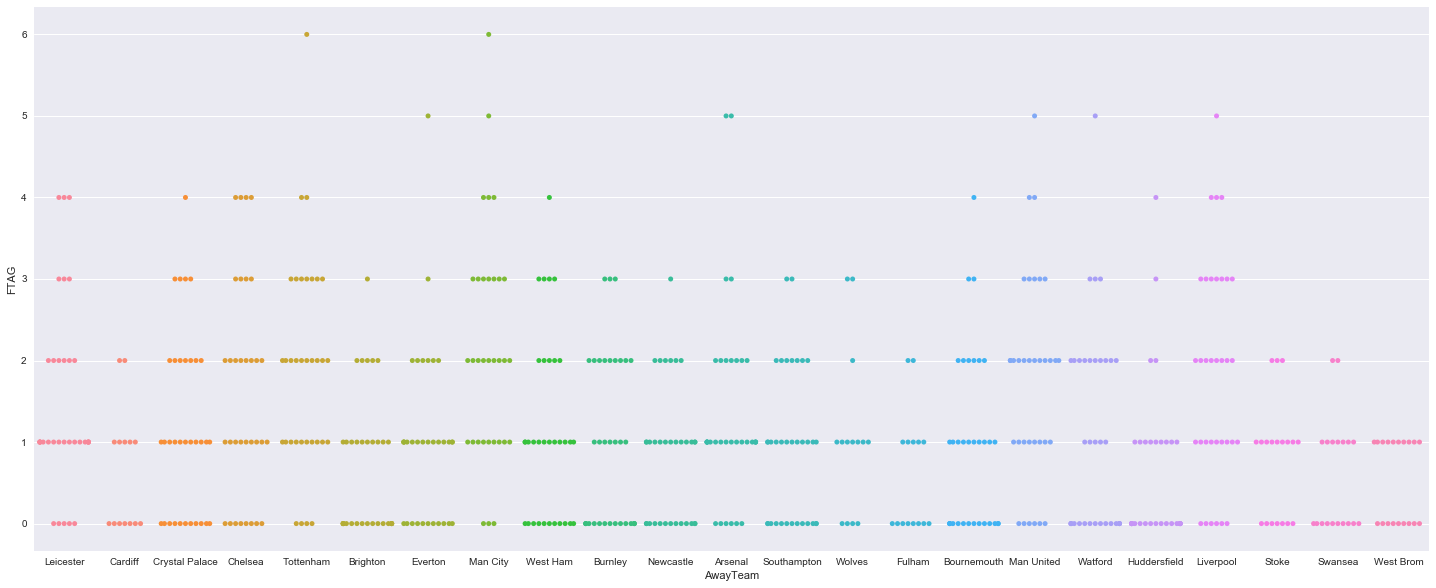

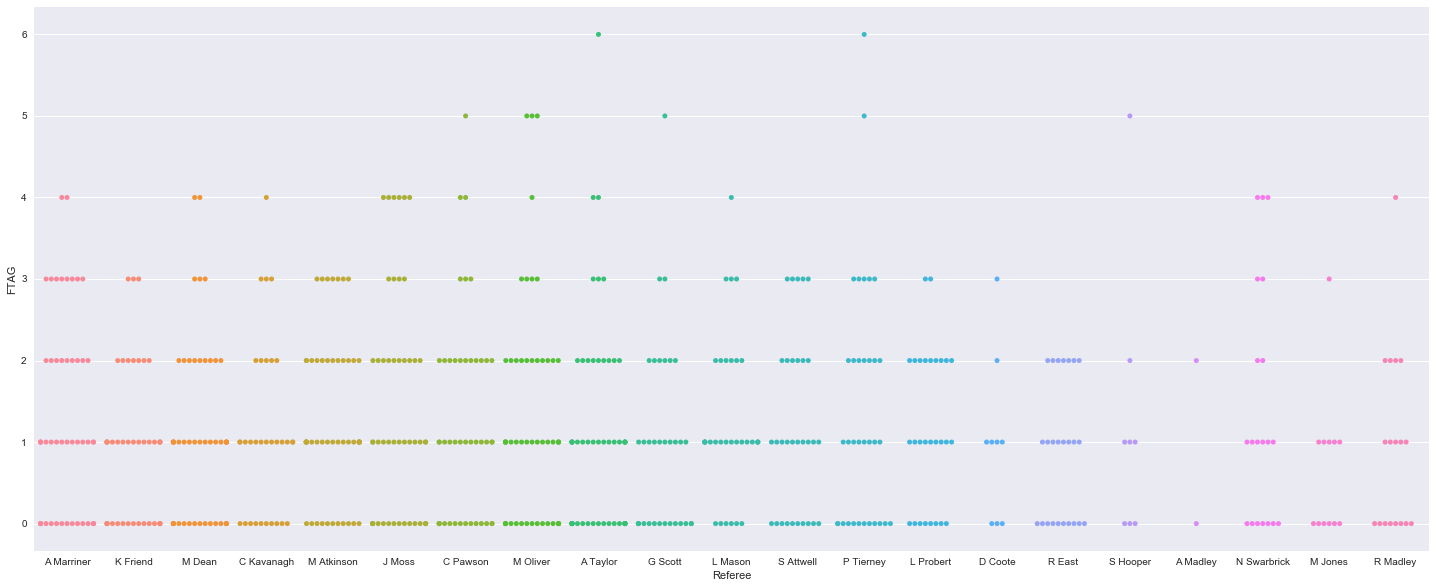

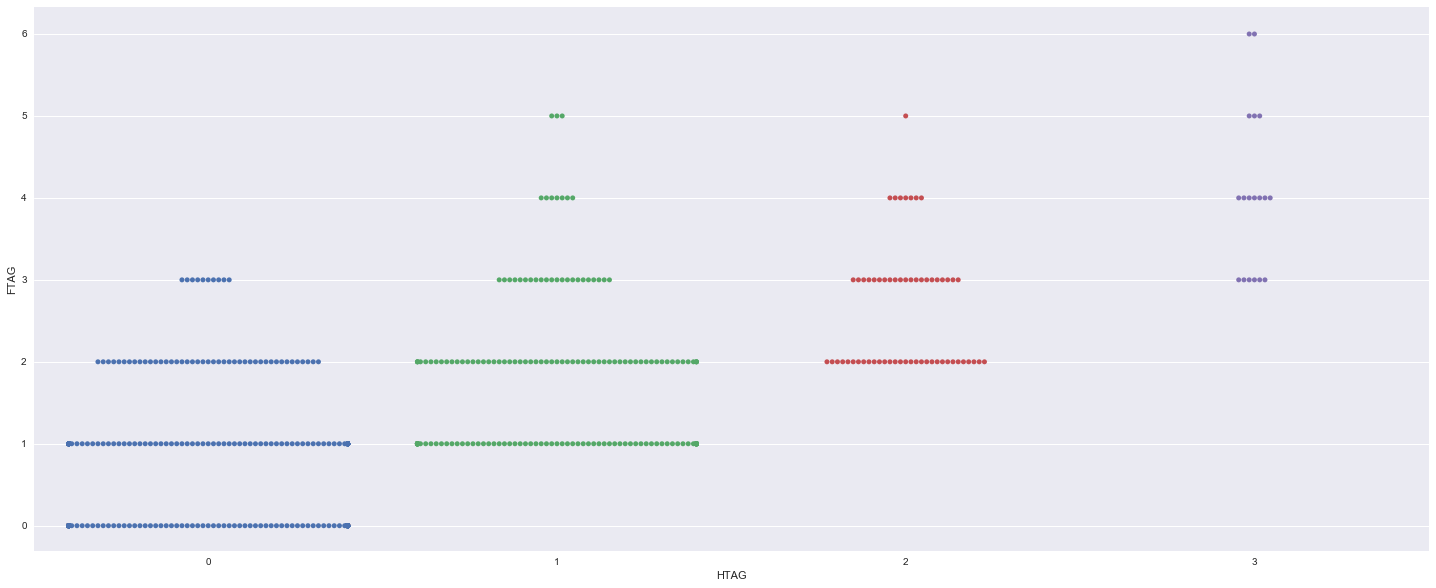

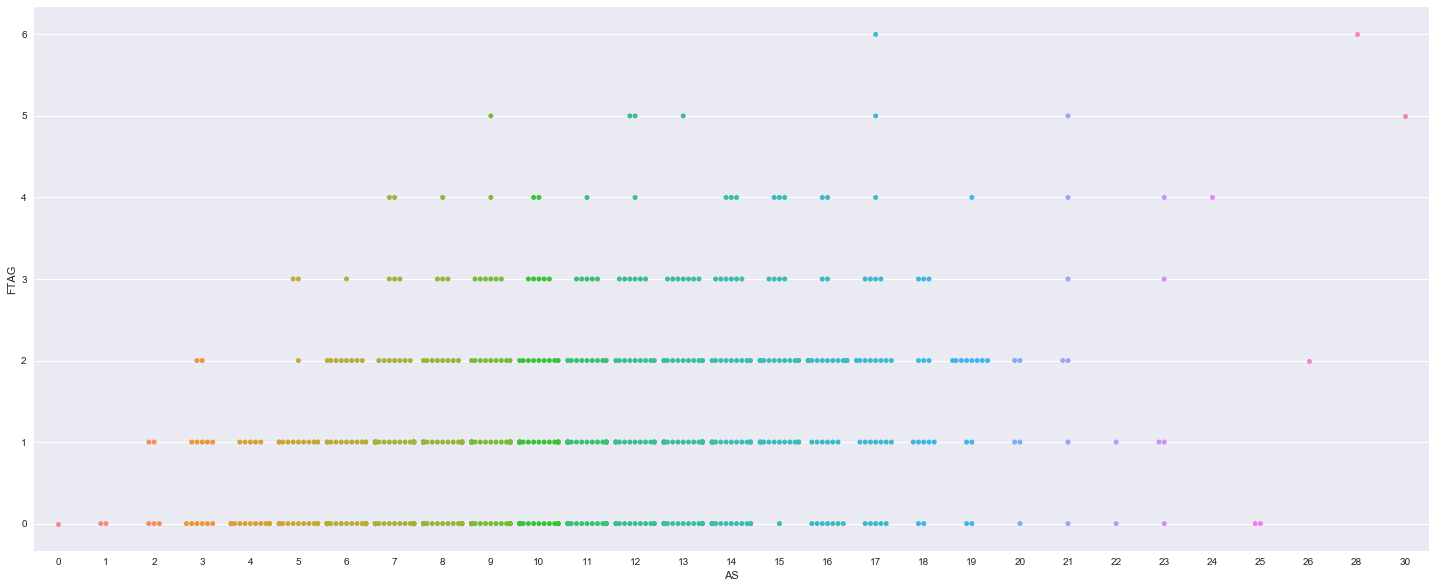

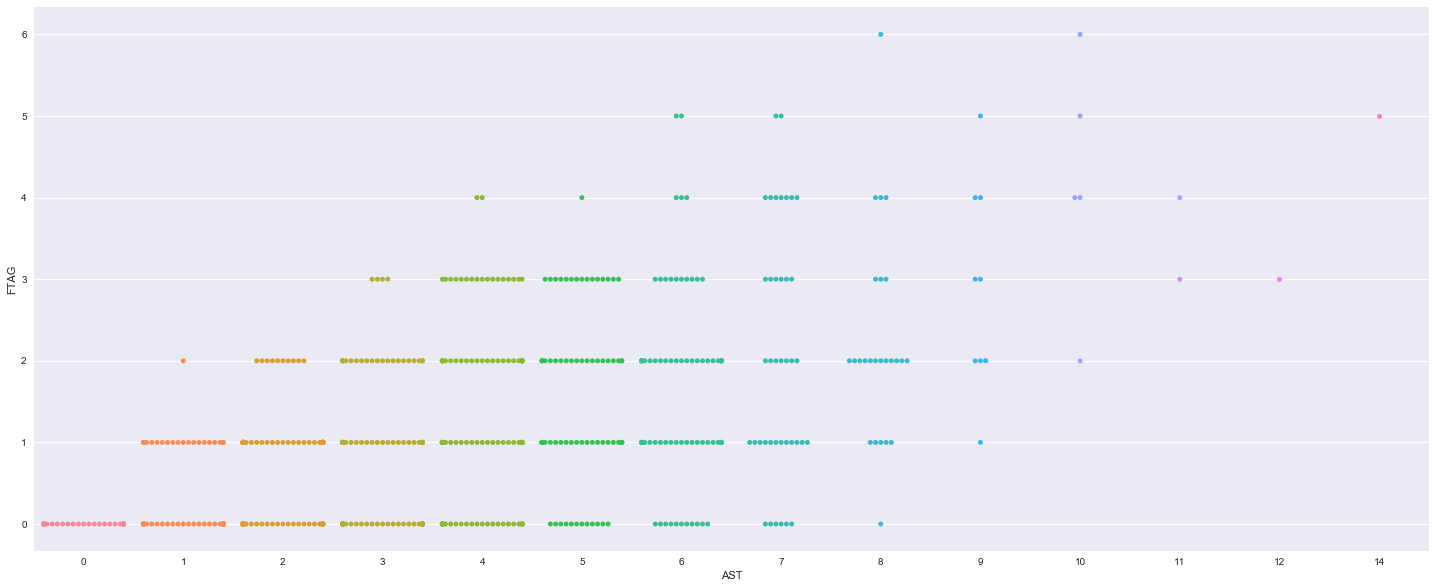

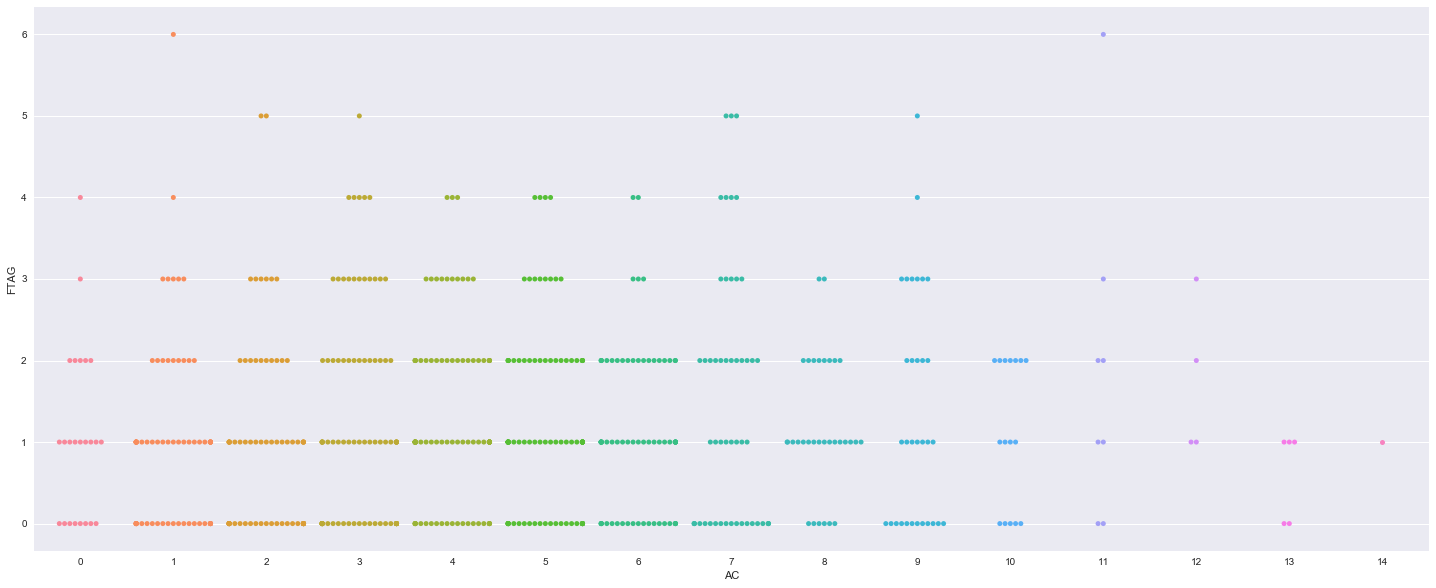

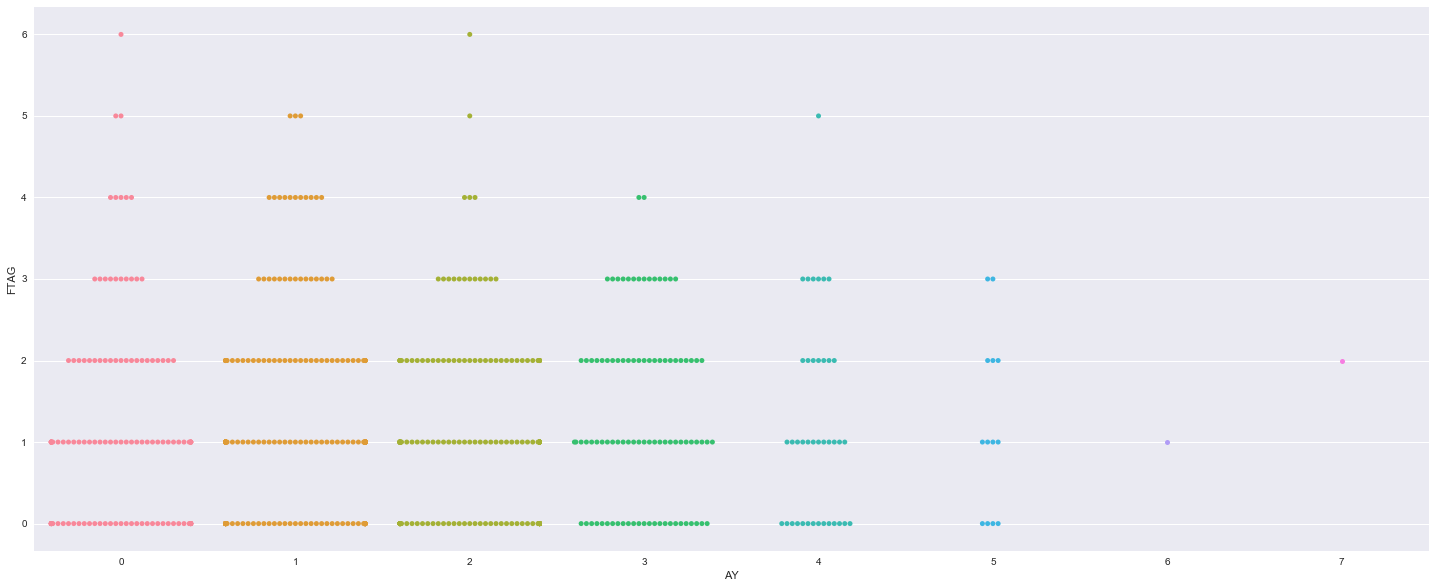

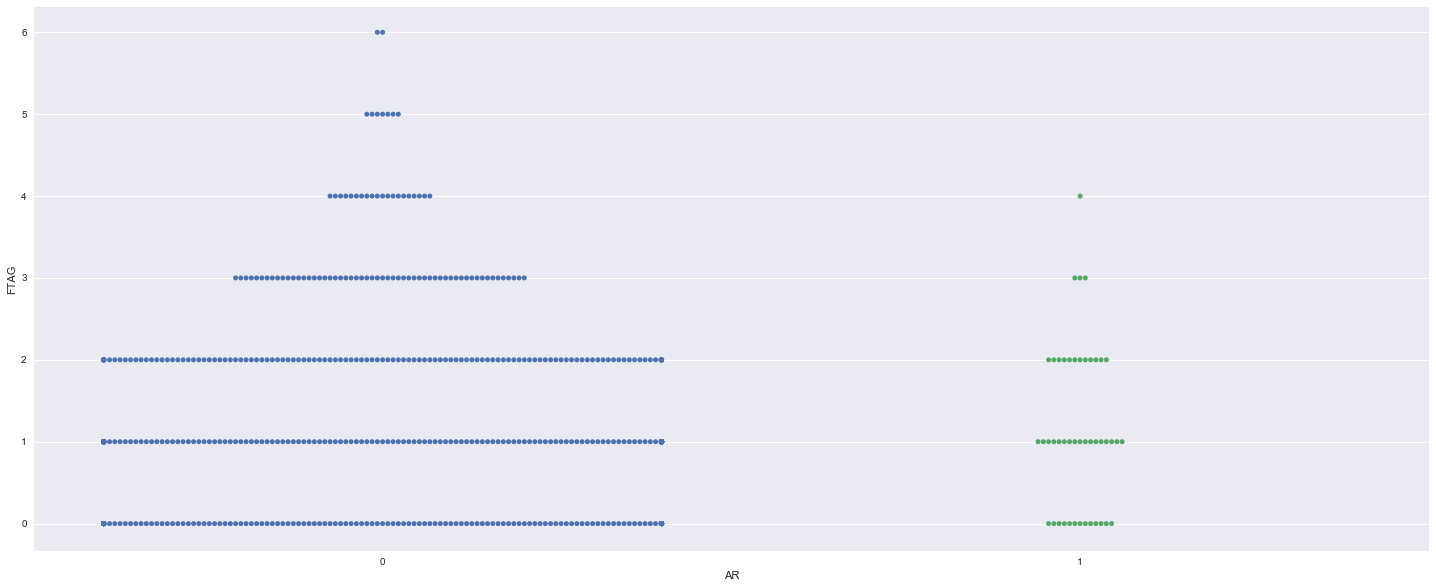

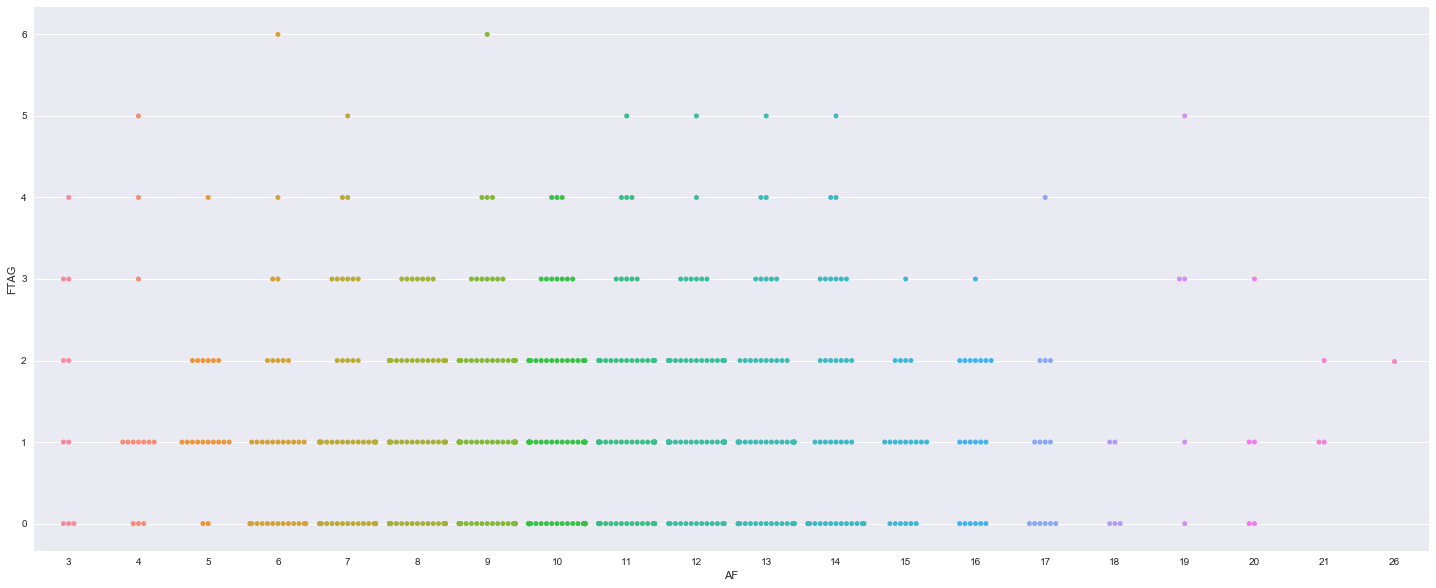

In [15]:
# now lets look at away score swarm plots by away features
away_list = ['AwayTeam', 'Referee','HTAG', 'AS', 
              'AST', 'AC', 'AY', 'AR', 'AF']

for x in away_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.FTAG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

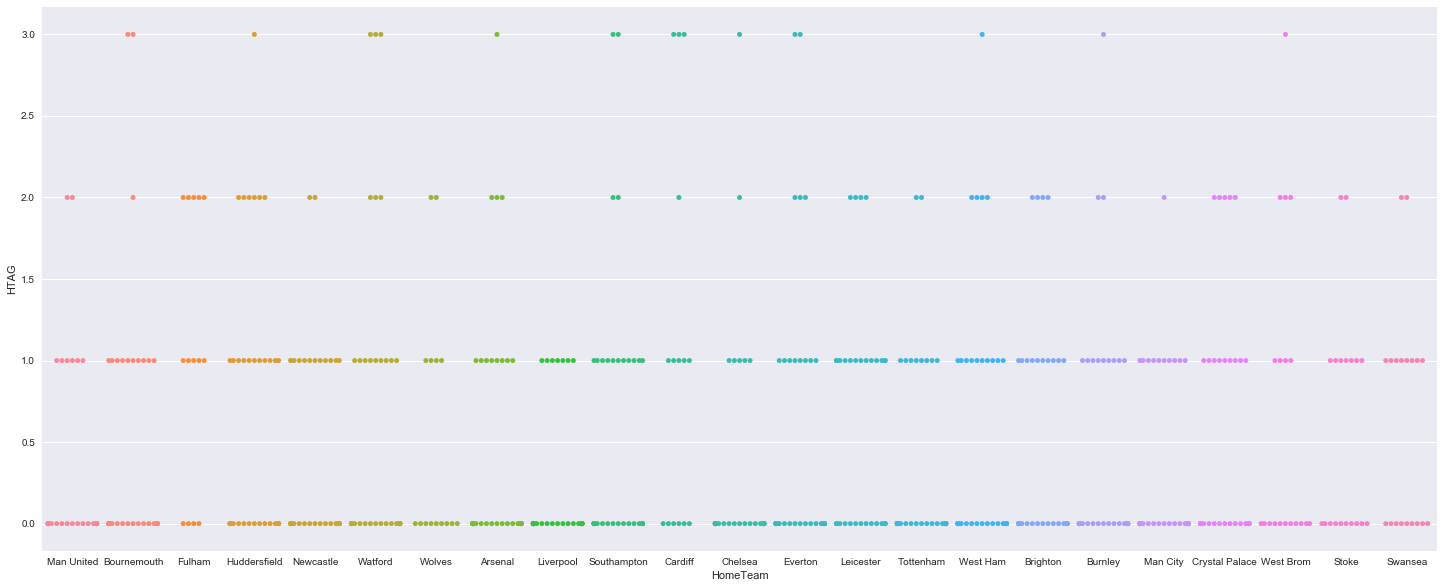

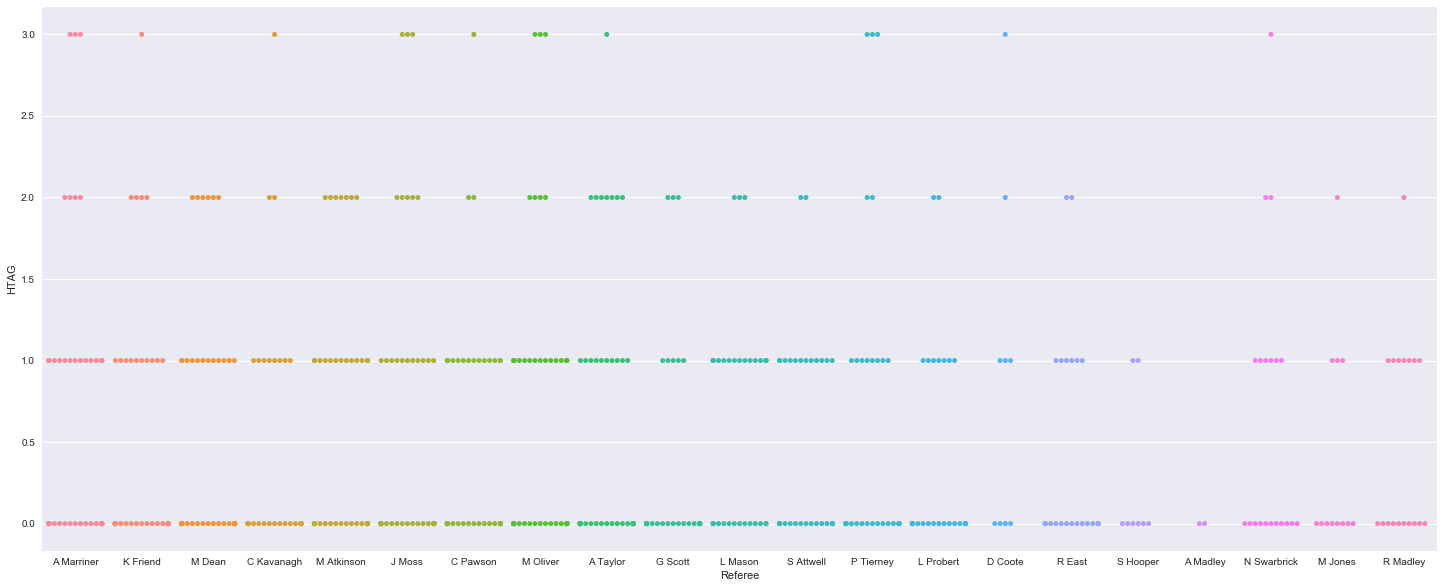

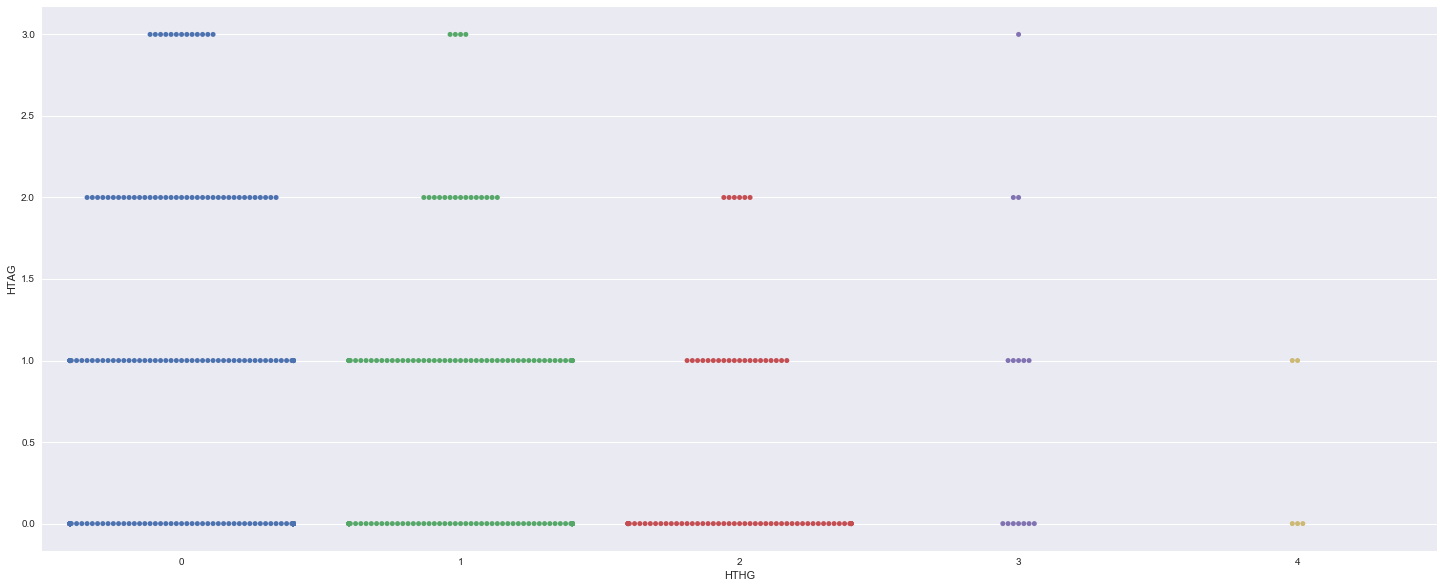

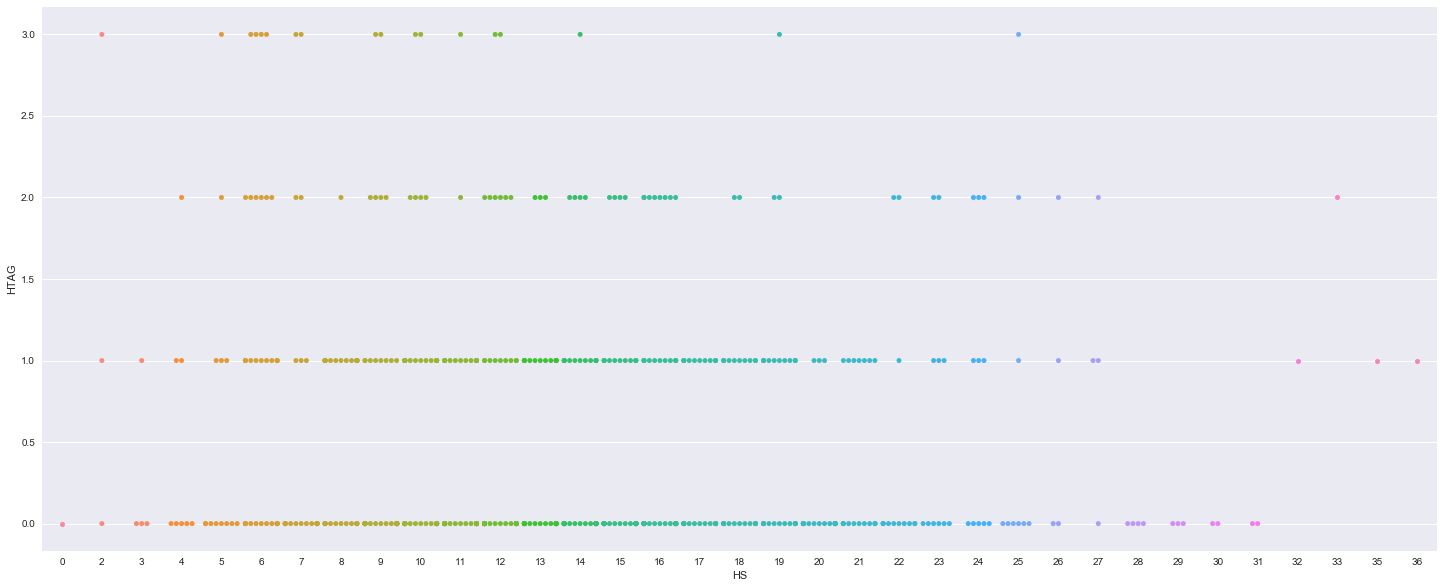

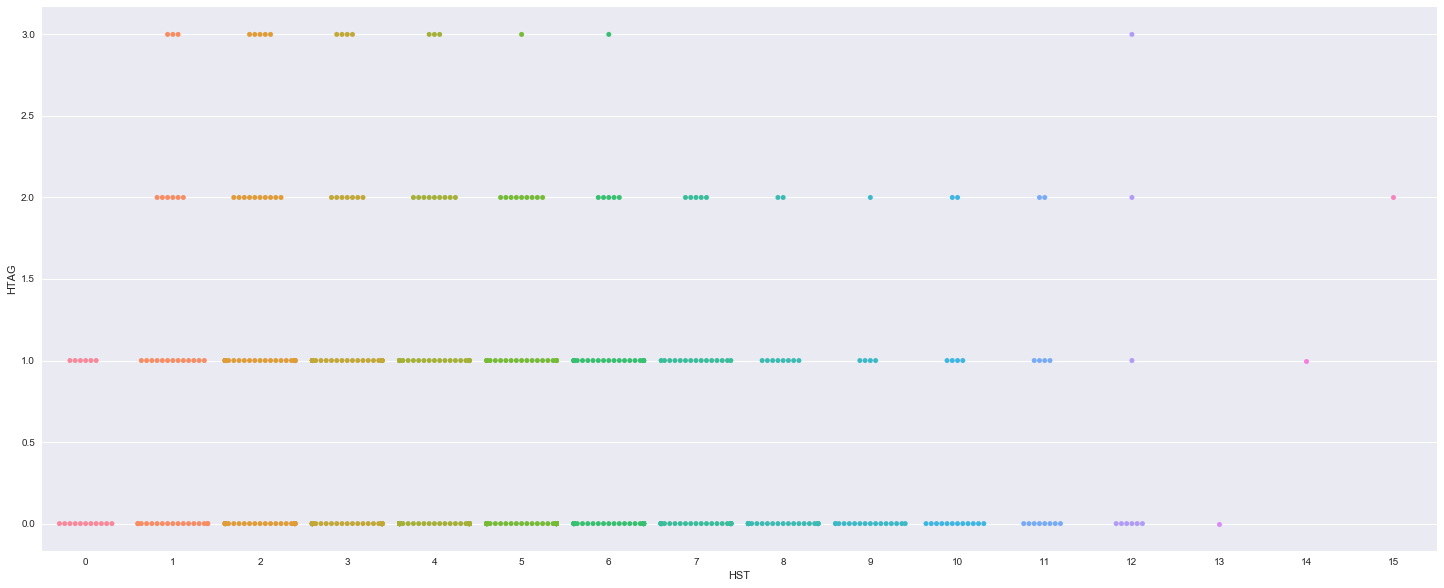

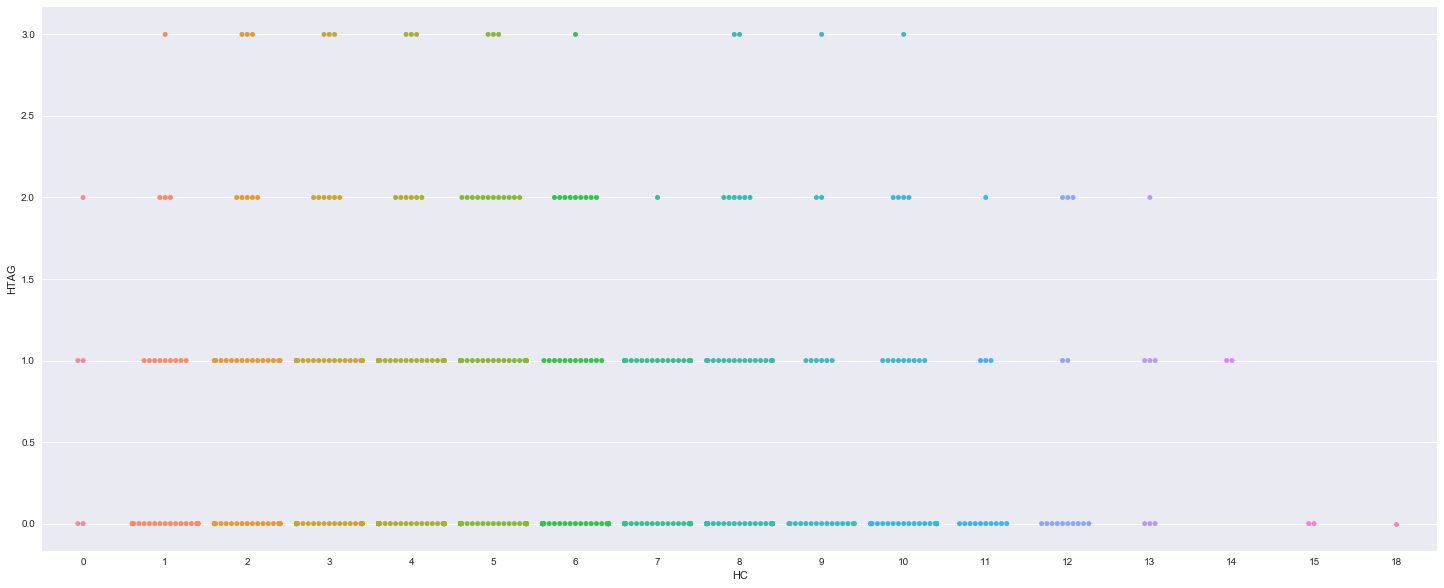

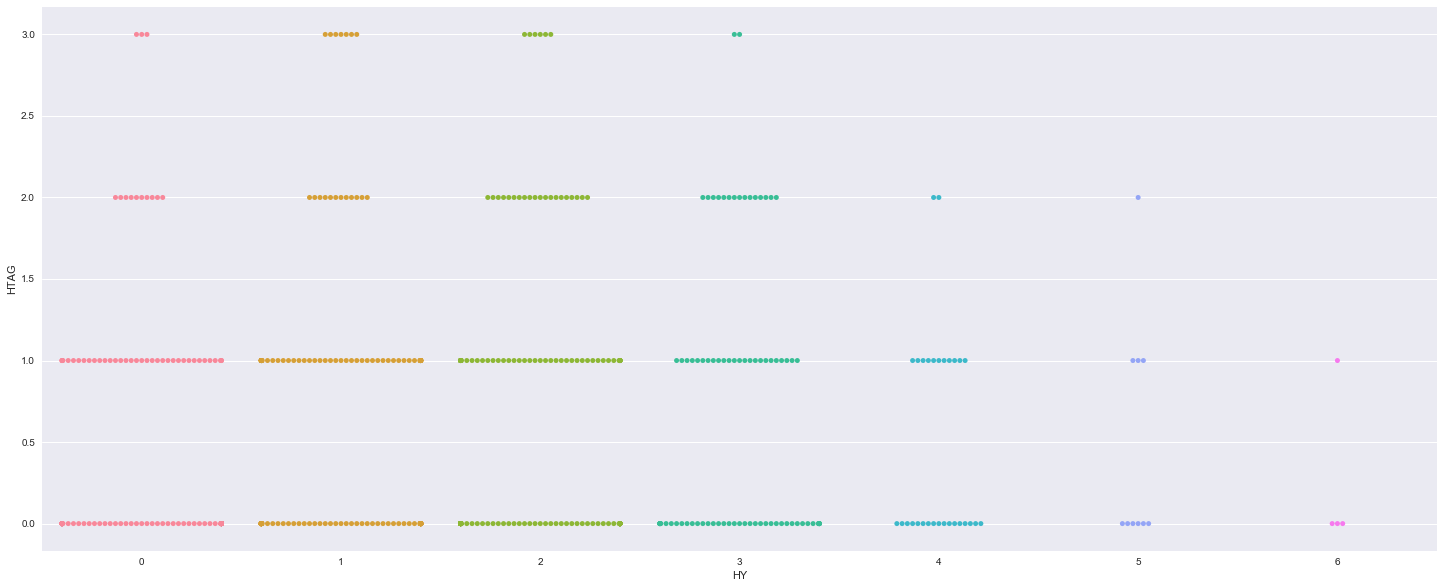

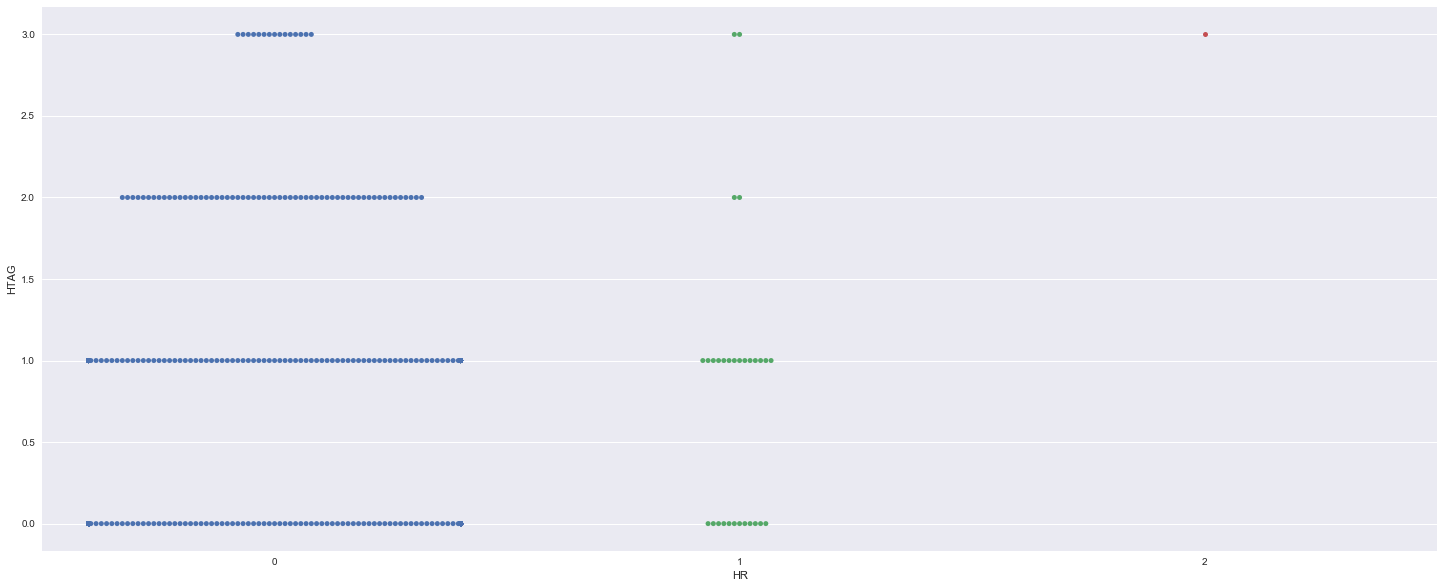

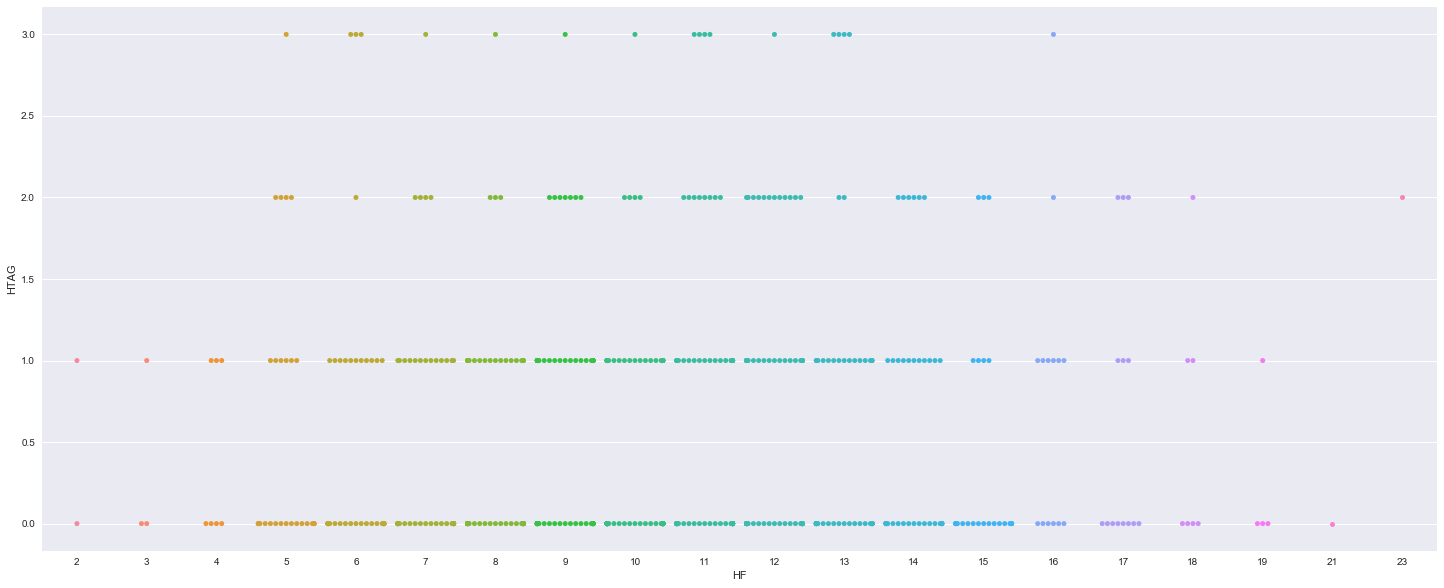

In [16]:
# now lets look at total score swarm plots by home features
home_list = ['HomeTeam', 'Referee','HTHG', 'HS', 
              'HST', 'HC', 'HY', 'HR', 'HF']

for x in home_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.HTAG)

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

<Figure size 1800x720 with 0 Axes>

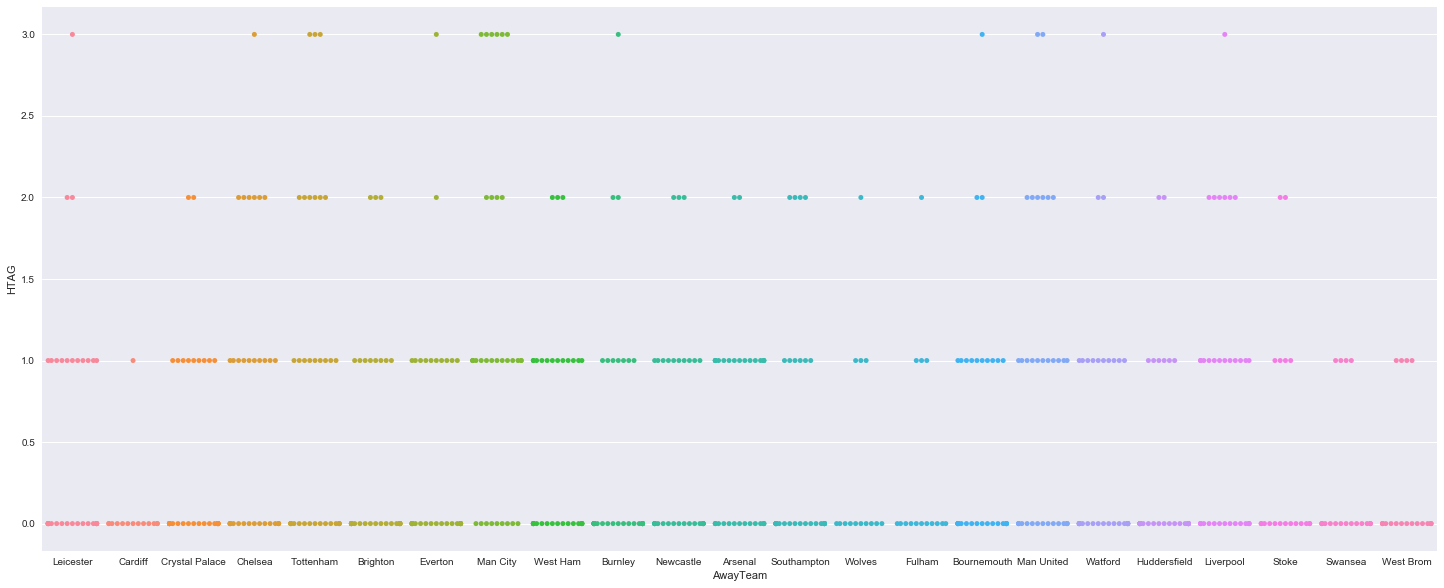

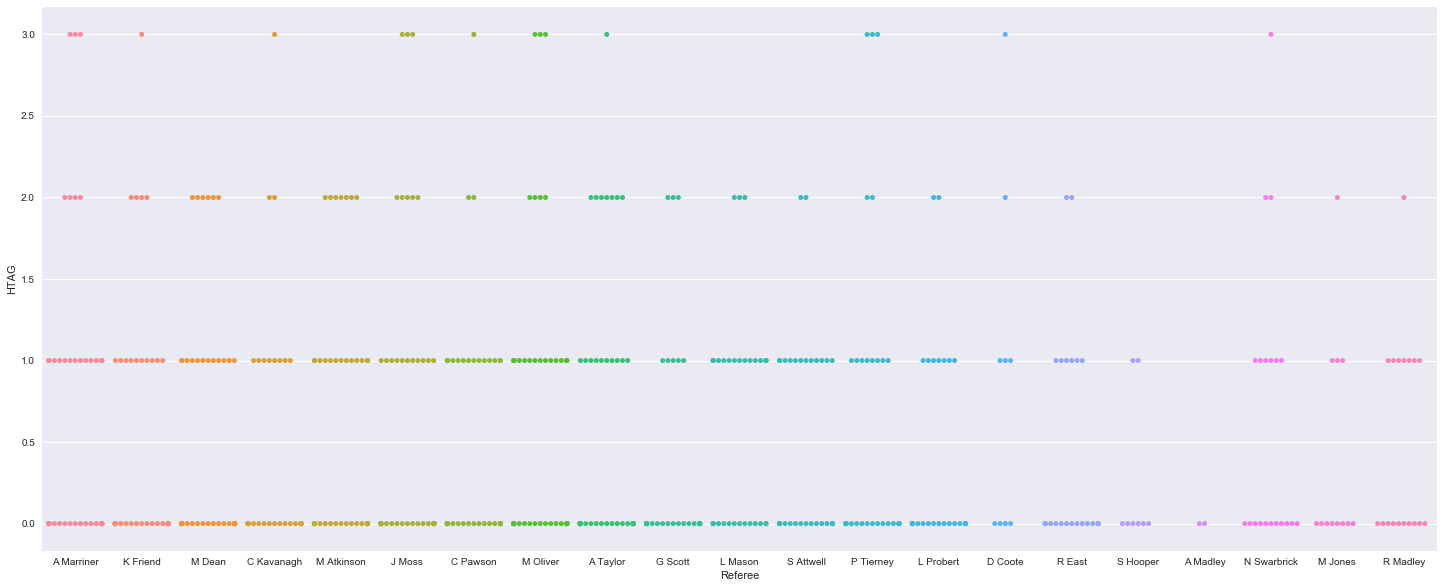

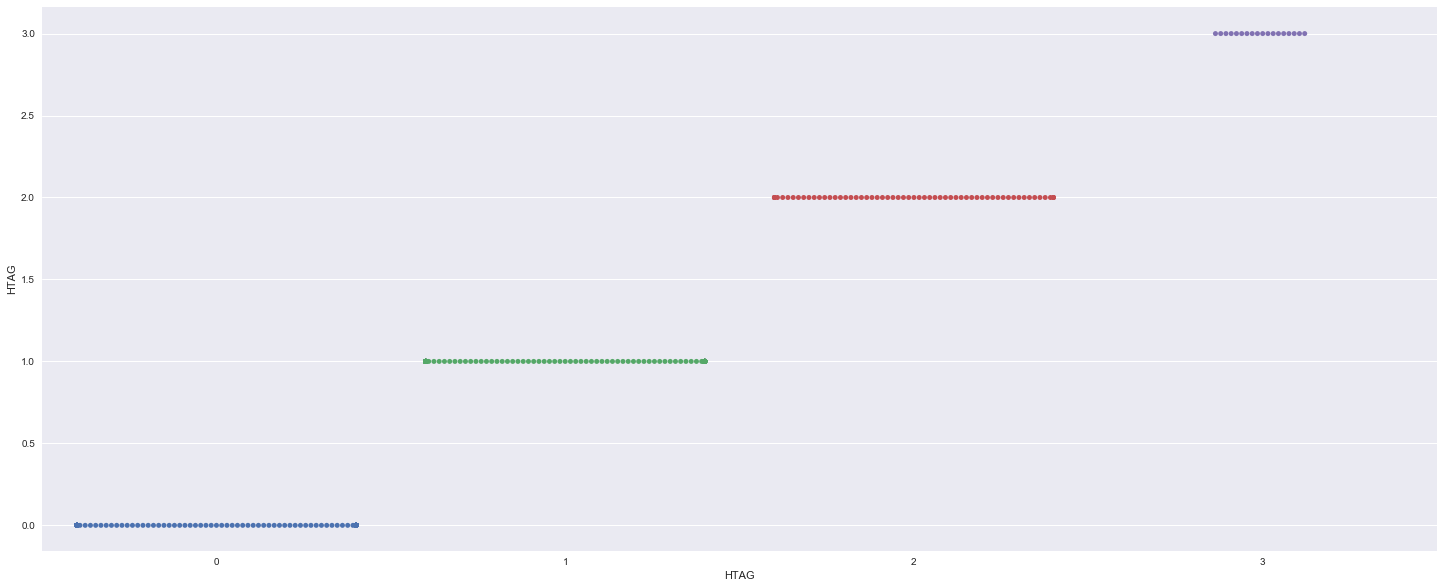

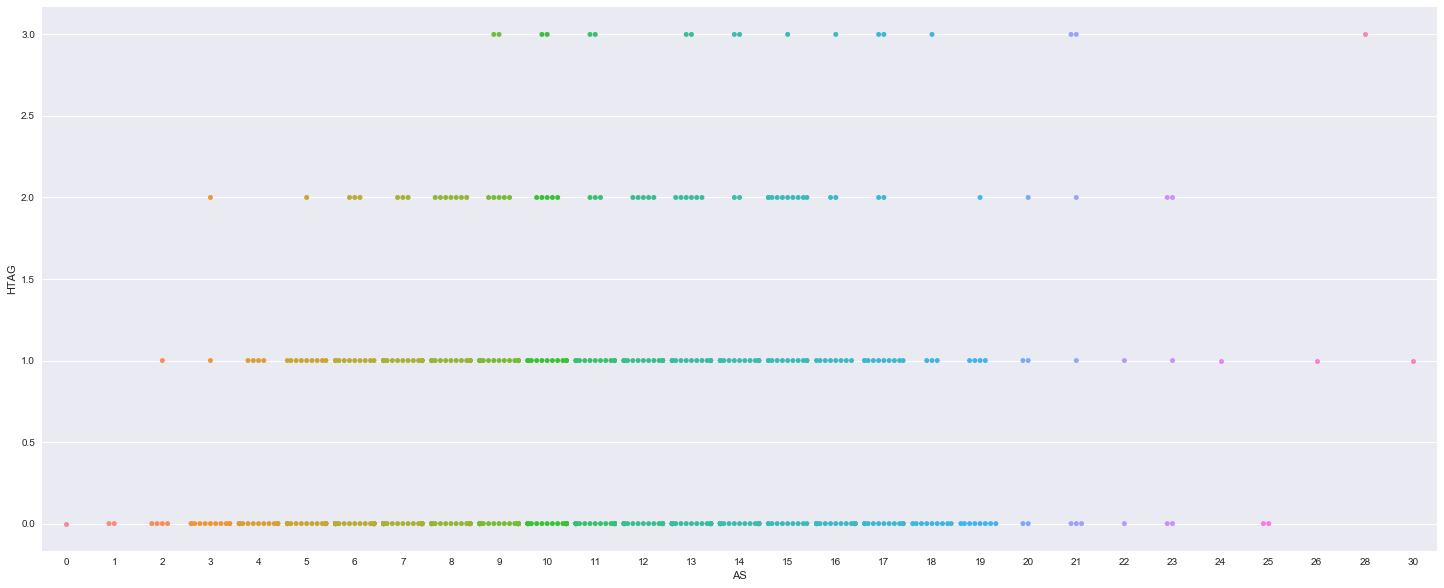

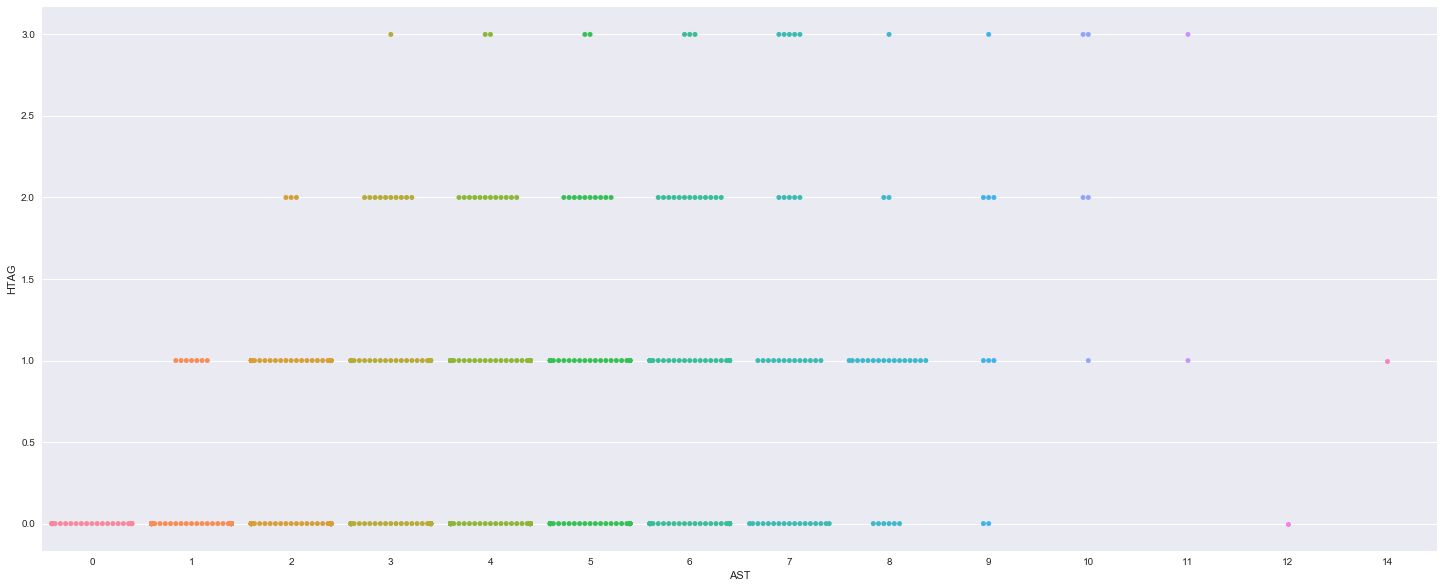

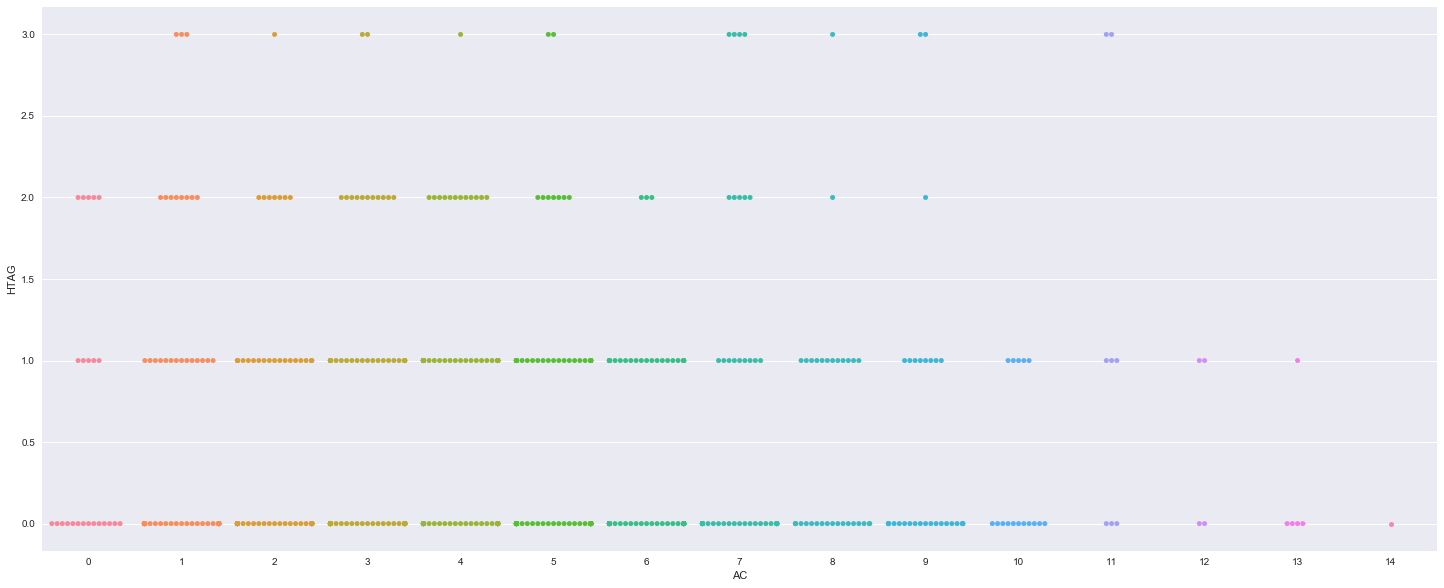

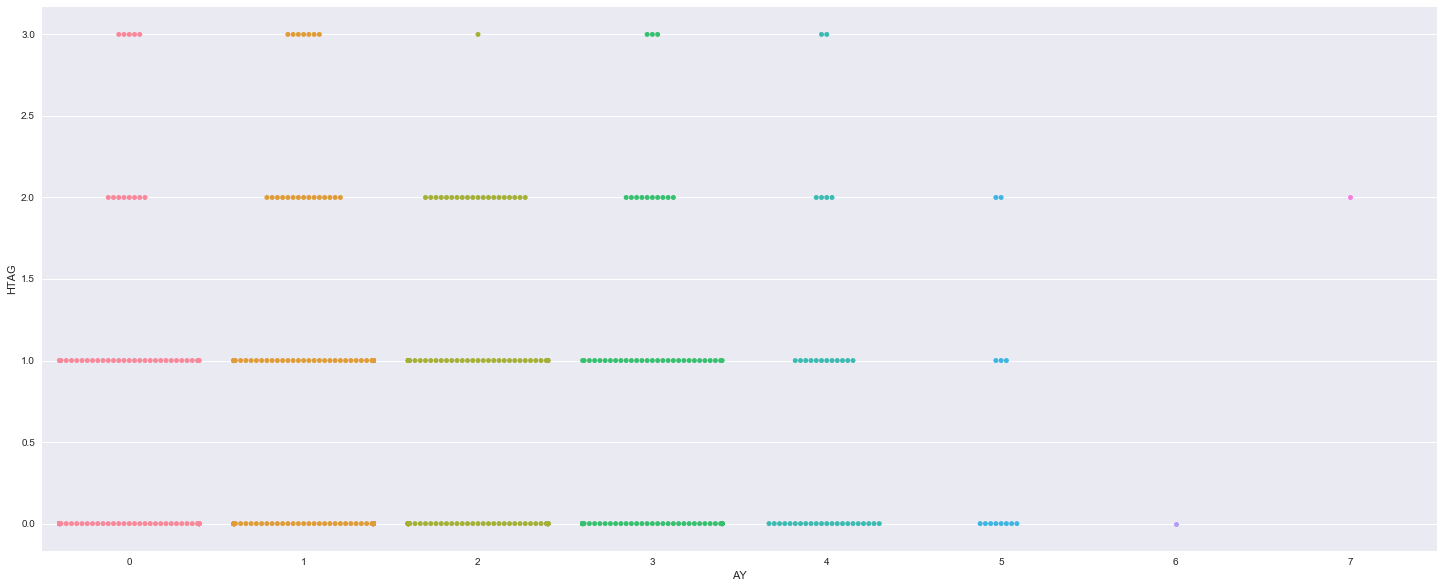

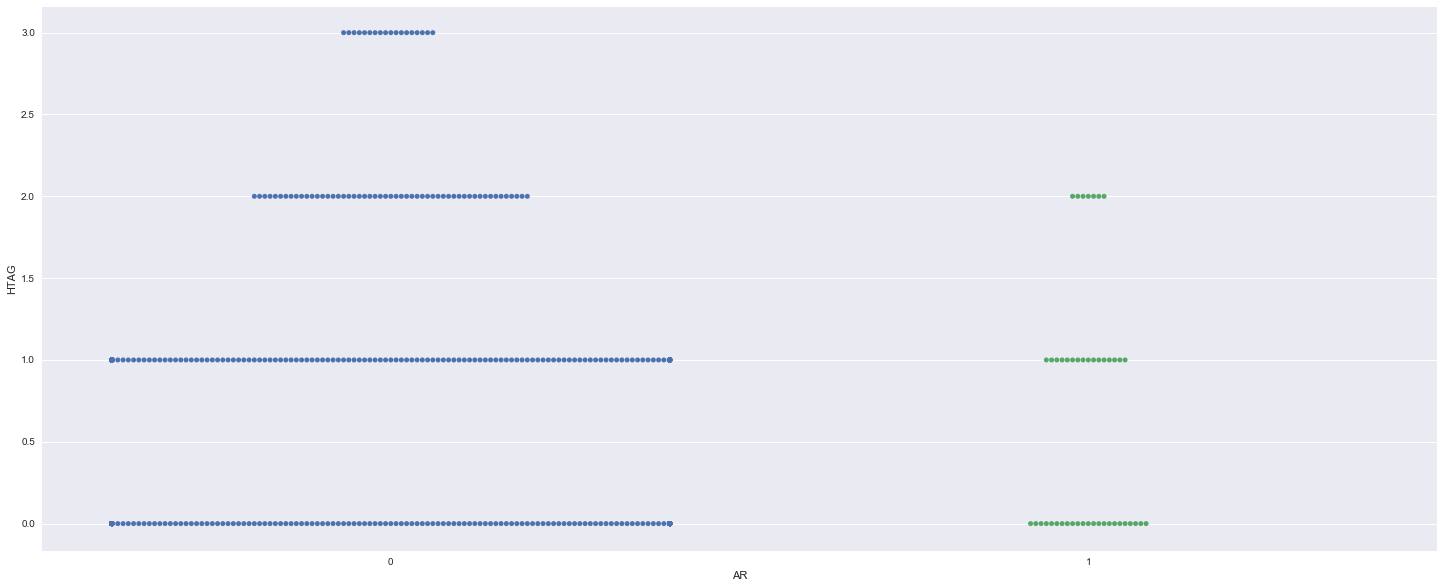

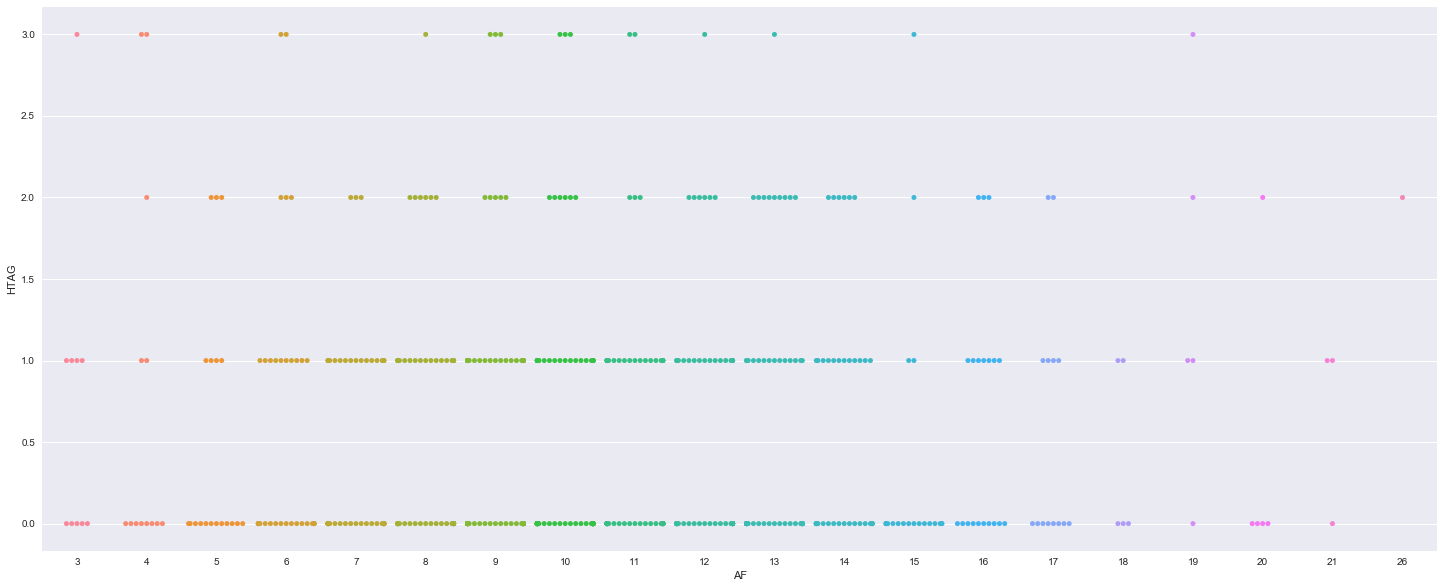

In [17]:
# now lets look at total score swarm plots by away features
away_list = ['AwayTeam', 'Referee','HTAG', 'AS', 
              'AST', 'AC', 'AY', 'AR', 'AF']

for x in away_list:
    plt.figure(figsize=(25,10))
    sns.swarmplot(df_total[x], df_total.HTAG)

<Figure size 1440x720 with 0 Axes>

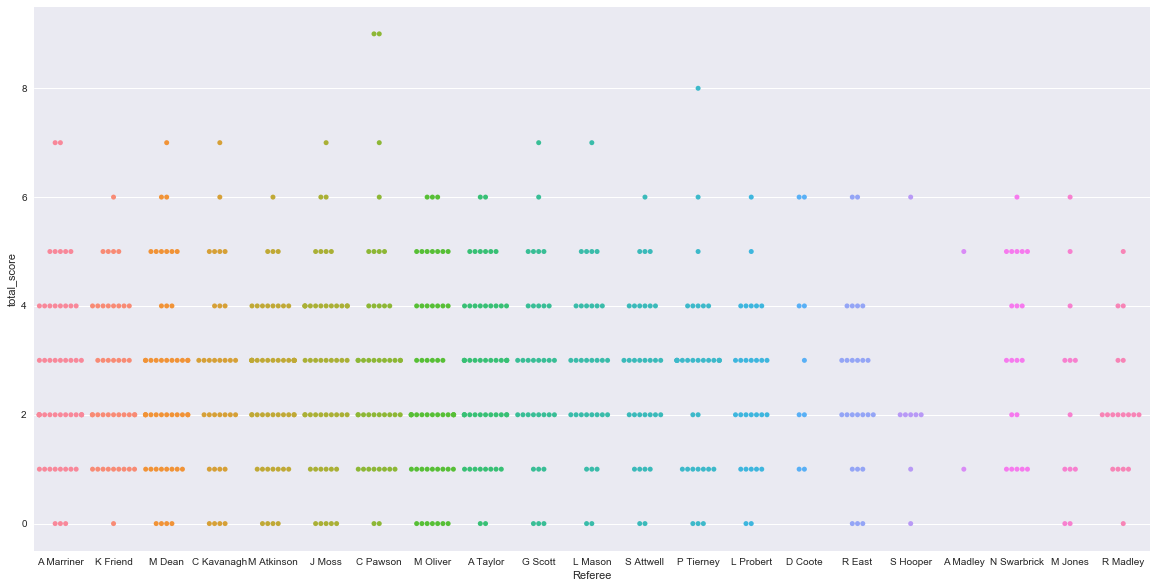

In [18]:
# total score swarmplots by referee
plt.figure(figsize=(20,10)) 
sns.swarmplot(df_total.Referee, df_total.total_score)

<Figure size 1800x720 with 0 Axes>

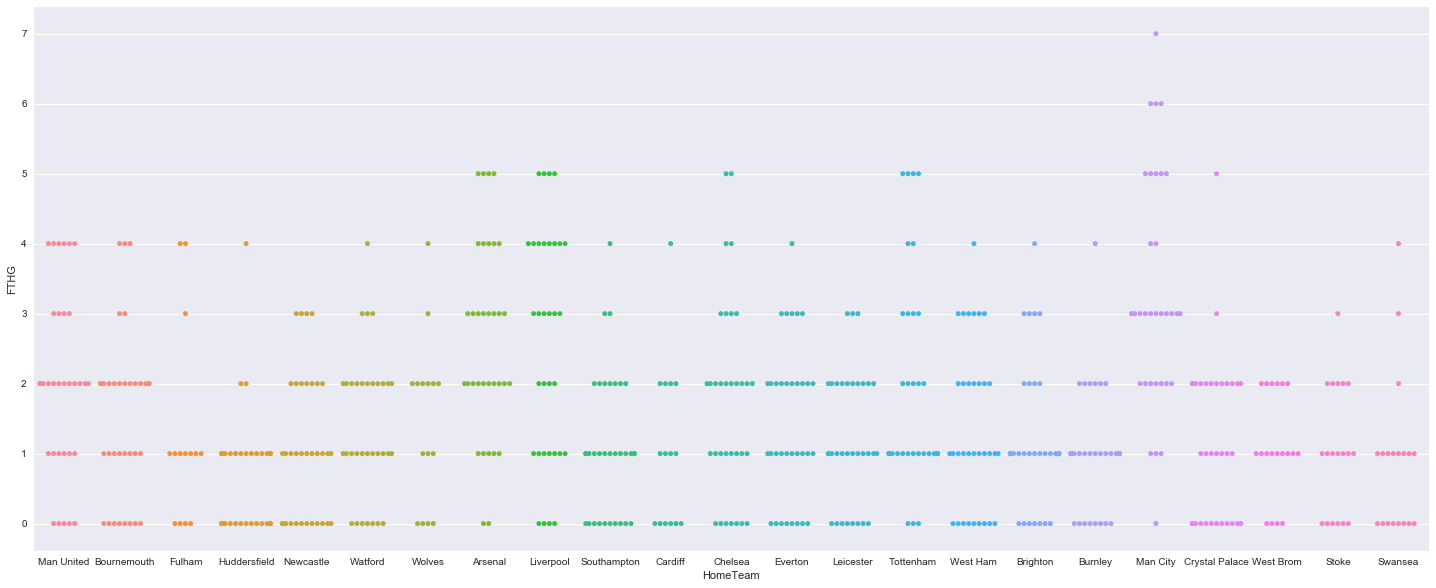

In [19]:
# home score swarmplots by HomeTeam
plt.figure(figsize=(25,10)) 
sns.swarmplot(df_total.HomeTeam, df_total.FTHG)

### Looks like Man City, Man United, and Liverpool (YNWA) have been doing great at home recently which makes sense if you have been following the EPL the past couple seasons

<Figure size 1800x720 with 0 Axes>

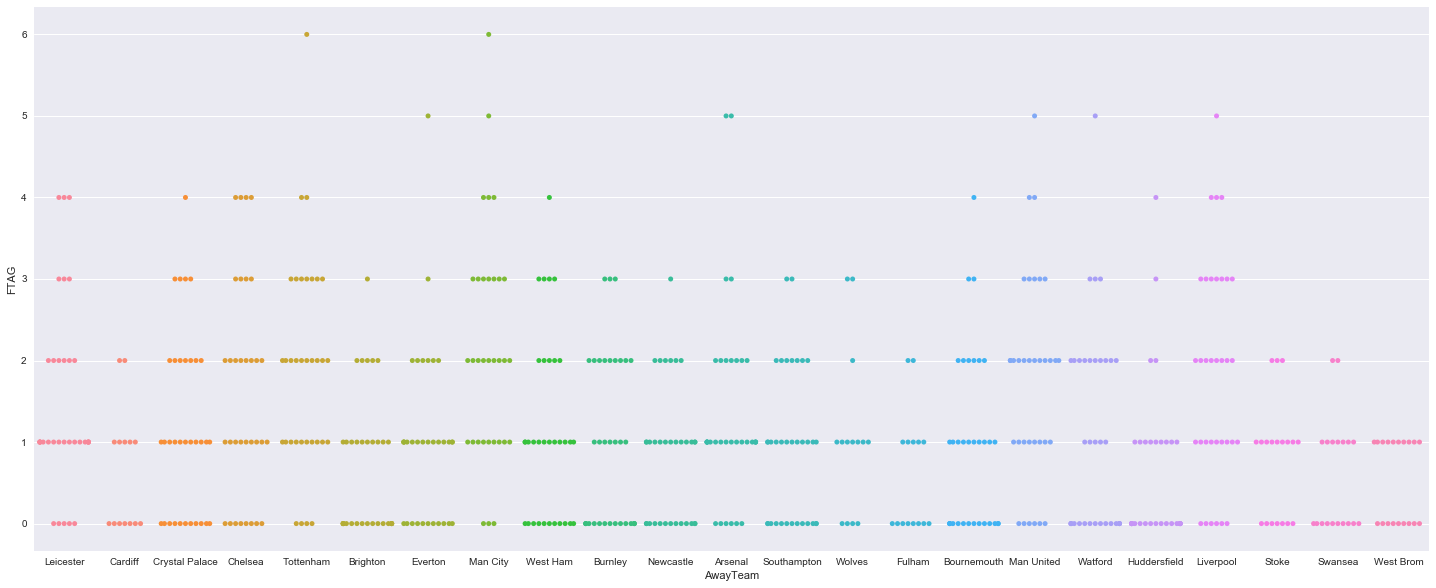

In [20]:
# away score swarmplots by AwayTeam
plt.figure(figsize=(25,10)) 
sns.swarmplot(df_total.AwayTeam, df_total.FTAG)

### looks like Spurs, Man City, and Liverpool (YNWA) have been doing great away from home lately which makes sense if you have been following the EPL the past couple seasons

<Figure size 1440x720 with 0 Axes>

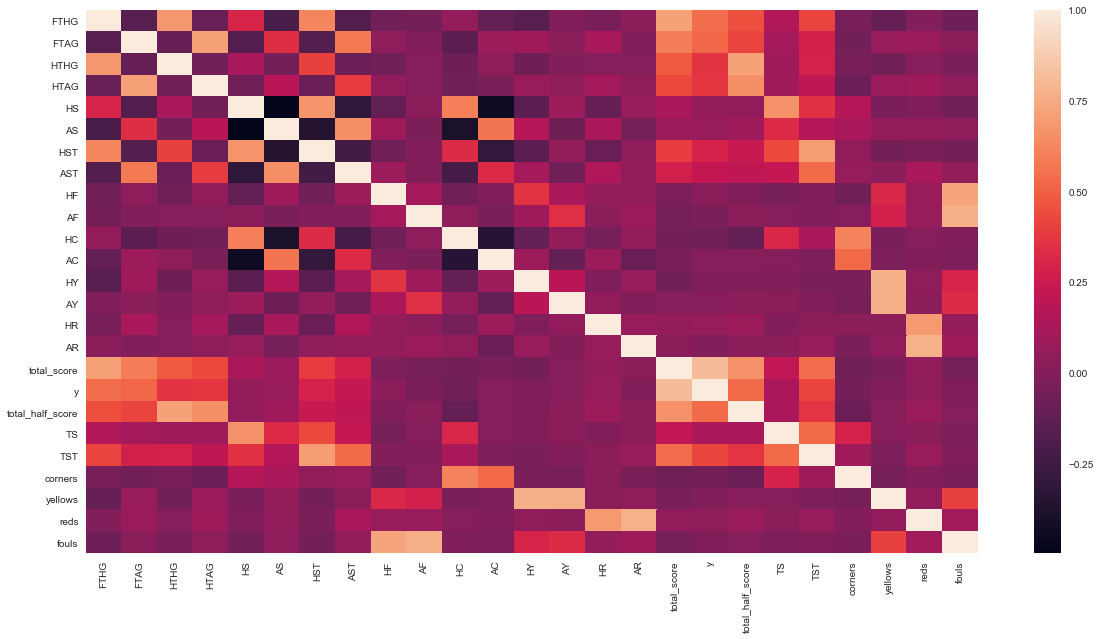

In [21]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_total.corr())
plt.show()

In [22]:
df_total.insert(loc=0, column='y', 
              value=df_total.y, 
              allow_duplicates=True) # move y to front of dataframe
df_total.info()
df_total.head()
df_total.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
y                   int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


y        Date      HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2018-08-10    Man United       Leicester     2     1     1     0   
1  0  2018-08-11   Bournemouth         Cardiff     2     0     1     0   
2  0  2018-08-11        Fulham  Crystal Palace     0     2     0     1   
3  1  2018-08-11  Huddersfield         Chelsea     0     3     0     2   
4  1  2018-08-11     Newcastle       Tottenham     1     2     1     2   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3   
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2   
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2   
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3   
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3   

   y  total_half_score  TS  TST  corners  yellows  reds  fouls  
0  1                 1  21   10        7        3     0     19  
1  0                 1  22    5       11        2     0     20  
2  0                 1  25   15       10        3     0     20  
3  1                 2  19    5        7        3     0     17  
4  1                 3  30    7        8        4     0     23

y        Date     HomeTeam   AwayTeam  FTHG  FTAG  HTHG  HTAG  \
664  1  2018-05-13    Newcastle    Chelsea     3     0     1     0   
665  0  2018-05-13  Southampton   Man City     0     1     0     0   
666  1  2018-05-13      Swansea      Stoke     1     2     1     2   
667  1  2018-05-13    Tottenham  Leicester     5     4     1     2   
668  1  2018-05-13     West Ham    Everton     3     1     1     0   

        Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  \
664  M Atkinson  16   6    6    2  11  10   4   2   0   1   0   0   
665  A Marriner   8  13    3    2   8  10   1  12   3   1   0   0   
666    A Taylor  26   8   11    5  12   9   6   0   1   2   0   0   
667    C Pawson  14  16    6    9   9  13   4   4   1   2   0   0   
668     G Scott  15  14    4    7  10  13   6   6   0   1   0   0   

     total_score  y  total_half_score  TS  TST  corners  yellows  reds  fouls  
664            3  1                 1  22    8        6        1     0     21  
665            1  0                 0  21    5       13        4     0     18  
666            3  1                 3  34   16        6        3     0     21  
667            9  1                 3  30   15        8        3     0     22  
668            4  1                 1  29   11       12        1     0     23

In [23]:
df_total = df_total.loc[:,~df_total.columns.duplicated()]
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 29 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
dtypes: int64(25), object(4)
memory usage: 151.6+ KB


y        Date      HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2018-08-10    Man United       Leicester     2     1     1     0   
1  0  2018-08-11   Bournemouth         Cardiff     2     0     1     0   
2  0  2018-08-11        Fulham  Crystal Palace     0     2     0     1   
3  1  2018-08-11  Huddersfield         Chelsea     0     3     0     2   
4  1  2018-08-11     Newcastle       Tottenham     1     2     1     2   

      Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0  A Marriner   8  13    6    4  11   8   2   5   2   1   0   0            3   
1    K Friend  12  10    4    1  11   9   7   4   1   1   0   0            2   
2      M Dean  15  10    6    9   9  11   5   5   1   2   0   0            2   
3  C Kavanagh   6  13    1    4   9   8   2   5   2   1   0   0            3   
4  M Atkinson  15  15    2    5  11  12   3   5   2   2   0   0            3   

   total_half_score  TS  TST  corners  yellows  reds  fouls  
0                 1  21   10        7        3     0     19  
1                 1  22    5       11        2     0     20  
2                 1  25   15       10        3     0     20  
3                 2  19    5        7        3     0     17  
4                 3  30    7        8        4     0     23

### Although a lot of the features we have analyze so far are very interesting in how they relate to our binary variable we are intending to predict, astute machine learning engineers following along closely will have noticed that a number of these features provided with each sample will not be available to be used in our model to predict whether or not a game will have more than 2.5 goals at the time before the game.  For example, we will not know how many goals an away or home side will score in the game we want to predict until after the game has occured.  However, we can draw useful information from these features by calculating features such as a particular teams last total goals scored in last 5 games (we can also do the same for other features like shots and # of cards).  

### lets start creating a function to create these fields as it will be tedious given the structure of the data (away/home, yet last 5 scores doesn't care about home or away

In [24]:
df_list = set(df.HomeTeam.unique().tolist())
df2_list = set(df2.AwayTeam.unique().tolist())
df_set = df_list.union(df2_list)
teamList = list(df_set)
teamList
len(teamList) # check # teams

['Swansea',
 'Wolves',
 'Crystal Palace',
 'West Ham',
 'Arsenal',
 'Tottenham',
 'Leicester',
 'Cardiff',
 'Man City',
 'Burnley',
 'Watford',
 'Chelsea',
 'Southampton',
 'West Brom',
 'Liverpool',
 'Stoke',
 'Bournemouth',
 'Huddersfield',
 'Man United',
 'Brighton',
 'Everton',
 'Newcastle',
 'Fulham']

23

In [25]:
df_total = df_total.sort_values(by=['Date'], ascending=True).reset_index(drop=True)
df_total['idx_test'] = df_total.index
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12        Brighton      Man City     0     2     0     0   
2  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
3  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   
4  0  2017-08-12         Everton         Stoke     1     0     1     0   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
2     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
3       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   
4  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  
0                 4  33   13       13        1     0     21         0  
1                 0  20    6       13        2     0     15         1  
2                 3  29   11       13        6     2     27         2  
3                 2  22   10       21        4     0     26         3  
4                 1  18    5       13        2     0     23         4

In [26]:
def last5_byteam(df=df_total, team='Arsenal'):
    dfteam = df_total.loc[((df_total.HomeTeam == team) | (df_total.AwayTeam == team)), :]
    dfteam = dfteam.drop(columns=['Referee'])
    dfteam.head()
    dfteam['team'] = team

    def goals(row, home, away):
        if row["HomeTeam"] == team:
            return row[home]
        elif row["AwayTeam"] == team:
            return row[away]

    dfteam['goals'] = dfteam.apply(goals, axis=1, home='FTHG', away='FTAG')
    dfteam['h_goals'] = dfteam.apply(goals, axis=1, home='HTHG', away='HTAG')
    dfteam['shots'] = dfteam.apply(goals, axis=1, home='HS', away='AS')
    dfteam['shots_on'] = dfteam.apply(goals, axis=1, home='HST', away='AST')
    dfteam['fls'] = dfteam.apply(goals, axis=1, home='HF', away='AF')
    dfteam['corns'] = dfteam.apply(goals, axis=1, home='HC', away='AC')
    dfteam['yells'] = dfteam.apply(goals, axis=1, home='HY', away='AY')
    dfteam['rds'] = dfteam.apply(goals, axis=1, home='HR', away='AR')
    
    dfteam = dfteam.sort_values(by=['Date']).reset_index(drop=True)
    
    dfteam['last5goals'] = dfteam.goals.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5Hgoals'] = dfteam.h_goals.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5shots'] = dfteam.shots.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5shots_on'] = dfteam.shots_on.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5fls'] = dfteam.fls.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5corns'] = dfteam.corns.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5yells'] = dfteam.yells.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5reds'] = dfteam.rds.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5total_goals'] = dfteam.total_score.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam['last5total_Hgoals'] = dfteam.total_half_score.rolling(5, min_periods=1).sum().shift(1).fillna(0)
    dfteam2 = dfteam[['Date','team', 'last5goals', 'last5Hgoals',
                      'last5shots', 'last5shots_on', 'last5fls',
                      'last5corns', 'last5yells', 'last5reds',
                      'last5total_goals', 'last5total_Hgoals']] # drop columns don't need
    
    return dfteam2

df_dict = {}
for team in teamList:
    df_dict[team] = last5_byteam(team=team)
    
df_dict['Man United'].head()
len(df_dict) # check df # matches # of teams

Date        team  last5goals  last5Hgoals  last5shots  last5shots_on  \
0  2017-08-13  Man United         0.0          0.0         0.0            0.0   
1  2017-08-19  Man United         4.0          1.0        22.0            6.0   
2  2017-08-26  Man United         8.0          2.0        39.0           14.0   
3  2017-09-09  Man United        10.0          2.0        61.0           21.0   
4  2017-09-17  Man United        12.0          3.0        79.0           29.0   

   last5fls  last5corns  last5yells  last5reds  last5total_goals  \
0       0.0         0.0         0.0        0.0               0.0   
1      19.0        11.0         2.0        0.0               4.0   
2      30.0        16.0         3.0        0.0               8.0   
3      38.0        25.0         4.0        0.0              10.0   
4      48.0        36.0         4.0        0.0              14.0   

   last5total_Hgoals  
0                0.0  
1                1.0  
2                2.0  
3                2.0  
4                4.0

23

In [27]:
df_total = df_total.sort_values(by=['Date'], ascending=True).reset_index(drop=True)
df_total['idx_test'] = df_total.index
df_total.to_csv('testv2.csv')
df_total.info()
df_total.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12        Brighton      Man City     0     2     0     0   
2  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
3  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   
4  0  2017-08-12         Everton         Stoke     1     0     1     0   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
2     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
3       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   
4  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  
0                 4  33   13       13        1     0     21         0  
1                 0  20    6       13        2     0     15         1  
2                 3  29   11       13        6     2     27         2  
3                 2  22   10       21        4     0     26         3  
4                 1  18    5       13        2     0     23         4

### joining all these team unique DFs to our original DF will be process and time intensive and will be tedious using pandas programming, so lets use PySpark so we can programmatically write SQL statements to accomplish finally creating these fields easily.

In [28]:
# find spark
import findspark
findspark.init()

# build spark session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("ddapp") \
    .getOrCreate()

# spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [29]:
# create SparkDataFrame from df_total
sp_df = spark.createDataFrame(df_total)
sp_df.show(3)

# build dict with spark DataFrames
sdf_dict = {}
for k, v in df_dict.items():
    sdf_dict[k] = spark.createDataFrame(v)

sdf_dict['Man United'].show(3)
type(sdf_dict['Man United']) # verify spark dataframe type
len(sdf_dict) # check df # matches # of teams

+---+----------+--------+---------+----+----+----+----+--------+---+---+---+---+---+---+---+---+---+---+---+---+-----------+----------------+---+---+-------+-------+----+-----+--------+
|  y|      Date|HomeTeam| AwayTeam|FTHG|FTAG|HTHG|HTAG| Referee| HS| AS|HST|AST| HF| AF| HC| AC| HY| AY| HR| AR|total_score|total_half_score| TS|TST|corners|yellows|reds|fouls|idx_test|
+---+----------+--------+---------+----+----+----+----+--------+---+---+---+---+---+---+---+---+---+---+---+---+-----------+----------------+---+---+-------+-------+----+-----+--------+
|  1|2017-08-11| Arsenal|Leicester|   4|   3|   2|   2|  M Dean| 27|  6| 10|  3|  9| 12|  9|  4|  0|  1|  0|  0|          7|               4| 33| 13|     13|      1|   0|   21|       0|
|  0|2017-08-12|Brighton| Man City|   0|   2|   0|   0|M Oliver|  6| 14|  2|  4|  6|  9|  3| 10|  0|  2|  0|  0|          2|               0| 20|  6|     13|      2|   0|   15|       1|
|  1|2017-08-12| Chelsea|  Burnley|   2|   3|   0|   3|C Pawson| 19| 1

pyspark.sql.dataframe.DataFrame

23

In [30]:
# create list of tempviews for spark sql
spsql_list = []
for team in teamList:
    sdf_dict[team].createOrReplaceTempView((str(team).replace(" ", "_")+'_sql'))
    spsql_list.append(((str(team).replace(" ", "_")+'_sql')))

spsql_list

['Swansea_sql',
 'Wolves_sql',
 'Crystal_Palace_sql',
 'West_Ham_sql',
 'Arsenal_sql',
 'Tottenham_sql',
 'Leicester_sql',
 'Cardiff_sql',
 'Man_City_sql',
 'Burnley_sql',
 'Watford_sql',
 'Chelsea_sql',
 'Southampton_sql',
 'West_Brom_sql',
 'Liverpool_sql',
 'Stoke_sql',
 'Bournemouth_sql',
 'Huddersfield_sql',
 'Man_United_sql',
 'Brighton_sql',
 'Everton_sql',
 'Newcastle_sql',
 'Fulham_sql']

In [31]:
# build each teams "last 5" dataframe 
spdf_dict = {}
for s in spsql_list:
    sp_df.createOrReplaceTempView("spdf_sql")
    query = """select a.*, 
                 b.team, 
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5goals else 0 end) as homeLast5goals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5goals else 0 end) as awayLast5goals,
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5Hgoals else 0 end) as homeLast5Hgoals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5Hgoals else 0 end) as awayLast5Hgoals,
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5shots else 0 end) as homeLast5shots,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5shots else 0 end) as awayLast5shots,
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5shots_on else 0 end) as homeLast5shots_on,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5shots_on else 0 end) as awayLast5shots_on,    
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5fls else 0 end) as homeLast5fls,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5fls else 0 end) as awayLast5fls,
                  
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5yells else 0 end) as homeLast5yells,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5yells else 0 end) as awayLast5yells, 
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5reds else 0 end) as homeLast5reds,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5reds else 0 end) as awayLast5reds,
                 
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5corns else 0 end) as homeLast5corns,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5corns else 0 end) as awayLast5corns, 
                      
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5total_goals else 0 end) as homeLast5total_goals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5total_goals else 0 end) as awayLast5total_goals,
                                            
                 (case when a.Date = b.Date and a.HomeTeam = b.team 
                      then b.last5total_Hgoals else 0 end) as homeLast5total_Hgoals,
                 (case when a.Date = b.Date and a.AwayTeam = b.team 
                      then b.last5total_Hgoals else 0 end) as awayLast5total_Hgoals
               from spdf_sql as a 
                 left join {} as b 
                   on a.Date = b.Date and (a.HomeTeam = b.team OR a.AwayTeam = b.team)
                order by a.Date""".format(s)
    sqlDF = spark.sql(query)
    sqlDF[['y', 'Date', 'HomeTeam', 'AwayTeam', 'team', \
           'FTHG', 'FTAG', 'total_score', 
           'homeLast5goals', 'awayLast5goals']].show(20)
    type(sqlDF)
    spdf_dict[s] = sqlDF
    spdf_dict.keys()

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|Swansea|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bou

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql'])

+---+----------+--------------+--------------+--------------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|          team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|          null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|          null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|          null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|          null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|          null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|          null|   1|   0|          1|     

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|    null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|    null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|    null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|    null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|    null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|      Bright

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|Arsenal|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|      

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|     null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|Leicester|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|     null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|     null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|    null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|Man City|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|    null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|    null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|    null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|Crystal Pala

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|Burnley|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bou

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|Watford|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|   null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bou

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|   null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bou

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql'])

+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|       team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|       null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|Southampton|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|       null|   0|   3|          3|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|       null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|       null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|       null|   1|   0|          1|           0.0|           0.0|
|

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|     null|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|Cry

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|Liverpool|   3|   3|          6|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|     null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql'])

+---+----------+--------------+--------------+-----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam| team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester| null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth| null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea| null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley| null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|Stoke|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City| null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield| null|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql'])

+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|       team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|       null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|       null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|       null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|       null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|       null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|Bournemouth|   1|   0|          1|           0.0|           0.0|
|

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql', 'Bournemouth_sql'])

+---+----------+--------------+--------------+------------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|        team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+------------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|        null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|        null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|        null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|        null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|        null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|        null|   1|   0|          1|           0.0|        

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql', 'Bournemouth_sql', 'Huddersfield_sql'])

+---+----------+--------------+--------------+----------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|      team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|      null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|      null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|      null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|      null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|      null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|      null|   0|   2|          2|           0.0|           0.0|
|  0|2017-

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql', 'Bournemouth_sql', 'Huddersfield_sql', 'Man_United_sql'])

+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|    team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+--------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|    null|   4|   3|          7|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|    null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|    null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|    null|   1|   0|          1|           0.0|           0.0|
|  1|2017-08-12|Crystal Palace|  Huddersfield|    null|   0|   3|          3|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|Brighton|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|       Evert

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql', 'Bournemouth_sql', 'Huddersfield_sql', 'Man_United_sql', 'Brighton_sql'])

+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|   team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+-------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|   null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|   null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|   null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|   null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|   null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|   null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|       Everton|      

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql', 'Bournemouth_sql', 'Huddersfield_sql', 'Man_United_sql', 'Brighton_sql', 'Everton_sql'])

+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|     team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+---------+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|     null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|     null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|     null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|     null|   0|   2|          2|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|     null|   0|   0|          0|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|     null|   2|   3|          5|           0.0|           0.0|
|  1|2017-08-12|Cry

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql', 'Bournemouth_sql', 'Huddersfield_sql', 'Man_United_sql', 'Brighton_sql', 'Everton_sql', 'Newcastle_sql'])

+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  y|      Date|      HomeTeam|      AwayTeam|team|FTHG|FTAG|total_score|homeLast5goals|awayLast5goals|
+---+----------+--------------+--------------+----+----+----+-----------+--------------+--------------+
|  1|2017-08-11|       Arsenal|     Leicester|null|   4|   3|          7|           0.0|           0.0|
|  1|2017-08-12|       Chelsea|       Burnley|null|   2|   3|          5|           0.0|           0.0|
|  0|2017-08-12|      Brighton|      Man City|null|   0|   2|          2|           0.0|           0.0|
|  1|2017-08-12|       Watford|     Liverpool|null|   3|   3|          6|           0.0|           0.0|
|  0|2017-08-12|   Southampton|       Swansea|null|   0|   0|          0|           0.0|           0.0|
|  0|2017-08-12|       Everton|         Stoke|null|   1|   0|          1|           0.0|           0.0|
|  0|2017-08-12|     West Brom|   Bournemouth|null|   1|   0|   

pyspark.sql.dataframe.DataFrame

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql', 'Bournemouth_sql', 'Huddersfield_sql', 'Man_United_sql', 'Brighton_sql', 'Everton_sql', 'Newcastle_sql', 'Fulham_sql'])

In [32]:
pandas_dict = {}
for key, spark_sqlDF in spdf_dict.items():
    pandas_dict[key] = spdf_dict[key].toPandas()
    
pandas_dict['Arsenal_sql'].head()
pandas_dict['Arsenal_sql'].info()
df_total.head()
df_total.info()

y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12        Brighton      Man City     0     2     0     0   
2  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
3  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   
4  0  2017-08-12         Everton         Stoke     1     0     1     0   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
2     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
3       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   
4  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  \
0                 4  33   13       13        1     0     21         0   
1                 0  20    6       13        2     0     15         1   
2                 3  29   11       13        6     2     27         2   
3                 2  22   10       21        4     0     26         3   
4                 1  18    5       13        2     0     23         4   

      team  homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
0  Arsenal             0.0             0.0              0.0              0.0   
1     None             0.0             0.0              0.0              0.0   
2     None             0.0             0.0              0.0              0.0   
3     None             0.0             0.0              0.0              0.0   
4     None             0.0             0.0              0.0              0.0   

   homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0.0             0.0                0.0                0.0   
3             0.0             0.0                0.0                0.0   
4             0.0             0.0                0.0                0.0   

   homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  homeLast5reds  \
0           0.0           0.0             0.0             0.0            0.0   
1           0.0           0.0             0.0             0.0            0.0   
2           0.0           0.0             0.0             0.0            0.0   
3           0.0           0.0             0.0             0.0            0.0   
4           0.0           0.0             0.0             0.0            0.0   

   awayLast5reds  homeLast5corns  awayLast5corns  homeLast5total_goals  \
0            0.0             0.0             0.0                   0.0   
1            0.0             0.0             0.0                   0.0   
2            0.0             0.0             0.0                   0.0   
3            0.0             0.0             0.0                   0.0   
4            0.0             0.0             0.0                   0.0   

   awayLast5total_goals  homeLast5total_Hgoals  awayLast5total_Hgoals  
0                   0.0                    0.0                    0.0  
1                   0.0                    0.0                    0.0  
2                   0.0                    0.0                    0.0  
3                   0.0                    0.0                    0.0  
4                   0.0                    0.0                    0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 51 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
FTHG                     int64
FTAG                     int64
HTHG                     int64
HTAG                     int64
Referee                  object
HS                       int64
AS                       int64
HST                      int64
AST                      int64
HF                       int64
AF                       int64
HC                       int64
AC                       int64
HY                       int64
AY                       int64
HR                       int64
AR                       int64
total_score              int64
total_half_score         int64
TS                       int64
TST                      int64
corners                  int64
yellows                  int64
reds                     int64
fouls                  

y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12        Brighton      Man City     0     2     0     0   
2  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
3  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   
4  0  2017-08-12         Everton         Stoke     1     0     1     0   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
2     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
3       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   
4  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  
0                 4  33   13       13        1     0     21         0  
1                 0  20    6       13        2     0     15         1  
2                 3  29   11       13        6     2     27         2  
3                 2  22   10       21        4     0     26         3  
4                 1  18    5       13        2     0     23         4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


In [33]:
pandas_dict.keys()

dict_keys(['Swansea_sql', 'Wolves_sql', 'Crystal_Palace_sql', 'West_Ham_sql', 'Arsenal_sql', 'Tottenham_sql', 'Leicester_sql', 'Cardiff_sql', 'Man_City_sql', 'Burnley_sql', 'Watford_sql', 'Chelsea_sql', 'Southampton_sql', 'West_Brom_sql', 'Liverpool_sql', 'Stoke_sql', 'Bournemouth_sql', 'Huddersfield_sql', 'Man_United_sql', 'Brighton_sql', 'Everton_sql', 'Newcastle_sql', 'Fulham_sql'])

In [34]:
# make list of dataframes to use in append
pds_list = []
for k, v in pandas_dict.items():
    pds_list.append(v)

In [35]:
df_last5 = (reduce(lambda df1, df2: 
                  df1.append(df2,  ignore_index=True), 
                  pds_list)).groupby(['idx_test', 'Date'])\
                  ['homeLast5goals', 'awayLast5goals', 
                   'homeLast5Hgoals', 'awayLast5Hgoals',
                   'homeLast5shots', 'awayLast5shots', 
                   'homeLast5shots_on', 'awayLast5shots_on',
                   'homeLast5fls', 'awayLast5fls', 
                   'homeLast5yells', 'awayLast5yells',
                   'homeLast5reds', 'awayLast5reds',
                   'homeLast5corns', 'awayLast5corns',
                   'homeLast5total_goals', 'awayLast5total_goals',
                   'homeLast5total_Hgoals', 'awayLast5total_Hgoals'].sum()\
                                                                    .reset_index(drop=False)

df_last5.info()
df_last5.tail(10)
df_total.info() # check to make sure tables have same rows
df_total.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 22 columns):
idx_test                 int64
Date                     object
homeLast5goals           float64
awayLast5goals           float64
homeLast5Hgoals          float64
awayLast5Hgoals          float64
homeLast5shots           float64
awayLast5shots           float64
homeLast5shots_on        float64
awayLast5shots_on        float64
homeLast5fls             float64
awayLast5fls             float64
homeLast5yells           float64
awayLast5yells           float64
homeLast5reds            float64
awayLast5reds            float64
homeLast5corns           float64
awayLast5corns           float64
homeLast5total_goals     float64
awayLast5total_goals     float64
homeLast5total_Hgoals    float64
awayLast5total_Hgoals    float64
dtypes: float64(20), int64(1), object(1)
memory usage: 115.1+ KB


idx_test        Date  homeLast5goals  awayLast5goals  homeLast5Hgoals  \
659       659  2019-03-02             6.0            13.0              2.0   
660       660  2019-03-02             8.0             6.0              2.0   
661       661  2019-03-02             5.0             7.0              4.0   
662       662  2019-03-02             7.0            12.0              1.0   
663       663  2019-03-02             5.0             2.0              2.0   
664       664  2019-03-02             8.0             9.0              1.0   
665       665  2019-03-02             9.0             5.0              4.0   
666       666  2019-03-03             5.0             7.0              1.0   
667       667  2019-03-03             5.0            10.0              3.0   
668       668  2019-03-03             7.0             5.0              2.0   

     awayLast5Hgoals  homeLast5shots  awayLast5shots  homeLast5shots_on  \
659              8.0            56.0            81.0               19.0   
660              1.0            67.0            58.0               21.0   
661              2.0            46.0            64.0               14.0   
662              7.0            76.0            56.0               18.0   
663              0.0            74.0            48.0               22.0   
664              3.0            52.0            81.0               21.0   
665              2.0            72.0            61.0               29.0   
666              2.0            69.0            70.0               19.0   
667              6.0            48.0            67.0               18.0   
668              2.0            38.0            88.0               13.0   

     awayLast5shots_on  homeLast5fls  awayLast5fls  homeLast5yells  \
659               36.0          47.0          35.0            11.0   
660               16.0          54.0          63.0            13.0   
661               22.0          45.0          43.0             5.0   
662               20.0          49.0          52.0             7.0   
663               14.0          43.0          52.0             6.0   
664               21.0          43.0          51.0            11.0   
665               23.0          52.0          64.0            11.0   
666               20.0          60.0          49.0            10.0   
667               29.0          56.0          60.0             9.0   
668               25.0          58.0          37.0            10.0   

     awayLast5yells  homeLast5reds  awayLast5reds  homeLast5corns  \
659             6.0            0.0            0.0            28.0   
660            11.0            0.0            0.0            32.0   
661             9.0            0.0            0.0            21.0   
662             8.0            0.0            0.0            25.0   
663             6.0            0.0            1.0            30.0   
664            10.0            0.0            1.0            24.0   
665             6.0            0.0            0.0            26.0   
666             5.0            0.0            0.0            20.0   
667             7.0            2.0            0.0            18.0   
668            11.0            0.0            0.0            20.0   

     awayLast5corns  homeLast5total_goals  awayLast5total_goals  \
659            32.0                  17.0                  16.0   
660            21.0                  12.0                  17.0   
661            21.0                  12.0                  10.0   
662            21.0                  13.0                  18.0   
663            13.0                  16.0                  12.0   
664            37.0                  15.0                  15.0   
665            24.0                  12.0                  11.0   
666            28.0                  17.0                  19.0   
667            33.0                  11.0                  12.0   
668            29.0                  15.0                  15.0   

     homeLast5total_Hgoals  awayLast5total_Hgoals  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 30 columns):
y                   int64
Date                object
HomeTeam            object
AwayTeam            object
FTHG                int64
FTAG                int64
HTHG                int64
HTAG                int64
Referee             object
HS                  int64
AS                  int64
HST                 int64
AST                 int64
HF                  int64
AF                  int64
HC                  int64
AC                  int64
HY                  int64
AY                  int64
HR                  int64
AR                  int64
total_score         int64
total_half_score    int64
TS                  int64
TST                 int64
corners             int64
yellows             int64
reds                int64
fouls               int64
idx_test            int64
dtypes: int64(26), object(4)
memory usage: 156.9+ KB


y        Date     HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
659  0  2019-03-02  Bournemouth        Man City     0     1     0     0   
660  0  2019-03-02       Wolves         Cardiff     2     0     2     0   
661  0  2019-03-02     West Ham       Newcastle     2     0     2     0   
662  0  2019-03-02    Tottenham         Arsenal     1     1     0     1   
663  0  2019-03-02     Brighton    Huddersfield     1     0     0     0   
664  1  2019-03-02      Burnley  Crystal Palace     1     3     0     1   
665  1  2019-03-02   Man United     Southampton     3     2     0     1   
666  1  2019-03-03       Fulham         Chelsea     1     2     1     2   
667  0  2019-03-03      Everton       Liverpool     0     0     0     0   
668  1  2019-03-03      Watford       Leicester     2     1     1     0   

        Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  \
659    K Friend   0  23    0    7   7   7   0  14   1   2   0   0   
660  A Marriner  13  12    6    4  11   6   7   8   1   2   0   0   
661  C Kavanagh  10  17    4    2   8  14   1   6   3   4   0   0   
662    A Taylor  10   9    3    4  15  14   3   4   3   2   0   1   
663      M Dean  13   6    4    4  11   6   6   3   2   2   0   0   
664   L Probert  18  10    4    4   9   9   8   5   1   2   0   0   
665   S Attwell  16   6    6    3   7  10   9   7   2   1   0   0   
666     G Scott  12  20    5    7  11  10   5   4   2   1   0   0   
667  M Atkinson   7  10    3    3  12  10   3   7   1   2   0   0   
668      J Moss   6  14    5    2  15  12   1   5   5   1   0   0   

     total_score  total_half_score  TS  TST  corners  yellows  reds  fouls  \
659            1                 0  23    7       14        3     0     14   
660            2                 2  25   10       15        3     0     17   
661            2                 2  27    6        7        7     0     22   
662            2                 1  19    7        7        5     1     29   
663            1                 0  19    8        9        4     0     17   
664            4                 1  28    8       13        3     0     18   
665            5                 1  22    9       16        3     0     17   
666            3                 3  32   12        9        3     0     21   
667            0                 0  17    6       10        3     0     22   
668            3                 1  20    7        6        6     0     27   

     idx_test  
659       659  
660       660  
661       661  
662       662  
663       663  
664       664  
665       665  
666       666  
667       667  
668       668

In [36]:
df_final = df_total.merge(df_last5, on=['Date', 'idx_test'])
df_final.to_csv('test.csv')
df_final.info()
df_final.head(10)
df_final.tail(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669 entries, 0 to 668
Data columns (total 50 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
FTHG                     int64
FTAG                     int64
HTHG                     int64
HTAG                     int64
Referee                  object
HS                       int64
AS                       int64
HST                      int64
AST                      int64
HF                       int64
AF                       int64
HC                       int64
AC                       int64
HY                       int64
AY                       int64
HR                       int64
AR                       int64
total_score              int64
total_half_score         int64
TS                       int64
TST                      int64
corners                  int64
yellows                  int64
reds                     int64
fouls                  

y        Date        HomeTeam      AwayTeam  FTHG  FTAG  HTHG  HTAG  \
0  1  2017-08-11         Arsenal     Leicester     4     3     2     2   
1  0  2017-08-12        Brighton      Man City     0     2     0     0   
2  1  2017-08-12         Chelsea       Burnley     2     3     0     3   
3  1  2017-08-12  Crystal Palace  Huddersfield     0     3     0     2   
4  0  2017-08-12         Everton         Stoke     1     0     1     0   
5  0  2017-08-12     Southampton       Swansea     0     0     0     0   
6  1  2017-08-12         Watford     Liverpool     3     3     2     1   
7  0  2017-08-12       West Brom   Bournemouth     1     0     1     0   
8  1  2017-08-13      Man United      West Ham     4     0     1     0   
9  0  2017-08-13       Newcastle     Tottenham     0     2     0     0   

       Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  total_score  \
0       M Dean  27   6   10    3   9  12   9   4   0   1   0   0            7   
1     M Oliver   6  14    2    4   6   9   3  10   0   2   0   0            2   
2     C Pawson  19  10    6    5  16  11   8   5   3   3   2   0            5   
3       J Moss  14   8    4    6   7  19  12   9   1   3   0   0            3   
4  N Swarbrick   9   9    4    1  13  10   6   7   1   1   0   0            1   
5      M Jones  29   4    2    0  10  13  13   0   2   1   0   0            0   
6     A Taylor   9  14    4    5  14   8   3   3   0   3   0   0            6   
7     R Madley  16   9    6    2  15   3   8   2   3   1   0   0            1   
8   M Atkinson  22   9    6    1  19   7  11   1   2   2   0   0            4   
9   A Marriner   6  18    3    6   6  10   5   7   1   2   1   0            2   

   total_half_score  TS  TST  corners  yellows  reds  fouls  idx_test  \
0                 4  33   13       13        1     0     21         0   
1                 0  20    6       13        2     0     15         1   
2                 3  29   11       13        6     2     27         2   
3                 2  22   10       21        4     0     26         3   
4                 1  18    5       13        2     0     23         4   
5                 0  33    2       13        3     0     23         5   
6                 3  23    9        6        3     0     22         6   
7                 1  25    8       10        4     0     18         7   
8                 1  31    7       12        4     0     26         8   
9                 0  24    9       12        3     1     16         9   

   homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
0             0.0             0.0              0.0              0.0   
1             0.0             0.0              0.0              0.0   
2             0.0             0.0              0.0              0.0   
3             0.0             0.0              0.0              0.0   
4             0.0             0.0              0.0              0.0   
5             0.0             0.0              0.0              0.0   
6             0.0             0.0              0.0              0.0   
7             0.0             0.0              0.0              0.0   
8             0.0             0.0              0.0              0.0   
9             0.0             0.0              0.0              0.0   

   homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0.0             0.0                0.0                0.0   
3             0.0             0.0                0.0                0.0   
4             0.0             0.0                0.0                0.0   
5             0.0             0.0                0.0                0.0   
6             0.0             0.0                0.0                0.0   
7             0.0             0.0                0.0                0.0   
8             0.0             0.0  

y        Date     HomeTeam        AwayTeam  FTHG  FTAG  HTHG  HTAG  \
659  0  2019-03-02  Bournemouth        Man City     0     1     0     0   
660  0  2019-03-02       Wolves         Cardiff     2     0     2     0   
661  0  2019-03-02     West Ham       Newcastle     2     0     2     0   
662  0  2019-03-02    Tottenham         Arsenal     1     1     0     1   
663  0  2019-03-02     Brighton    Huddersfield     1     0     0     0   
664  1  2019-03-02      Burnley  Crystal Palace     1     3     0     1   
665  1  2019-03-02   Man United     Southampton     3     2     0     1   
666  1  2019-03-03       Fulham         Chelsea     1     2     1     2   
667  0  2019-03-03      Everton       Liverpool     0     0     0     0   
668  1  2019-03-03      Watford       Leicester     2     1     1     0   

        Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  \
659    K Friend   0  23    0    7   7   7   0  14   1   2   0   0   
660  A Marriner  13  12    6    4  11   6   7   8   1   2   0   0   
661  C Kavanagh  10  17    4    2   8  14   1   6   3   4   0   0   
662    A Taylor  10   9    3    4  15  14   3   4   3   2   0   1   
663      M Dean  13   6    4    4  11   6   6   3   2   2   0   0   
664   L Probert  18  10    4    4   9   9   8   5   1   2   0   0   
665   S Attwell  16   6    6    3   7  10   9   7   2   1   0   0   
666     G Scott  12  20    5    7  11  10   5   4   2   1   0   0   
667  M Atkinson   7  10    3    3  12  10   3   7   1   2   0   0   
668      J Moss   6  14    5    2  15  12   1   5   5   1   0   0   

     total_score  total_half_score  TS  TST  corners  yellows  reds  fouls  \
659            1                 0  23    7       14        3     0     14   
660            2                 2  25   10       15        3     0     17   
661            2                 2  27    6        7        7     0     22   
662            2                 1  19    7        7        5     1     29   
663            1                 0  19    8        9        4     0     17   
664            4                 1  28    8       13        3     0     18   
665            5                 1  22    9       16        3     0     17   
666            3                 3  32   12        9        3     0     21   
667            0                 0  17    6       10        3     0     22   
668            3                 1  20    7        6        6     0     27   

     idx_test  homeLast5goals  awayLast5goals  homeLast5Hgoals  \
659       659             6.0            13.0              2.0   
660       660             8.0             6.0              2.0   
661       661             5.0             7.0              4.0   
662       662             7.0            12.0              1.0   
663       663             5.0             2.0              2.0   
664       664             8.0             9.0              1.0   
665       665             9.0             5.0              4.0   
666       666             5.0             7.0              1.0   
667       667             5.0            10.0              3.0   
668       668             7.0             5.0              2.0   

     awayLast5Hgoals  homeLast5shots  awayLast5shots  homeLast5shots_on  \
659              8.0            56.0            81.0               19.0   
660              1.0            67.0            58.0               21.0   
661              2.0            46.0            64.0               14.0   
662              7.0            76.0            56.0               18.0   
663              0.0            74.0            48.0               22.0   
664              3.0            52.0            81.0               21.0   
665              2.0            72.0            61.0               29.0   
666              2.0            69.0            70.0               19.0   
667              6.0            48.0            67.0               18.0   
668              2.0            38.0            88.0               13.0   

     aw

In [37]:
# drop columns that can't be used for predictive power
# i.e. can't gathered collected before a match
df_final = df_final.drop(columns=['FTHG', 'FTAG', 'HTHG', 'HTAG', 
                                  'HS', 'AS', 'HST', 'AST', 'HF', 
                                  'AF', 'HC', 'AC', 'HY', 'AY',
                                  'HR', 'AR', 'total_half_score', 
                                  'TS', 'TST', 'corners', 'yellows', 
                                  'reds', 'fouls', 'idx_test'])

In [38]:
df_final.head()
df_final.tail()
df_final.info()

y        Date        HomeTeam      AwayTeam      Referee  total_score  \
0  1  2017-08-11         Arsenal     Leicester       M Dean            7   
1  0  2017-08-12        Brighton      Man City     M Oliver            2   
2  1  2017-08-12         Chelsea       Burnley     C Pawson            5   
3  1  2017-08-12  Crystal Palace  Huddersfield       J Moss            3   
4  0  2017-08-12         Everton         Stoke  N Swarbrick            1   

   homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
0             0.0             0.0              0.0              0.0   
1             0.0             0.0              0.0              0.0   
2             0.0             0.0              0.0              0.0   
3             0.0             0.0              0.0              0.0   
4             0.0             0.0              0.0              0.0   

   homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0.0             0.0                0.0                0.0   
3             0.0             0.0                0.0                0.0   
4             0.0             0.0                0.0                0.0   

   homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  homeLast5reds  \
0           0.0           0.0             0.0             0.0            0.0   
1           0.0           0.0             0.0             0.0            0.0   
2           0.0           0.0             0.0             0.0            0.0   
3           0.0           0.0             0.0             0.0            0.0   
4           0.0           0.0             0.0             0.0            0.0   

   awayLast5reds  homeLast5corns  awayLast5corns  homeLast5total_goals  \
0            0.0             0.0             0.0                   0.0   
1            0.0             0.0             0.0                   0.0   
2            0.0             0.0             0.0                   0.0   
3            0.0             0.0             0.0                   0.0   
4            0.0             0.0             0.0                   0.0   

   awayLast5total_goals  homeLast5total_Hgoals  awayLast5total_Hgoals  
0                   0.0                    0.0                    0.0  
1                   0.0                    0.0                    0.0  
2                   0.0                    0.0                    0.0  
3                   0.0                    0.0                    0.0  
4                   0.0                    0.0                    0.0

y        Date    HomeTeam        AwayTeam     Referee  total_score  \
664  1  2019-03-02     Burnley  Crystal Palace   L Probert            4   
665  1  2019-03-02  Man United     Southampton   S Attwell            5   
666  1  2019-03-03      Fulham         Chelsea     G Scott            3   
667  0  2019-03-03     Everton       Liverpool  M Atkinson            0   
668  1  2019-03-03     Watford       Leicester      J Moss            3   

     homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
664             8.0             9.0              1.0              3.0   
665             9.0             5.0              4.0              2.0   
666             5.0             7.0              1.0              2.0   
667             5.0            10.0              3.0              6.0   
668             7.0             5.0              2.0              2.0   

     homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
664            52.0            81.0               21.0               21.0   
665            72.0            61.0               29.0               23.0   
666            69.0            70.0               19.0               20.0   
667            48.0            67.0               18.0               29.0   
668            38.0            88.0               13.0               25.0   

     homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  \
664          43.0          51.0            11.0            10.0   
665          52.0          64.0            11.0             6.0   
666          60.0          49.0            10.0             5.0   
667          56.0          60.0             9.0             7.0   
668          58.0          37.0            10.0            11.0   

     homeLast5reds  awayLast5reds  homeLast5corns  awayLast5corns  \
664            0.0            1.0            24.0            37.0   
665            0.0            0.0            26.0            24.0   
666            0.0            0.0            20.0            28.0   
667            2.0            0.0            18.0            33.0   
668            0.0            0.0            20.0            29.0   

     homeLast5total_goals  awayLast5total_goals  homeLast5total_Hgoals  \
664                  15.0                  15.0                    3.0   
665                  12.0                  11.0                    4.0   
666                  17.0                  19.0                   10.0   
667                  11.0                  12.0                    6.0   
668                  15.0                  15.0                    4.0   

     awayLast5total_Hgoals  
664                    5.0  
665                    5.0  
666                    8.0  
667                    8.0  
668                    6.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669 entries, 0 to 668
Data columns (total 26 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
Referee                  object
total_score              int64
homeLast5goals           float64
awayLast5goals           float64
homeLast5Hgoals          float64
awayLast5Hgoals          float64
homeLast5shots           float64
awayLast5shots           float64
homeLast5shots_on        float64
awayLast5shots_on        float64
homeLast5fls             float64
awayLast5fls             float64
homeLast5yells           float64
awayLast5yells           float64
homeLast5reds            float64
awayLast5reds            float64
homeLast5corns           float64
awayLast5corns           float64
homeLast5total_goals     float64
awayLast5total_goals     float64
homeLast5total_Hgoals    float64
awayLast5total_Hgoals    float64
dtypes: float64(20), int64(2), object(4)
memo

/Users/daviddansby/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/daviddansby/anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


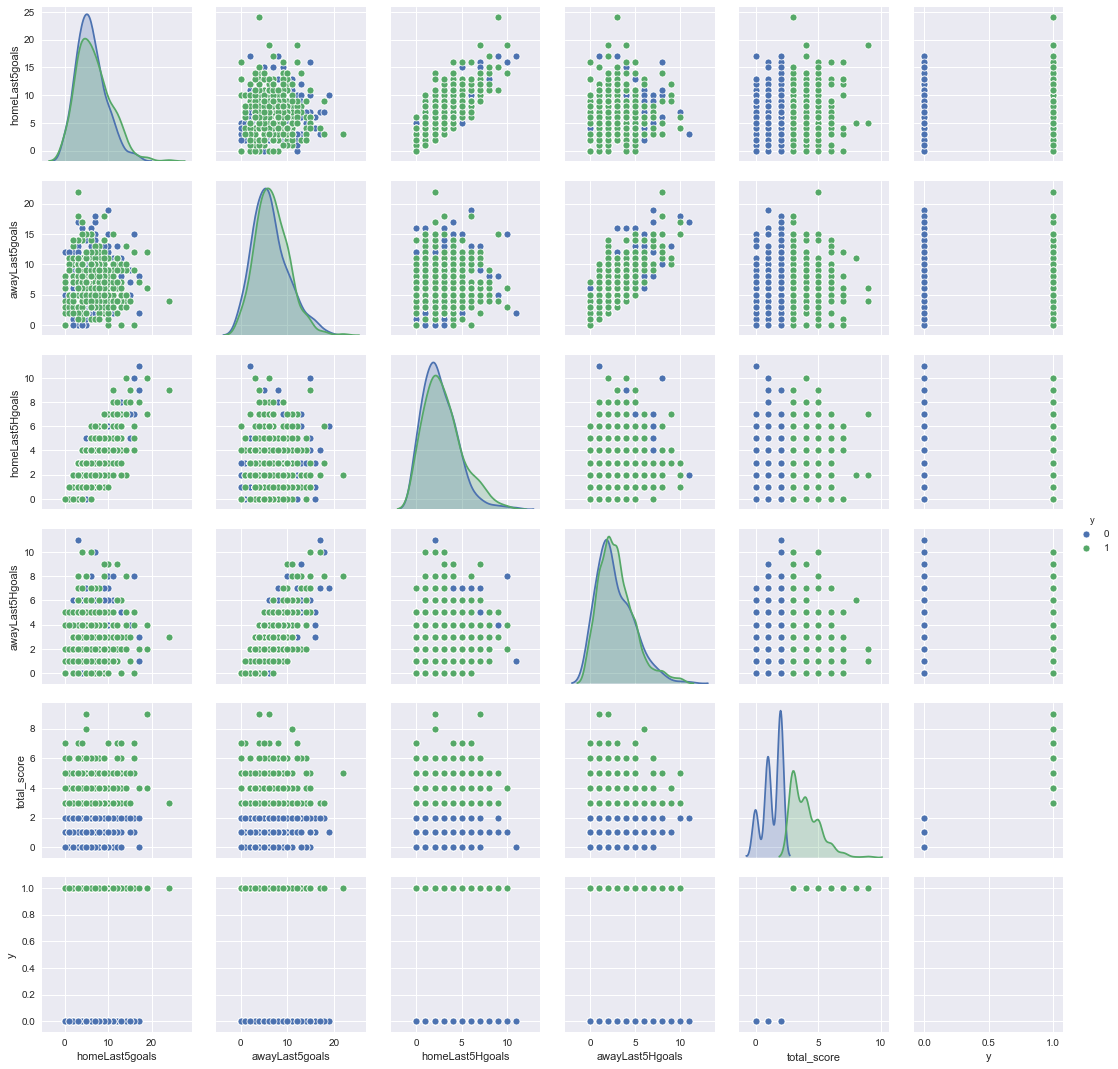

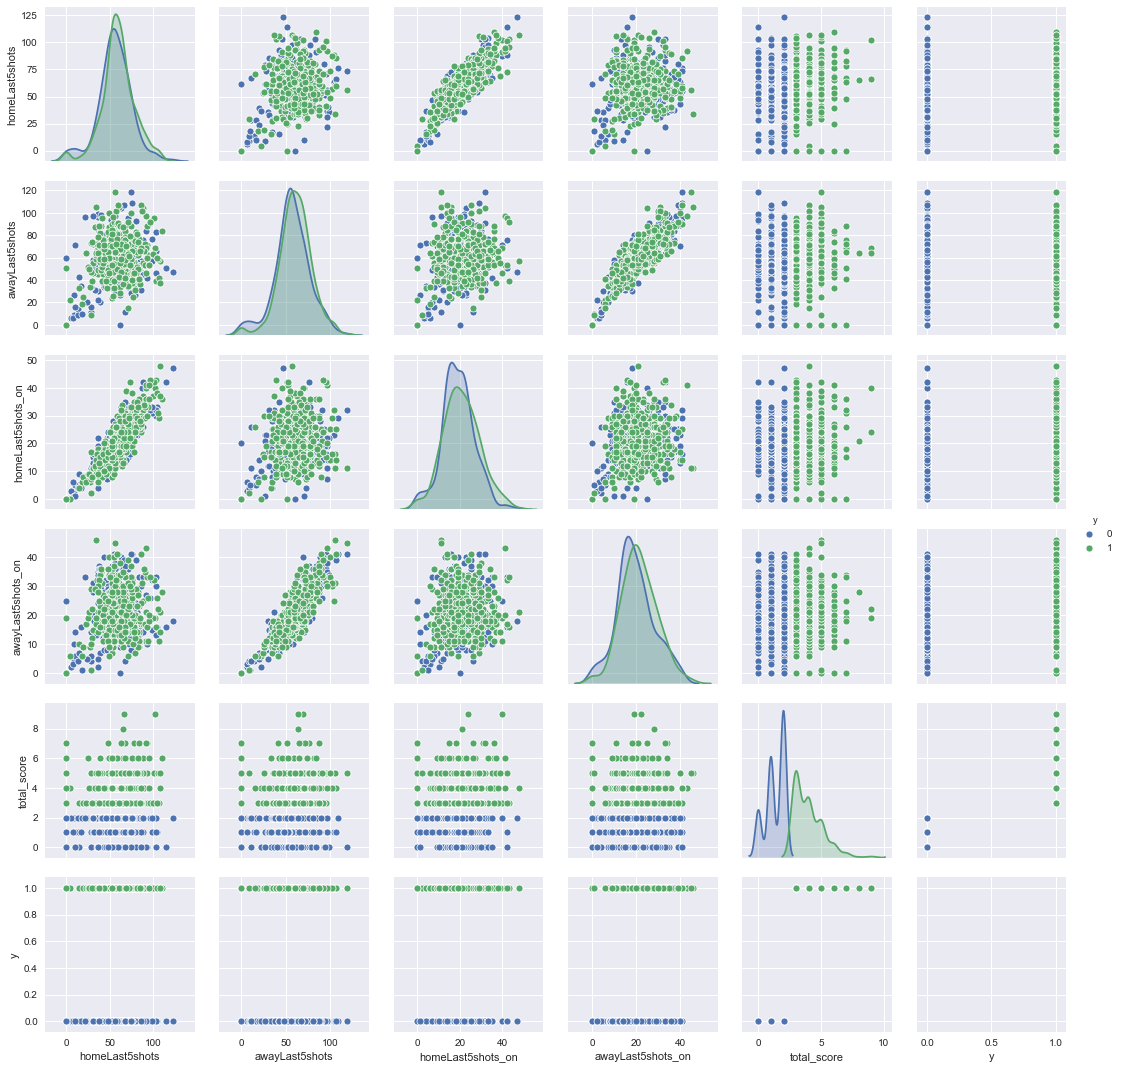

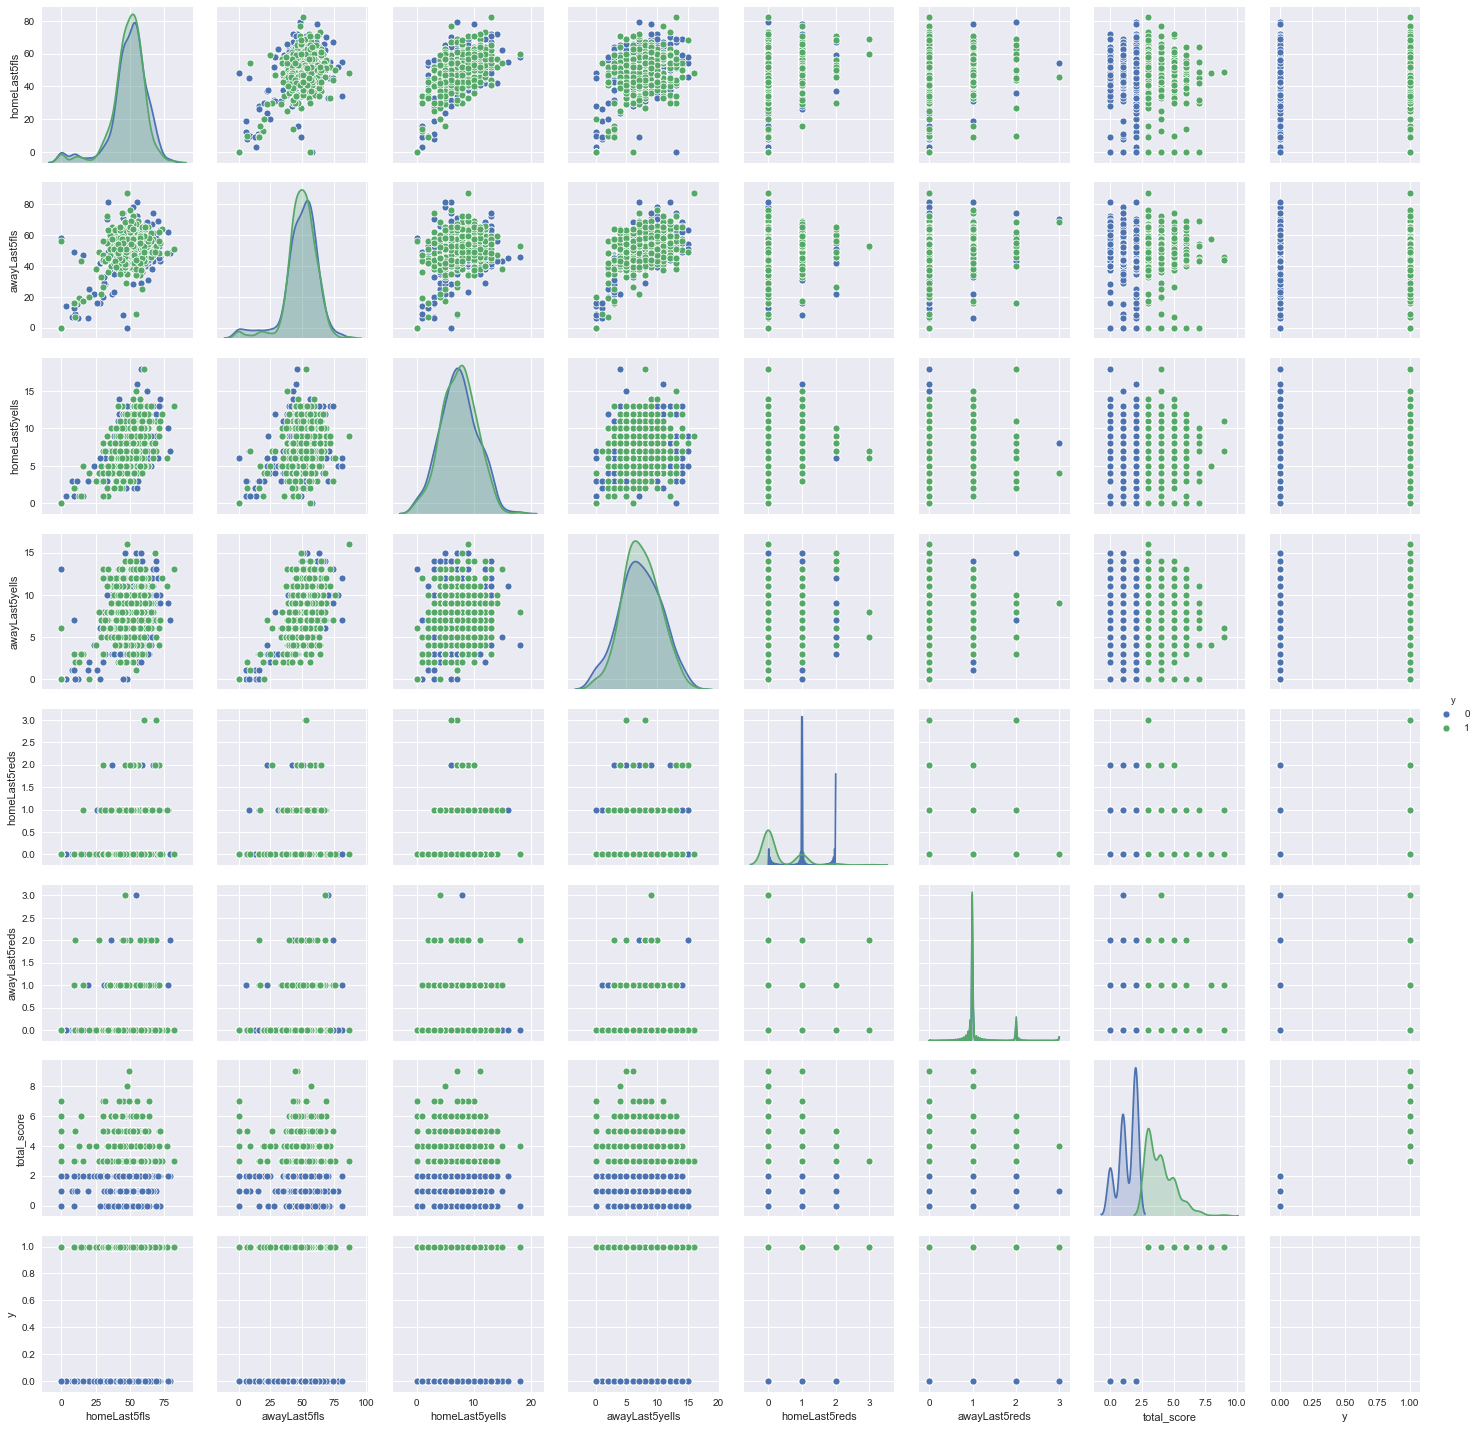

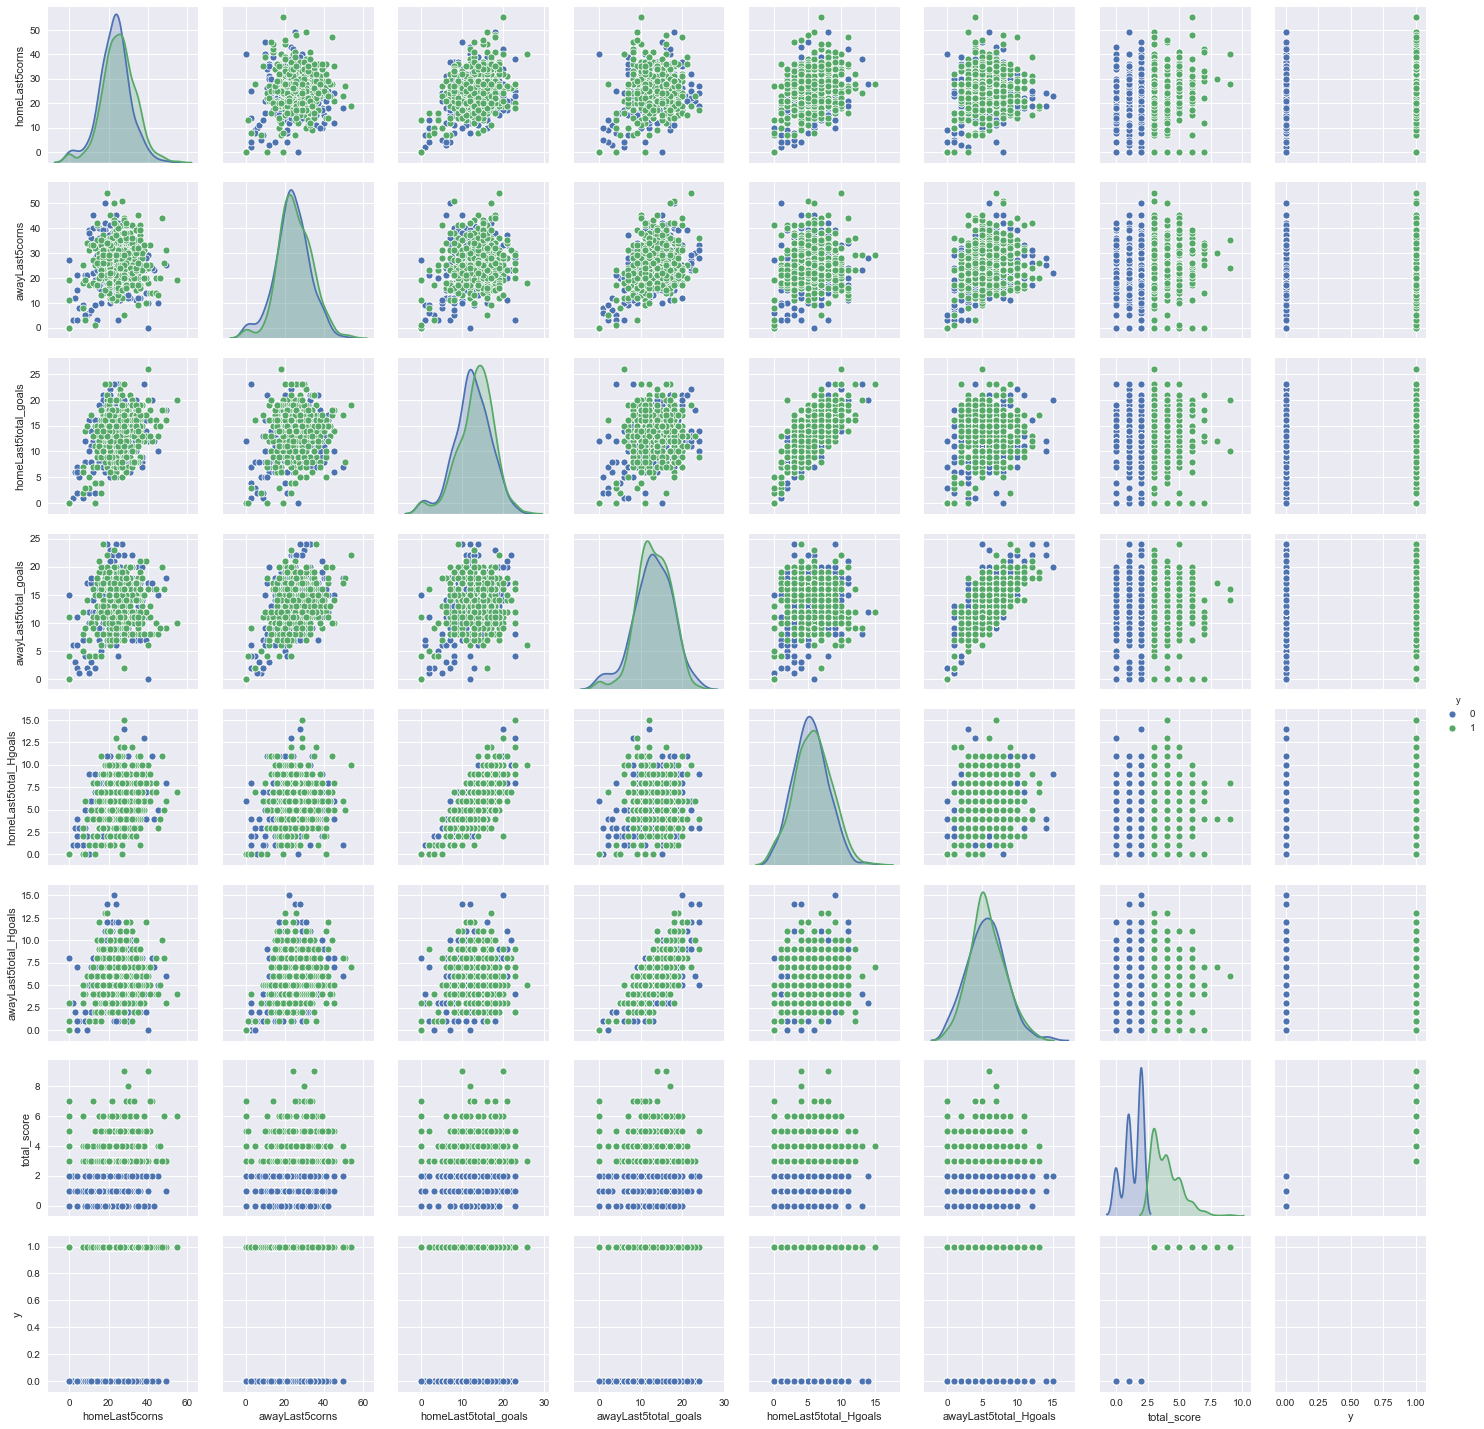

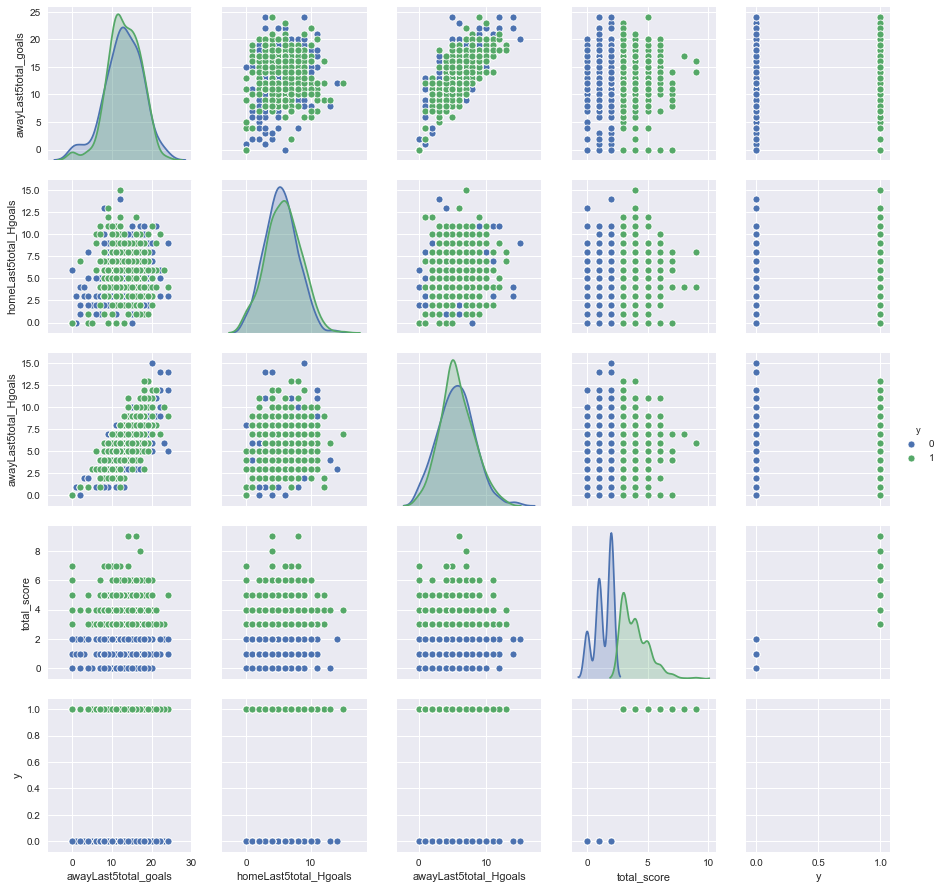

In [39]:
# last lets look at scatter plots of our new features and total score 
def crplt_func(input, df=df_final):
    """input: list"""
    for i in ['total_score', 'y']:
        input.append(i)
        
    pplot_df = df[input]    
    sns.pairplot(pplot_df, hue='y')
    
crplt_func(['homeLast5goals', 'awayLast5goals', 'homeLast5Hgoals', 
            'awayLast5Hgoals'])
crplt_func(['homeLast5shots', 'awayLast5shots', 
            'homeLast5shots_on', 'awayLast5shots_on'])
crplt_func(['homeLast5fls', 'awayLast5fls', 'homeLast5yells', 
            'awayLast5yells', 'homeLast5reds', 'awayLast5reds']) 
crplt_func(['homeLast5corns', 'awayLast5corns', 'homeLast5total_goals',
            'awayLast5total_goals', 'homeLast5total_Hgoals', 
            'awayLast5total_Hgoals'])
crplt_func(['awayLast5total_goals', 'homeLast5total_Hgoals', 
            'awayLast5total_Hgoals'])

<Figure size 1440x720 with 0 Axes>

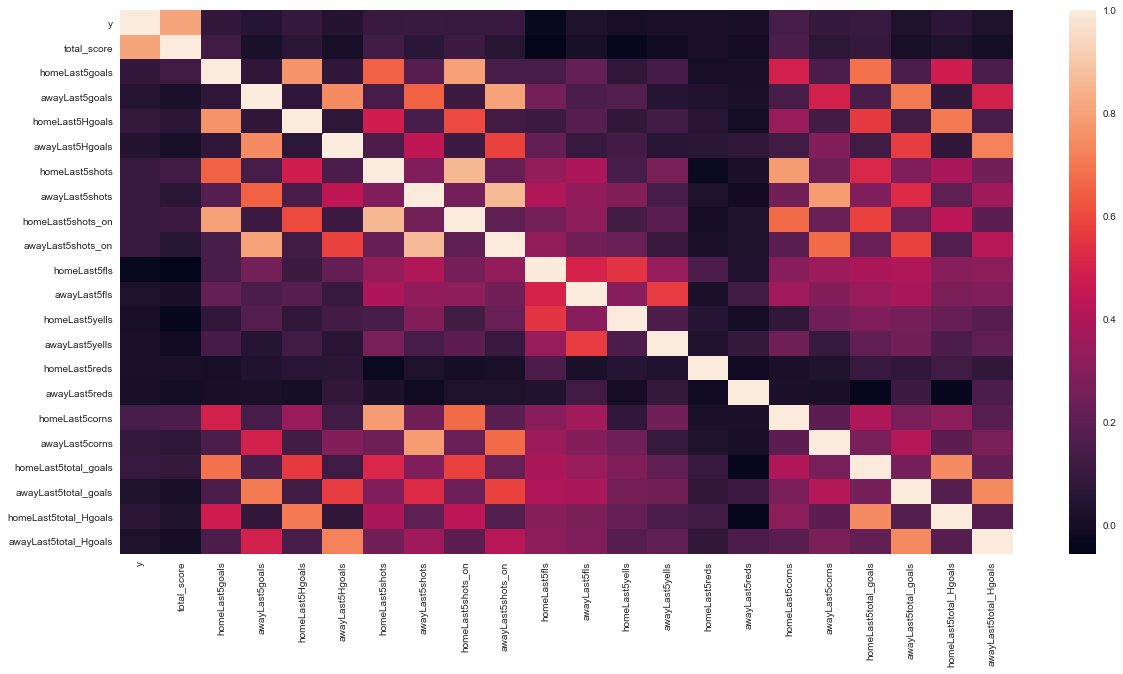

In [40]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_final.corr())
plt.show()

In [41]:
# filter above 5 gameweek so that we have enough data for last 5 fields
df_final = df_final[df_final.Date >= '2017-09-23'].reset_index(drop=True)
df_final.head()
df_final.tail()
df_final.info()

y        Date     HomeTeam    AwayTeam   Referee  total_score  \
0  1  2017-09-23     West Ham   Tottenham  M Oliver            5   
1  1  2017-09-23      Swansea     Watford   L Mason            3   
2  1  2017-09-23        Stoke     Chelsea    M Dean            4   
3  0  2017-09-23  Southampton  Man United  C Pawson            1   
4  1  2017-09-23    Leicester   Liverpool  A Taylor            5   

   homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
0             4.0             7.0              1.0              2.0   
1             2.0             7.0              1.0              3.0   
2             5.0             8.0              1.0              4.0   
3             4.0            16.0              3.0              4.0   
4             7.0             9.0              3.0              4.0   

   homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
0            61.0           105.0               16.0               31.0   
1            31.0            55.0                8.0               15.0   
2            59.0            75.0               16.0               25.0   
3            71.0            95.0               15.0               36.0   
4            49.0           100.0               14.0               40.0   

   homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  homeLast5reds  \
0          46.0          58.0             9.0             7.0            1.0   
1          51.0          54.0             8.0             5.0            0.0   
2          46.0          68.0             4.0             9.0            0.0   
3          59.0          63.0             5.0             5.0            0.0   
4          44.0          42.0             6.0             9.0            0.0   

   awayLast5reds  homeLast5corns  awayLast5corns  homeLast5total_goals  \
0            0.0            21.0            45.0                  14.0   
1            1.0            12.0            18.0                   7.0   
2            3.0            23.0            31.0                  11.0   
3            0.0            36.0            40.0                   8.0   
4            1.0            19.0            26.0                  16.0   

   awayLast5total_goals  homeLast5total_Hgoals  awayLast5total_Hgoals  
0                  10.0                    5.0                    3.0  
1                  16.0                    2.0                    7.0  
2                  13.0                    4.0                    7.0  
3                  18.0                    5.0                    5.0  
4                  18.0                    6.0                    9.0

y        Date    HomeTeam        AwayTeam     Referee  total_score  \
614  1  2019-03-02     Burnley  Crystal Palace   L Probert            4   
615  1  2019-03-02  Man United     Southampton   S Attwell            5   
616  1  2019-03-03      Fulham         Chelsea     G Scott            3   
617  0  2019-03-03     Everton       Liverpool  M Atkinson            0   
618  1  2019-03-03     Watford       Leicester      J Moss            3   

     homeLast5goals  awayLast5goals  homeLast5Hgoals  awayLast5Hgoals  \
614             8.0             9.0              1.0              3.0   
615             9.0             5.0              4.0              2.0   
616             5.0             7.0              1.0              2.0   
617             5.0            10.0              3.0              6.0   
618             7.0             5.0              2.0              2.0   

     homeLast5shots  awayLast5shots  homeLast5shots_on  awayLast5shots_on  \
614            52.0            81.0               21.0               21.0   
615            72.0            61.0               29.0               23.0   
616            69.0            70.0               19.0               20.0   
617            48.0            67.0               18.0               29.0   
618            38.0            88.0               13.0               25.0   

     homeLast5fls  awayLast5fls  homeLast5yells  awayLast5yells  \
614          43.0          51.0            11.0            10.0   
615          52.0          64.0            11.0             6.0   
616          60.0          49.0            10.0             5.0   
617          56.0          60.0             9.0             7.0   
618          58.0          37.0            10.0            11.0   

     homeLast5reds  awayLast5reds  homeLast5corns  awayLast5corns  \
614            0.0            1.0            24.0            37.0   
615            0.0            0.0            26.0            24.0   
616            0.0            0.0            20.0            28.0   
617            2.0            0.0            18.0            33.0   
618            0.0            0.0            20.0            29.0   

     homeLast5total_goals  awayLast5total_goals  homeLast5total_Hgoals  \
614                  15.0                  15.0                    3.0   
615                  12.0                  11.0                    4.0   
616                  17.0                  19.0                   10.0   
617                  11.0                  12.0                    6.0   
618                  15.0                  15.0                    4.0   

     awayLast5total_Hgoals  
614                    5.0  
615                    5.0  
616                    8.0  
617                    8.0  
618                    6.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 26 columns):
y                        int64
Date                     object
HomeTeam                 object
AwayTeam                 object
Referee                  object
total_score              int64
homeLast5goals           float64
awayLast5goals           float64
homeLast5Hgoals          float64
awayLast5Hgoals          float64
homeLast5shots           float64
awayLast5shots           float64
homeLast5shots_on        float64
awayLast5shots_on        float64
homeLast5fls             float64
awayLast5fls             float64
homeLast5yells           float64
awayLast5yells           float64
homeLast5reds            float64
awayLast5reds            float64
homeLast5corns           float64
awayLast5corns           float64
homeLast5total_goals     float64
awayLast5total_goals     float64
homeLast5total_Hgoals    float64
awayLast5total_Hgoals    float64
dtypes: float64(20), int64(2), object(4)
memo

<Figure size 1440x720 with 0 Axes>

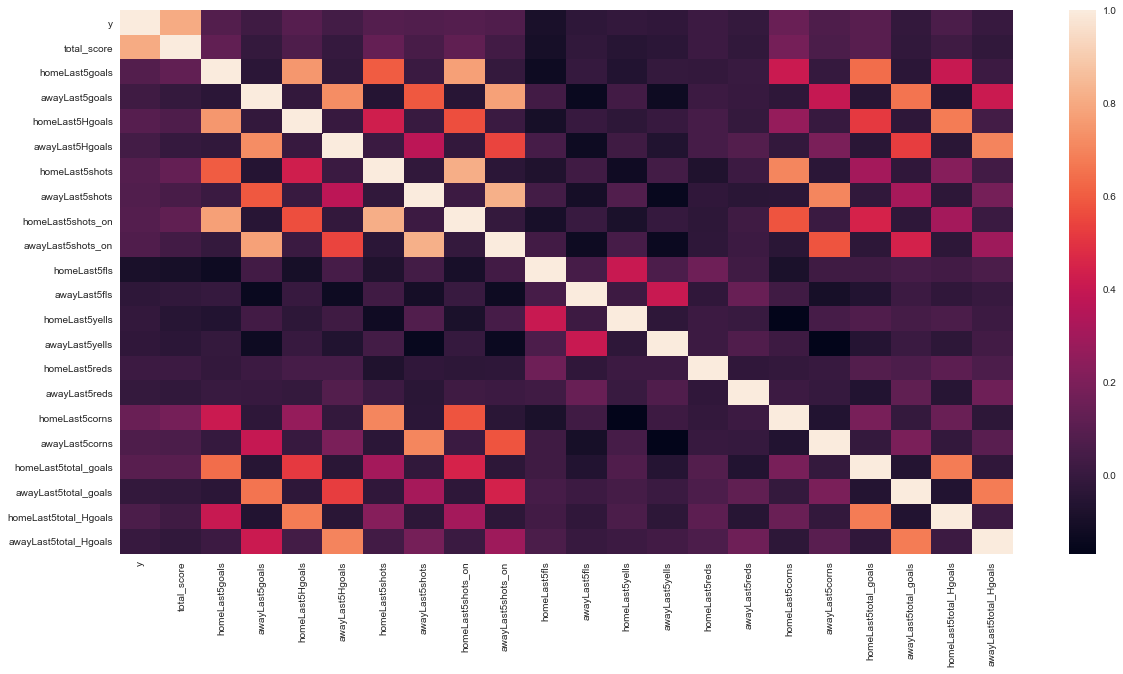

In [42]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df_final.corr())
plt.show()

### notice that how the corr matrix got slight "better" for some 
### features after we removed the gameweek matches that didn't have 
### features regarding the last 5 weeks match statistics

# Modeling

In [43]:
# lets drop total score before moving on to model building 
df_final['label'] = df_final['y']
df_final = df_final.drop(columns=['total_score', 'y'])

# and get month to use in one hot encoding
# maybe fixture congested months like january
# can give insights into the number of potential
# goals a match will have
df_final['mon'] = pd.DatetimeIndex(df_final['Date']).month.astype(object)
df_final = df_final.drop(columns=['Date']) # then drop Date
df_final.head()
df_final.tail()
df_final.info(verbose=True, null_counts=True)

# lets check for label imbalance one last time
df_final.groupby('label')['HomeTeam'].count().divide(619)

HomeTeam    AwayTeam   Referee  homeLast5goals  awayLast5goals  \
0     West Ham   Tottenham  M Oliver             4.0             7.0   
1      Swansea     Watford   L Mason             2.0             7.0   
2        Stoke     Chelsea    M Dean             5.0             8.0   
3  Southampton  Man United  C Pawson             4.0            16.0   
4    Leicester   Liverpool  A Taylor             7.0             9.0   

   homeLast5Hgoals  awayLast5Hgoals  homeLast5shots  awayLast5shots  \
0              1.0              2.0            61.0           105.0   
1              1.0              3.0            31.0            55.0   
2              1.0              4.0            59.0            75.0   
3              3.0              4.0            71.0            95.0   
4              3.0              4.0            49.0           100.0   

   homeLast5shots_on  awayLast5shots_on  homeLast5fls  awayLast5fls  \
0               16.0               31.0          46.0          58.0   
1                8.0               15.0          51.0          54.0   
2               16.0               25.0          46.0          68.0   
3               15.0               36.0          59.0          63.0   
4               14.0               40.0          44.0          42.0   

   homeLast5yells  awayLast5yells  homeLast5reds  awayLast5reds  \
0             9.0             7.0            1.0            0.0   
1             8.0             5.0            0.0            1.0   
2             4.0             9.0            0.0            3.0   
3             5.0             5.0            0.0            0.0   
4             6.0             9.0            0.0            1.0   

   homeLast5corns  awayLast5corns  homeLast5total_goals  awayLast5total_goals  \
0            21.0            45.0                  14.0                  10.0   
1            12.0            18.0                   7.0                  16.0   
2            23.0            31.0                  11.0                  13.0   
3            36.0            40.0                   8.0                  18.0   
4            19.0            26.0                  16.0                  18.0   

   homeLast5total_Hgoals  awayLast5total_Hgoals  label mon  
0                    5.0                    3.0      1   9  
1                    2.0                    7.0      1   9  
2                    4.0                    7.0      1   9  
3                    5.0                    5.0      0   9  
4                    6.0                    9.0      1   9

HomeTeam        AwayTeam     Referee  homeLast5goals  awayLast5goals  \
614     Burnley  Crystal Palace   L Probert             8.0             9.0   
615  Man United     Southampton   S Attwell             9.0             5.0   
616      Fulham         Chelsea     G Scott             5.0             7.0   
617     Everton       Liverpool  M Atkinson             5.0            10.0   
618     Watford       Leicester      J Moss             7.0             5.0   

     homeLast5Hgoals  awayLast5Hgoals  homeLast5shots  awayLast5shots  \
614              1.0              3.0            52.0            81.0   
615              4.0              2.0            72.0            61.0   
616              1.0              2.0            69.0            70.0   
617              3.0              6.0            48.0            67.0   
618              2.0              2.0            38.0            88.0   

     homeLast5shots_on  awayLast5shots_on  homeLast5fls  awayLast5fls  \
614               21.0               21.0          43.0          51.0   
615               29.0               23.0          52.0          64.0   
616               19.0               20.0          60.0          49.0   
617               18.0               29.0          56.0          60.0   
618               13.0               25.0          58.0          37.0   

     homeLast5yells  awayLast5yells  homeLast5reds  awayLast5reds  \
614            11.0            10.0            0.0            1.0   
615            11.0             6.0            0.0            0.0   
616            10.0             5.0            0.0            0.0   
617             9.0             7.0            2.0            0.0   
618            10.0            11.0            0.0            0.0   

     homeLast5corns  awayLast5corns  homeLast5total_goals  \
614            24.0            37.0                  15.0   
615            26.0            24.0                  12.0   
616            20.0            28.0                  17.0   
617            18.0            33.0                  11.0   
618            20.0            29.0                  15.0   

     awayLast5total_goals  homeLast5total_Hgoals  awayLast5total_Hgoals  \
614                  15.0                    3.0                    5.0   
615                  11.0                    4.0                    5.0   
616                  19.0                   10.0                    8.0   
617                  12.0                    6.0                    8.0   
618                  15.0                    4.0                    6.0   

     label mon  
614      1   3  
615      1   3  
616      1   3  
617      0   3  
618      1   3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Data columns (total 25 columns):
HomeTeam                 619 non-null object
AwayTeam                 619 non-null object
Referee                  619 non-null object
homeLast5goals           619 non-null float64
awayLast5goals           619 non-null float64
homeLast5Hgoals          619 non-null float64
awayLast5Hgoals          619 non-null float64
homeLast5shots           619 non-null float64
awayLast5shots           619 non-null float64
homeLast5shots_on        619 non-null float64
awayLast5shots_on        619 non-null float64
homeLast5fls             619 non-null float64
awayLast5fls             619 non-null float64
homeLast5yells           619 non-null float64
awayLast5yells           619 non-null float64
homeLast5reds            619 non-null float64
awayLast5reds            619 non-null float64
homeLast5corns           619 non-null float64
awayLast5corns           619 non-null float64
homeLast5total_goals    

label
0    0.463651
1    0.536349
Name: HomeTeam, dtype: float64

In [44]:
# create dataframe for PySpark model
sp_final = spark.createDataFrame(df_final)

In [45]:
sp_final.show(5)

+-----------+----------+--------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+---------------------+---------------------+-----+---+
|   HomeTeam|  AwayTeam| Referee|homeLast5goals|awayLast5goals|homeLast5Hgoals|awayLast5Hgoals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5fls|awayLast5fls|homeLast5yells|awayLast5yells|homeLast5reds|awayLast5reds|homeLast5corns|awayLast5corns|homeLast5total_goals|awayLast5total_goals|homeLast5total_Hgoals|awayLast5total_Hgoals|label|mon|
+-----------+----------+--------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+-------------+-----------

In [46]:
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# lets first create pipeline to transform the categorical
# and numerical columns for logistic regression

categoricalColumns = ['HomeTeam', 'AwayTeam', 'Referee', 'mon']
cat_stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "catVec"])
    cat_stages += [stringIndexer, encoder]
    
    
assemblerInputs = [c + "catVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="featuresCat")
cat_stages += [assembler] 

# create cat pipeline
pipelineCat = Pipeline(stages=cat_stages)     
    
numericCols = ['homeLast5goals', 'awayLast5goals', 
               'homeLast5Hgoals', 'awayLast5Hgoals',
               'homeLast5shots', 'awayLast5shots', 
               'homeLast5shots_on', 'awayLast5shots_on',
               'homeLast5fls', 'awayLast5fls', 
               'homeLast5yells', 'awayLast5yells',
               'homeLast5reds', 'awayLast5reds',
               'homeLast5corns', 'awayLast5corns',
               'homeLast5total_goals', 'awayLast5total_goals',
               'homeLast5total_Hgoals', 'awayLast5total_Hgoals'] 

assemblerNum = VectorAssembler(inputCols=numericCols, outputCol="featuresNum0")
standardScalerNum = StandardScaler(inputCol="featuresNum0", outputCol="featuresNum")
   
# create numeric feature pipeline
pipelineNum = Pipeline(stages=[assemblerNum, standardScalerNum])

pipeline = Pipeline(stages=[pipelineCat,pipelineNum,
                            VectorAssembler(inputCols=["featuresCat", "featuresNum"], 
                                        outputCol="features")])
pipedData = pipeline.fit(sp_final).transform(sp_final)

trainData, testData = pipedData.randomSplit([0.8, 0.2], seed=12345)

lr = LogisticRegression()

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, np.arange(0, .1, .01)) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) # don't have much data yet

cvModel = crossval.fit(trainData)


# cross_val = StratifiedCrossValidator(estimator=pipeline,
#                                     estimatorParamMaps=paramGrid,
#                                     evaluator=BinaryClassificationEvaluator(),
#                                     numFolds=5) 

In [47]:
testData.show(5)

+-----------+---------+----------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+---------------------+---------------------+-----+---+-------------+--------------+-------------+---------------+------------+---------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+
|   HomeTeam| AwayTeam|   Referee|homeLast5goals|awayLast5goals|homeLast5Hgoals|awayLast5Hgoals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5fls|awayLast5fls|homeLast5yells|awayLast5yells|homeLast5reds|awayLast5reds|homeLast5corns|awayLast5corns|homeLast5total_goals|awayLast5total_goals|homeLast5total_Hgoals|awayLast5total_Hgoals|label|mon|HomeTeamIndex|HomeTeamcatVec|AwayTeamIndex| AwayTeamcatVec|R

In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

trainingSummary = cvModel.bestModel.summary

predictions = cvModel.transform(testData)
predictions.show(1)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + \
      str(evaluator.evaluate(predictions, 
                             {evaluator.metricName: "areaUnderROC"})))

+--------+---------+---------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+---------------------+---------------------+-----+---+-------------+--------------+-------------+--------------+------------+---------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|HomeTeam| AwayTeam|  Referee|homeLast5goals|awayLast5goals|homeLast5Hgoals|awayLast5Hgoals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5fls|awayLast5fls|homeLast5yells|awayLast5yells|homeLast5reds|awayLast5reds|homeLast5corns|awayLast5corns|homeLast5total_goals|awayLast5total_goals|homeLast5total_Hgoals|awayLast5total_Hgoals|label|mon|HomeTeamIndex|Ho

Text(0, 0.5, 'False Positive Rate')

Text(0.5, 0, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

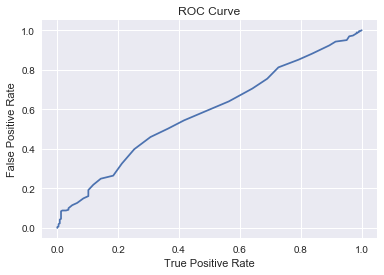

Training set areaUnderROC: 0.5819766987254672


In [49]:
# lets plot the ROC Curve
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Text(0, 0.5, 'Precision')

Text(0.5, 0, 'Recall')

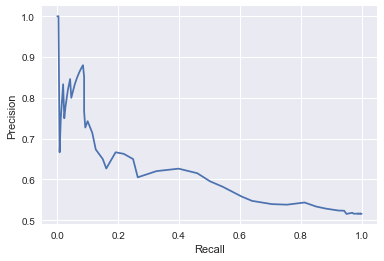

In [50]:
# lets plot the Precision-Recall Curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### so far the logistic model is not very good, but the goal of this full stack data science project is to exhibiti all aspects of data science/engineering.  So far we have accomplished data transformation and manipulation, as well as machine learning.  We have utilized python, Pandas, Spark SQL, and Spark MLlib.  Next we will try out a gradient boosted tree to see if we can improve on the model's binary classification performance.  Then we will save the best model as a json and serve the json as an API in a Flask API and app.

In [51]:
from pyspark.ml.feature import OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# lets first create pipeline to transform the categorical
# and numerical columns for logistic regression

categoricalColumns = ['HomeTeam', 'AwayTeam', 'Referee', 'mon']
cat_stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "catVec"])
    cat_stages += [stringIndexer, encoder]
    
    
assemblerInputs = [c + "catVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="featuresCat")
cat_stages += [assembler] 

# create cat pipeline
pipelineCat = Pipeline(stages=cat_stages)     
    
numericCols = ['homeLast5goals', 'awayLast5goals', 
               'homeLast5Hgoals', 'awayLast5Hgoals',
               'homeLast5shots', 'awayLast5shots', 
               'homeLast5shots_on', 'awayLast5shots_on',
               'homeLast5fls', 'awayLast5fls', 
               'homeLast5yells', 'awayLast5yells',
               'homeLast5reds', 'awayLast5reds',
               'homeLast5corns', 'awayLast5corns',
               'homeLast5total_goals', 'awayLast5total_goals',
               'homeLast5total_Hgoals', 'awayLast5total_Hgoals'] 

assemblerNum = VectorAssembler(inputCols=numericCols, outputCol="featuresNum")

pipeline = Pipeline(stages=[pipelineCat,assemblerNum,
                            VectorAssembler(inputCols=["featuresCat", "featuresNum"], 
                                        outputCol="features")])
pipedData = pipeline.fit(sp_final).transform(sp_final)

trainData, testData = pipedData.randomSplit([0.8, 0.2], seed=12345)

gbtc = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbtc.subsamplingRate, np.arange(0.1, 1.0, .1)) \
    .addGrid(gbtc.maxDepth, [2, 4, 6, 8]) \
    .build()

evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

crossval = CrossValidator(estimator=gbtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2) # don't have much data yet

cvModel = crossval.fit(trainData)


# cross_val = StratifiedCrossValidator(estimator=pipeline,
#                                     estimatorParamMaps=paramGrid,
#                                     evaluator=BinaryClassificationEvaluator(),
#                                     numFolds=5) 

In [52]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = cvModel.transform(testData)
predictions.show(1)

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + \
      str(evaluator.evaluate(predictions, 
                             {evaluator.metricName: "areaUnderROC"})))
print("numNodes = ", cvModel.bestModel.totalNumNodes)
print("numTrees = ", cvModel.bestModel.getNumTrees)

+--------+---------+---------+--------------+--------------+---------------+---------------+--------------+--------------+-----------------+-----------------+------------+------------+--------------+--------------+-------------+-------------+--------------+--------------+--------------------+--------------------+---------------------+---------------------+-----+---+-------------+--------------+-------------+--------------+------------+---------------+--------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|HomeTeam| AwayTeam|  Referee|homeLast5goals|awayLast5goals|homeLast5Hgoals|awayLast5Hgoals|homeLast5shots|awayLast5shots|homeLast5shots_on|awayLast5shots_on|homeLast5fls|awayLast5fls|homeLast5yells|awayLast5yells|homeLast5reds|awayLast5reds|homeLast5corns|awayLast5corns|homeLast5total_goals|awayLast5total_goals|homeLast5total_Hgoals|awayLast5total_Hgoals|label|mon|HomeTeamIndex|HomeTeamcatVec|AwayTeam

In [70]:
model = pd.DataFrame(cvModel.bestModel.featureImportances.toArray(), columns=["values"])
pandasDF = pd.DataFrame(predictions.schema["features"].metadata["ml_attr"] 
                        ["attrs"]["binary"]+predictions.schema["features"] \
                        .metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")
feature_dict = dict(zip(pandasDF["idx"],pandasDF["name"])) 
features_col = pd.Series(feature_dict)
model["features"] = features_col
model
feature_dict

values                                   features
0   0.001990        featuresCat_HomeTeamcatVec_West Ham
1   0.000060         featuresCat_HomeTeamcatVec_Arsenal
2   0.005353        featuresCat_HomeTeamcatVec_Man City
3   0.005029         featuresCat_HomeTeamcatVec_Everton
4   0.000000     featuresCat_HomeTeamcatVec_Bournemouth
5   0.008660    featuresCat_HomeTeamcatVec_Huddersfield
6   0.000489       featuresCat_HomeTeamcatVec_Newcastle
7   0.013247       featuresCat_HomeTeamcatVec_Leicester
8   0.000017        featuresCat_HomeTeamcatVec_Brighton
9   0.002596         featuresCat_HomeTeamcatVec_Burnley
10  0.000002  featuresCat_HomeTeamcatVec_Crystal Palace
11  0.011644       featuresCat_HomeTeamcatVec_Tottenham
12  0.000000     featuresCat_HomeTeamcatVec_Southampton
13  0.004411         featuresCat_HomeTeamcatVec_Chelsea
14  0.000000         featuresCat_HomeTeamcatVec_Watford
15  0.000057       featuresCat_HomeTeamcatVec_Liverpool
16  0.000000      featuresCat_HomeTeamcatVec_Man United
17  0.003657         featuresCat_HomeTeamcatVec_Swansea
18  0.002834           featuresCat_HomeTeamcatVec_Stoke
19  0.006600       featuresCat_HomeTeamcatVec_West Brom
20  0.000000         featuresCat_HomeTeamcatVec_Cardiff
21  0.000000          featuresCat_HomeTeamcatVec_Wolves
22  0.006296  featuresCat_AwayTeamcatVec_Crystal Palace
23  0.005979       featuresCat_AwayTeamcatVec_Tottenham
24  0.000007     featuresCat_AwayTeamcatVec_Southampton
25  0.011648         featuresCat_AwayTeamcatVec_Watford
26  0.013349       featuresCat_AwayTeamcatVec_Liverpool
27  0.022238      featuresCat_AwayTeamcatVec_Man United
28  0.003467     featuresCat_AwayTeamcatVec_Bournemouth
29  0.004290    featuresCat_AwayTeamcatVec_Huddersfield
..       ...                                        ...
63  0.000000         featuresCat_RefereecatVec_S Hooper
64  0.001413                   featuresCat_moncatVec_12
65  0.010686                    featuresCat_moncatVec_1
66  0.000000                   featuresCat_moncatVec_11
67  0.000151                    featuresCat_moncatVec_2
68  0.002553                   featuresCat_moncatVec_10
69  0.006850                    featuresCat_moncatVec_9
70  0.000000                    featuresCat_moncatVec_3
71  0.000000                    featuresCat_moncatVec_4
72  0.007009                    featuresCat_moncatVec_8
73  0.021540                 featuresNum_homeLast5goals
74  0.030135                 featuresNum_awayLast5goals
75  0.023251                featuresNum_homeLast5Hgoals
76  0.040101                featuresNum_awayLast5Hgoals
77  0.042750                 featuresNum_homeLast5shots
78  0.009844                 featuresNum_awayLast5shots
79  0.058058              featuresNum_homeLast5shots_on
80  0.047859              featuresNum_awayLast5shots_on
81  0.070867                   featuresNum_homeLast5fls
82  0.036785                   featuresNum_awayLast5fls
83  0.047968                 featuresNum_homeLast5yells
84  0.040254                 featuresNum_awayLast5yells
85  0.000283                  featuresNum_homeLast5reds
86  0.000000                  featuresNum_awayLast5reds
87  0.052342                 featuresNum_homeLast5corns
88  0.034094                 featuresNum_awayLast5corns
89  0.041330           featuresNum_homeLast5total_goals
90  0.045602           featuresNum_awayLast5total_goals
91  0.019008          featuresNum_homeLast5total_Hgoals
92  0.033764          featuresNum_awayLast5total_Hgoals

[93 rows x 2 columns]

{0: 'featuresCat_HomeTeamcatVec_West Ham',
 1: 'featuresCat_HomeTeamcatVec_Arsenal',
 2: 'featuresCat_HomeTeamcatVec_Man City',
 3: 'featuresCat_HomeTeamcatVec_Everton',
 4: 'featuresCat_HomeTeamcatVec_Bournemouth',
 5: 'featuresCat_HomeTeamcatVec_Huddersfield',
 6: 'featuresCat_HomeTeamcatVec_Newcastle',
 7: 'featuresCat_HomeTeamcatVec_Leicester',
 8: 'featuresCat_HomeTeamcatVec_Brighton',
 9: 'featuresCat_HomeTeamcatVec_Burnley',
 10: 'featuresCat_HomeTeamcatVec_Crystal Palace',
 11: 'featuresCat_HomeTeamcatVec_Tottenham',
 12: 'featuresCat_HomeTeamcatVec_Southampton',
 13: 'featuresCat_HomeTeamcatVec_Chelsea',
 14: 'featuresCat_HomeTeamcatVec_Watford',
 15: 'featuresCat_HomeTeamcatVec_Liverpool',
 16: 'featuresCat_HomeTeamcatVec_Man United',
 17: 'featuresCat_HomeTeamcatVec_Swansea',
 18: 'featuresCat_HomeTeamcatVec_Stoke',
 19: 'featuresCat_HomeTeamcatVec_West Brom',
 20: 'featuresCat_HomeTeamcatVec_Cardiff',
 21: 'featuresCat_HomeTeamcatVec_Wolves',
 22: 'featuresCat_AwayTeamcatVe

In [55]:
print(cvModel.bestModel.stages.extractParamMap())

AttributeError: 'GBTClassificationModel' object has no attribute 'stages'

In [63]:
pandasDF = pd.DataFrame(predictions.schema["features"].metadata["ml_attr"] 
["attrs"]["binary"]+predictions.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

In [68]:
from pyspark.sql.functions import broadcast

feature_dict = dict(zip(pandasDF["idx"],pandasDF["name"])) 

feature_dict

{0: 'featuresCat_HomeTeamcatVec_West Ham',
 1: 'featuresCat_HomeTeamcatVec_Arsenal',
 2: 'featuresCat_HomeTeamcatVec_Man City',
 3: 'featuresCat_HomeTeamcatVec_Everton',
 4: 'featuresCat_HomeTeamcatVec_Bournemouth',
 5: 'featuresCat_HomeTeamcatVec_Huddersfield',
 6: 'featuresCat_HomeTeamcatVec_Newcastle',
 7: 'featuresCat_HomeTeamcatVec_Leicester',
 8: 'featuresCat_HomeTeamcatVec_Brighton',
 9: 'featuresCat_HomeTeamcatVec_Burnley',
 10: 'featuresCat_HomeTeamcatVec_Crystal Palace',
 11: 'featuresCat_HomeTeamcatVec_Tottenham',
 12: 'featuresCat_HomeTeamcatVec_Southampton',
 13: 'featuresCat_HomeTeamcatVec_Chelsea',
 14: 'featuresCat_HomeTeamcatVec_Watford',
 15: 'featuresCat_HomeTeamcatVec_Liverpool',
 16: 'featuresCat_HomeTeamcatVec_Man United',
 17: 'featuresCat_HomeTeamcatVec_Swansea',
 18: 'featuresCat_HomeTeamcatVec_Stoke',
 19: 'featuresCat_HomeTeamcatVec_West Brom',
 20: 'featuresCat_HomeTeamcatVec_Cardiff',
 21: 'featuresCat_HomeTeamcatVec_Wolves',
 22: 'featuresCat_AwayTeamcatVe

In [62]:
# extract features metadata
meta = [f.metadata for f in predictions.schema.fields 
        if f.name == 'features'][0]

# access feature name and index
features_name_ind = meta['ml_attr']['attrs']['numeric'] + \
    meta['ml_attr']['attrs']['binary']

print(features_name_ind[:2])

[{'idx': 73, 'name': 'featuresNum_homeLast5goals'}, {'idx': 74, 'name': 'featuresNum_awayLast5goals'}]
